In [1]:
# imports
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\User\anaconda3\envs\BifacialSimu\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# WICHTIG!!!

### Benötigen wir die marginal_cost tags in den Modellen, wenn wir instandhaltung vernachlässigen?
Generell haben wir bis auf das Netz oder Gas ja keine marginal cost, da diese ja immer pro kWh einfließen. Instandhaltung müssten wir demnach dann auf den Wert €/kWh runterbrechen was echt schwierig bei unseren Komponenten wird. 

##### Falls wir keine marginal_costs mehr brauchen -> alle "marginal_cost" Parameter aus den Modellen löschen vor Abgabe. Wir sollten keine unnötigen parameter mehr in den Modellen stehen haben. Lifetime und build year bei den standard modellen habe ich schon weitesgehend rausgenommen

**Liste der noch zu erledigenden Dinge:** 
* kommentieren (codeblöcke kommentieren, Docstrings)
* bereinigen von Unnötigen Funktionen, Parametern etc.
* Plausibilitätscheck, Backtesting, Sensitivitätsanalyse (Wofür entscheiden wir uns für unser Modell?)
    - insbesondere bei h2_stored schauen, warum so wenig eingespeichert wurde (hier insbesondere "analyse"-Funktion bzw. "def results_summary")

**Benötigte Markdownzellen** 
* Fragestellung und Subfragestellungen um diese zu beantworten
* Datenvalidierung und validierung der Eignung in Form einer Tabelle
* Ausformulierte Markdown Zellen für Referenz und H2 Modelle mit kurzbeschreibung des Umfangs
* Einordnung der Ergebnisse als Markdown Zelle in Schriftlicher form
* Grenzen der Simulation und der Ergebnisse (die sich durch eventuelle vernachlässigungen wie Komponentenbezogene Instandhaltung

### Idee für eine Übergeordnete Fragestellung unter der wir dann mehrere kleine Fragestellungen mit kleinen Modellen Beantworten können: 
1. Welche technisch-ökonomischen Parametergrenzwerte sind im Kontext des Energieträgerwandels (Fossil-zu-Wasserstoff) für einen Um- oder Zubau einer saisonalen Speicher- und Versorgungsanlage in Eigenheimen und am Beispiel eines Einfamilienhauses in Wesseling relevant, um den Ausbau von Wasserstoffsystemen zu unterstützen und von welchem aktuellen Anlagenbestand ist eine Investition in einen Um- oder Zubau Empfehlenswert?** 
2. Welche spezifischen Investitionskosten müssen Wasserstoff-Systemkomponenten für eine erweiterte saisonale Speicherung erreichen, um ein Einfamilienhaus in Wesseling mit durchschnittlichem Strom- und Wärmebedarf, verglichen mit etablierten Energiekonzepten(PV + Batteriespeicher + Gasheizung/Wärmepumpe) mindestens äquivalent wirtschaftlich und konkurrenzfähig zu versorgen und korrelieren die notwendigen spezifischen Investitionskosten mit der Bewohneranzahl des Gebäudes?

3. Welche spezifischen Investitionskosten müssen für die Erweiterung verschiedener Energiekonzepte mit einem saisonalen Wasserstoffstpeicher bei einem Einfmailienhaus in Wesseling mit durchschnittlichem Strom- und Wärmebedarf in Abhängigkeit der Personenanzahl getätigt werden, sodass diese in einem Betrachtungszeitraum von 2020 bis 2050 "äquivalent wirtschaftlich und konkurrenzfähig" sind?
4. Welche spezifischen Investitionskosten und Lebensdauern müssen für die Erweiterung verschiedener Energiekonzepte mit einem saisonalen Wasserstoffspeicher- und Versorgungsystem bei einem Einfamilienhaus in Köln Wesseling mit durchschnittlichem Strom- und Wärmebedarf sichergestellt werden, sodass diese in einem Betrachtungszeitraum von 2020 bis 2050 "äquivalent wirtschaftlich und konkurrenzfähig" sind und welchen Einfluss hat die Personenanzahl auf ein konkurrenzfähiges System?

# Import der Basisdaten

### HIER MÜSSEN WIR NOCH EINMAL FESTHALTEN WOHER UNSERE DATEN KOMMEN UND DAS SAUBER AUFLISTEN

### PV-Daten: Renewables.Ninja
Basierend auf Europäischem Datenset:CM-SAF SARAH (Europe) hohe Genauigkeit, da Angabe aus (lon/lat) -> VLH = 1072

### Temperaturdaten: DWD open database
Basierend auf historischen Daten für das Jahr 2022 der Wetterstation am Flughafen Köln/Bonn (ca. 12km Luftlinie)
-> Kälteanomalie im Dezember: kurzzeitig Temperaturen bis -10-Grad

### Preisdaten: SMARD
Großhandels Strompreis auf die kWh-heruntergerechnet als Beispiel für einen Strompreis von z.B. dem Anbieter Tibber, welcher den Großhandelspreis an den Kunden stündlich weitergibt

### Lastprofile Synthetisch: synPRO (Frauenhofer)
Getrennte profile für Warmwasser, Heizung und Strom jeweils für einen 2, 4 und 6 Personen Haushalt in einem EFH

In [2]:
# data imports

# load pv_data
pv_data = pd.read_csv("data/ninja_pv_50.8263_6.9721.csv", decimal=".", header=3)

# load and prepare temp data
temp_data = pd.read_csv("data/DWD_wetterdaten_KoelnBonn_Flughafen.txt", sep=";", decimal=".", usecols=[1,3])
temp_data = temp_data[(temp_data['MESS_DATUM'] >= 2022010100) & (temp_data['MESS_DATUM'] < 2023010101)]

# load electricity price data
df_price_data = pd.read_csv("data/Strompreise2019_2022.csv", sep=";", decimal=".", usecols=[2,3,4])


# load loadprofile data
# 2 Residents EFH
el_2p = pd.read_csv('data/loads/2Pers/neighbourhood_el.csv', comment='#', sep=';')
dhw_2p = pd.read_csv('data/loads/2Pers/neighbourhood_dhw.csv', comment='#', sep=';')
htg_2p = pd.read_csv('data/loads/2Pers/neighbourhood_htg.csv', comment='#', sep=';')
# 4 Residents EFH
el_4p = pd.read_csv('data/loads/4Pers/neighbourhood_el.csv', comment='#', sep=';')
dhw_4p = pd.read_csv('data/loads/4Pers/neighbourhood_dhw.csv', comment='#', sep=';')
htg_4p = pd.read_csv('data/loads/4Pers/neighbourhood_htg.csv', comment='#', sep=';')
# 6 Residents EFH
el_6p = pd.read_csv('data/loads/6Pers/neighbourhood_el.csv', comment='#', sep=';')
dhw_6p = pd.read_csv('data/loads/6Pers/neighbourhood_dhw.csv', comment='#', sep=';')
htg_6p = pd.read_csv('data/loads/6Pers/neighbourhood_htg.csv', comment='#', sep=';')

# fill dataframe
df_data = pd.DataFrame()
df_data['pv'] = pv_data['electricity'].to_numpy()
df_data['temp'] = temp_data['TT_TU'].to_numpy()
df_data['ww_load_2p'] = dhw_2p['total']
df_data['ww_load_4p'] = dhw_4p['total']
df_data['ww_load_6p'] = dhw_6p['total']
df_data['e_load_2p'] = el_2p['total']
df_data['e_load_4p'] = el_4p['total']
df_data['e_load_6p'] = el_6p['total']
df_data['h_load_2p'] = htg_2p['total_htg']
df_data['h_load_4p'] = htg_4p['total_htg']
df_data['h_load_6p'] = htg_6p['total_htg']

# season operation of hydrogen system (If PV-power is higher than 0.55 then use ely, fc just in winter months)
df_season = pd.DataFrame()
df_season['ely_pv_threshhold'] = df_data['pv'].apply(lambda x: 1 if x >= 0.55 else 0)
df_season['fc_pv_threshhold'] = 1 - df_season['ely_pv_threshhold']
#df_season['ely'] = [1 if 1416 <= x <= 7296 else 0 for x in range(8760)]
df_season['ely'] = [1 for x in range(8760)]
df_season['fc'] = [0 if 3624 <= x <= 6552 else 1 for x in range(8760)]


#df_data['pv'].plot()
#df_data.plot(y=["h_load_2p", "ww_load_2p", "e_load_2p"])
#df_season.plot(y=["ely", "fc"])
#df_season['ely']

In [3]:
# calculation and data preparation for heat_pump(wp)

# scraped data
wp_data = {
    "temp" : [-22, -15, -7, 2, 7, 10, 12, 20, 25, 30, 35],
    "heating_power" : [0, 25.50, 35.20, 43.00, 56.40, 60.30, 62.90, 67.30, 70.40, 73.60, 76.70],
    "el_power" : [0, 14.58, 15.54, 16.70, 18.54, 18.87, 18.87, 19.05, 19.13, 19.36, 19.46],
    "cop" : [0, 1.7, 2.3, 2.6, 3.0, 3.2, 3.3, 3.5, 3.7, 3.8, 3.9]
}

# assumptions
wp_el_p_nom = 12.5  # kW

# calculate COP
df_data["wp_COP_interp"] = np.round(np.interp(df_data['temp'], wp_data["temp"], wp_data["cop"]),3)
df_data["wp_power_consumption"] = np.round(np.interp(df_data['temp'], wp_data["temp"], wp_data["el_power"]),2)
df_data['wp_power_cons_norm'] = df_data["wp_power_consumption"] / wp_el_p_nom

df_data

,pv,temp,ww_load_2p,ww_load_4p,ww_load_6p,e_load_2p,e_load_4p,e_load_6p,h_load_2p,h_load_4p,h_load_6p,wp_COP_interp,wp_power_consumption,wp_power_cons_norm
0,0.0,12.6,0.000000,0.0,1.518594,0.087042,0.108191,0.136886,1.287577,1.274003,1.295842,3.315,18.88,1.5104
1,0.0,13.0,0.000000,0.0,0.000000,0.087303,0.086217,0.135976,1.799948,1.798675,1.809386,3.325,18.89,1.5112
2,0.0,12.6,0.000000,0.0,0.000000,0.086005,0.085922,0.135816,2.128495,2.127315,2.138208,3.315,18.88,1.5104
3,0.0,12.2,0.000000,0.0,0.000000,0.082747,0.109169,0.181411,2.381928,2.364143,2.376183,3.305,18.87,1.5096
4,0.0,12.8,0.000000,0.0,0.000000,0.075984,0.108558,0.179553,2.553156,2.529228,2.542549,3.320,18.89,1.5112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0.0,15.1,0.000000,0.0,0.000000,0.143545,0.545067,0.574078,1.614701,1.330839,1.452981,3.378,18.94,1.5152
8756,0.0,15.9,0.000000,0.0,0.035994,0.142139,0.228792,1.003943,1.681241,1.550685,1.110155,3.398,18.96,1.5168
8757,0.0,15.9,0.000000,0.0,0.000000,0.142010,0.291029,0.977002,1.713969,1.539984,1.098378,3.398,18.96,1.5168
8758,0.0,15.6,2.712356,0.0,0.971850,0.141723,0.330328,0.473260,1.708129,1.495063,1.420826,3.390,18.95,1.5160


In [4]:
# globals for multi incestment periods
multi_years = range(2023, 2044, 2)
observation_period = multi_years[-1] - multi_years[0]
max_lifetime = observation_period + 1
freq = 1

snapshots = pd.DatetimeIndex([])
for year in multi_years:
    period = pd.date_range(start='{}-01-01 00:00'.format(year),
                           freq='{}H'.format(str(freq)),
                           periods=8760 / float(freq),
                          )
    snapshots = snapshots.append(period)
    
multi_index = pd.MultiIndex.from_arrays([snapshots.year, snapshots])

In [5]:
# reform data for multi investment periods

# Multi Year Datasets
# copy data
df_mdata = df_data.copy()
df_mseason = df_season.copy()

# reindex datasets
df_mdata.index = pd.date_range(start='{}-01-01 00:00:00'.format(multi_years[0]), periods=8760, freq='H')
df_mseason.index = pd.date_range(start='{}-01-01 00:00:00'.format(multi_years[0]), periods=8760, freq='H')

# rescale if frequency > 1
if freq > 1:
    df_mdata = df_mdata.resample(rule='{}H'.format(str(freq))).mean()
    df_mseason = df_mseason.resample(rule='{}H'.format(str(freq))).mean()
    

# multi period dataframe
# df_mdata_1h_xy = pd.concat([df_mdata]*len(multi_years), ignore_index=True)
df_mdata_xy = pd.concat([df_mdata]*len(multi_years), ignore_index=True)
df_mseason_xy = pd.concat([df_mseason]*len(multi_years), ignore_index=True)

'''
    # Price Scenarios for Electricity Rate
    price_high = df_price_data['2022']
    price_midhigh_high = (df_price_data['2022'] + ((df_price_data['2022'] + df_price_data['2021'])/2)) / 2
    price_midhigh = (df_price_data['2022'] + df_price_data['2021'])/2
    price_mid_midhigh = (df_price_data['2021'] + ((df_price_data['2021'] + df_price_data['2022'])/2)) / 2
    price_mid = df_price_data['2021']
    price_mid_midlow = (df_price_data['2021'] + ((df_price_data['2021'] + df_price_data['2020'])/2)) / 2
    price_midlow = (df_price_data['2020'] + df_price_data['2021'])/2
    price_midlow_low = (df_price_data['2020'] + ((df_price_data['2021'] + df_price_data['2020'])/2)) / 2
    price_low = df_price_data['2020']
    price_profile_lst = [price_high, price_midhigh_high, price_midhigh, price_mid_midhigh, price_mid,
                         price_mid_midlow, price_midlow, price_midlow_low, price_low]
    support_year_amount = len(multi_years)
    # data basis
    price_scenario_h_to_l = price_high
    price_scenario_l_to_h = price_low
    # concatenating from high to low and the other way around
    for i in range(1, support_year_amount):
        price_scenario_h_to_l = pd.concat([price_scenario_h_to_l, price_profile_lst[i]], ignore_index=True)
        price_scenario_l_to_h = pd.concat([price_scenario_l_to_h, price_profile_lst[len(price_profile_lst)-(i+1)]], ignore_index=True)
    # reindex datasets
    price_scenario_h_to_l.index = pd.date_range(start='{}-01-01 00:00:00'.format(multi_years[0]), periods=8760*support_year_amount, freq='H')
    price_scenario_l_to_h.index = pd.date_range(start='{}-01-01 00:00:00'.format(multi_years[0]), periods=8760*support_year_amount, freq='H')

    if freq > 1:
        # high price szenario (h_to_l): higher yearly average price -> lower average prices
        price_scenario_h_to_l_xy = price_scenario_h_to_l.resample(rule='{}H'.format(str(freq))).mean()
        # high price szenario (l_to_h): lower yearly average price -> higher average prices
        price_scenario_l_to_h_xy = price_scenario_l_to_h.resample(rule='{}H'.format(str(freq))).mean()
    else:
        price_scenario_h_to_l_xy = price_scenario_h_to_l
        price_scenario_l_to_h_xy = price_scenario_l_to_h


    price_scenario_h_to_l_xy.index = multi_index
    price_scenario_h_to_l_xy.index = multi_index
'''
# indexing
df_mdata_xy.index = multi_index
df_mseason_xy.index = multi_index


#print(df_data['e_load_4p'].sum())
#print(df_mdata_3h['e_load_4p'].sum()*freq)
#print(df_mdata_4h['e_load_4p'].sum()*4)
#print(df_mdata_5h['e_load_4p'].sum()*5)
#df_mdata_xy['pv']

# Parameter- und Variablendefinition

### Komponentenparameter
Für eine leichtere Lesbarkeit und einfachere Zuordnung aller festgelegten Basisparameter, werden Basisdaten in Dictionarys mit eindeutigen Keys definiert

Kapitalkosten: Gesamtsystem spezifisch auf Nennleistung + Angabe der Lifetime

### Basisvariablen 
Generelle Basisvariablen wie z.B. der Strompreis oder die Gebäudedefinition werden in einfachen globalen Variablen gespeichert

In [6]:
# basicvariables
# cost related variables
electricity_rate = 0.4 # €/kWh
infeed_rate = -0.071    # €/kWh
gas_price = 0.158

# building related variables
living_space = 157 #m²

# plot parameters
plt.rcParams.update({'font.size': 12})

# data calculations 
# weightings of h2 components from total system price
# specific cost assumptions
capital_cost_picea = 85000 # €
cap_h2_storage = 3891 # €/stück [€/bündel / (Nm³/bündel * kWh/Nm³)] https://www.linde-gas.de/shop/de/de-ig/wasserstoff-50-bündel-wasserstoff-50-buendel
cap_ely = 8065.25 # €/kW https://h2-batarow.com/elektrolyseure/ely-8 (Durchschnitt von 2,4 und 10kW elektrolyseur)
cap_fc = 5000 # €/kW https://www.haus.de/smart-home/brennstoffzellenheizung-funktion-und-kosten-28912 (Stackkosten)
cap_battery = 1200 # €/kWh
cap_total_system = cap_h2_storage + cap_battery + cap_ely + cap_fc
specific_cap_share = {'h2_storage': cap_h2_storage / cap_total_system,
                      'battery': cap_battery / cap_total_system,
                      'ely': cap_ely / cap_total_system,
                      'fc' : cap_fc / cap_total_system} 

# component parameters
# PV-plant
pv_params = {
    'p_nom': 10,    # kWp
    'p_max_pu': df_data['pv'],
    'p_max_pu_multi': df_mdata_xy['pv'],
    'capital_cost': 1750, #€/kWp
    'marginal_cost': 0,
    'lifetime' : 20,
    'pv_co2': 0   #kg/kWh
}

# Picea Home System: https://www.homepowersolutions.de/produkt/
# FuelCell -> fc
fc_params = {
    'p_nom': 1.5, #kW_el Brennstoffzellenleistung picea
    'p_max_pu': df_season['fc'],
    'p_max_pu_multi': df_mseason_xy['fc'],
    'el_efficiency': 0.6,
    'th_efficiency': 0.3,
    'capital_cost': (capital_cost_picea * specific_cap_share['fc'])/1.5,
    'marginal_cost': 0,
    'lifetime' : 10,
}

# Electrolyser -> ely
ely_params = {
    'p_nom': 2.3, #kW_el Wasserstofferzeugungsleistung picea
    'p_max_pu': df_season['ely'],
    'p_max_pu_multi': df_mseason_xy['ely'],
    'el_efficiency': 0.7,
    'th_efficiency': 0.2,
    'capital_cost': (capital_cost_picea * specific_cap_share['ely'])/2.3,
    'marginal_cost': 0,
    'lifetime' : 10,
}

# H2 gas storage
h2_storage_params = {
    'e_nom_max': 1500/fc_params['el_efficiency'], #kWh_el - picea, auf 1500 kWh_el erweiterbar
    'e_nom_min': 300/fc_params['el_efficiency'],
    'e_nom': 300/fc_params['el_efficiency'],
    'capital_cost': (capital_cost_picea * specific_cap_share['h2_storage'])/(300/fc_params['el_efficiency']), # € picea system spezifisch auf die durchschnittliche Kapazität(Mittelwert von min und max)
    'marginal_cost': 0,
    'standing_loss': 0.00001,
    'lifetime' : 10,
    'h2_co2': 0   #kg/kWh
}

# battery storage
battery_picea_params = { # battery integrated in picea system
    'e_nom': 20, #kWh picea system
    'e_nom_min': 10,
    'capital_cost': (capital_cost_picea * specific_cap_share['battery'])/20,
    'marginal_cost': 0,
    'standing_loss': 0.000014,
    'charge_efficiency': 0.98,
    'discharge_efficiency': 0.98,
    'charge_power': 5.7,
    'discharge_power': 5.7,
    'lifetime' : 10
}



# Standard battery: https://greencell.global/de/energie-speichern/4846-green-cell-gc-powernest-energiespeicher-lifepo4-akku-5-kwh-48-v.html#specification
battery_params = {
    'e_nom': 5,
    'e_nom_min': 2,
    'capital_cost': 2630/5,
    'marginal_cost': 0,
    'standing_loss': 0.000014,
    'charge_efficiency': 0.98,
    'discharge_efficiency': 0.98,
    'charge_power': 5,
    'discharge_power': 5,
    'lifetime' : 10
}


# heatpump -> wp: https://www.viessmann.de/de/wissen/technik-und-systeme/waermepumpe.html
wp_params = {
    'p_nom': 13.2,
    'efficiency': df_data['wp_COP_interp'],
    'efficiency_multi': df_mdata_xy['wp_COP_interp'],
    'capital_cost': 20000/13.2,
    'marginal_cost': 0,
    'lifetime' : 20
}

# heat storage: https://www.viessmann.de/de/produkte/warmwasserbereiter/vitocell-140-e.html
heat_storage_params = {
    'e_nom': 15, #kWh
    'e_nom_min': 5,
    'volume': 300, #Litre
    'capital_cost': 1465/15,
    'marginal_cost': 0,
    'standing_loss': 0.0875,
    'charge_efficiency': 0.95,
    'discharge_efficiency': 0.95,
    'lifetime' : 20
}

# heating rod: https://www.g2-energy-systems.de/elektroheizelemente-heizkoerper/elektroheizelemente/gekapselte-keramikheizpatronen/gekapselte-keramikheizstaebe-mit-flansch-keramische-heizelemente.html
heating_rod_params = {
    'p_nom': 2.2, #kW
    'p_nom_picea': 4.5, #kW
    'efficiency': 1,
    'capital_cost': 210/2.2,
    'capital_cost_picea': 210/4.5,
    'marginal_cost': 0,
    'lifetime' : 20
}

# Gas Boiler: https://www.klimaworld.com/vaillant-brennwerttherme-ecotec-plus-vcw-25-32-cs-1-5-0010043902.html?utm_source=google&utm_medium=cpc&_attribution=GoogleAds&gclid=CjwKCAjw5_GmBhBIEiwA5QSMxLOYbOb4IxBXSJmPPku7bedGxHHWe1i2163OTuT7KkkfBs4bLBmYkBoCTWcQAvD_BwE
gas_boiler_params = {
    'p_nom': 25, #kW
    'efficiency': 1.09,
    'capital_cost': 5650/25,
    'marginal_cost': 0,
    'lifetime' : 20
}


#CO2 emissions
co2_params = {
    'co2_emissions_germany_electricity': 0.434, #kg/kWh (https://de.statista.com/statistik/daten/studie/38897/umfrage/co2-emissionsfaktor-fuer-den-strommix-in-deutschland-seit-1990/#:~:text=Im%20Jahr%202022%20wurde%20der,mit%20kleinen%20Ausnahmen%20kontinuierlich%20ab.)
    'co2_emissions_gas' : 0.202 #kg/kWh (https://www.verbraucherzentrale.de/wissen/energie/heizen-und-warmwasser/klimapaket-was-bedeutet-es-fuer-mieter-und-hausbesitzer-43806)
}


# load specifications setup: globals
# loads single year apporach
eload2 = df_data['e_load_2p']
hload2 = df_data['h_load_2p']
wwload2 = df_data['ww_load_2p']
eload4 = df_data['e_load_4p']
hload4 = df_data['h_load_4p']
wwload4 = df_data['ww_load_4p']
eload6 = df_data['e_load_6p']
hload6 = df_data['h_load_6p']
wwload6 = df_data['ww_load_6p']

# loads multi invest period
eload2m = df_mdata_xy['e_load_2p']
hload2m = df_mdata_xy['h_load_2p']
wwload2m = df_mdata_xy['ww_load_2p']
eload4m = df_mdata_xy['e_load_4p']
hload4m = df_mdata_xy['h_load_4p']
wwload4m = df_mdata_xy['ww_load_4p']
eload6m = df_mdata_xy['e_load_6p']
hload6m = df_mdata_xy['h_load_6p']
wwload6m = df_mdata_xy['ww_load_6p']


#ely_params['p_max_pu']
#fc_params['p_max_pu']
#pv_params['p_max_pu'].plot()
#wp_params['efficiency']
#wp_params['efficiency_multi']

# Auswertungs- und Grafische Darstellungsfunktionen
Grundfunktionen der nachfolgenden Funktionen. Für eine Detailbeschreibung der Argumente und Returns, kann der Docstring eingesehen werden

##### opt_series_summary()
Funktion fasst wahlweise eines Netzwerkpaares (Referenz und H2) für den Typ Gas oder EE, oder aller 4 Netzwerke die time series Daten der Optimierungsergebnisse in eine Übersicht zusammen.

##### opt_value_summary() 
Funktion fasst wahlweise eines Netzwerkpaares (Referenz und H2) für den Typ Gas oder EE, oder aller 4 Netzwerke die p_nom_opt Werte aus den Optimierungsergebnissen in eine Übersicht zusammen.

##### plot_series_data()
Funktion stellt die time series der Optimierungsergebnisse eines Netzwerks grafisch dar.

##### plot_opt_data()
Funktion stellt die p_nom_opt der Optimierungsergebnisse eines Netzwerks grafisch dar.

##### cost_reduction_calculation()
Funktion ermittelt ein Learning Curve Modell Datensatz zur Kostenreduktion von Wasserstoffsystemen auf Basis von Studien zur Kostenanalyse von Elektrolyseuren. Ergebnis sind drei Kostenreduktionsszenarien mit



In [7]:
def opt_series_summary(network, h2=False, h2_gas=False, ref_gas=False, ref=False, MI_series_summary=False):
    
    '''
    This Method sums up all optimized time series data for each component
    
    return: 
    df_res_series (Networks optimized Time Series Data)
    
    use: df = opt_series_summary(NETWORK_NAME, CHOICE_VARIABLE=True,
                                 MULTI_INVESTMENT_PERIOD_VARIABLE=False/True)
    '''
    
    if MI_series_summary == True:
        snapshots = pd.DatetimeIndex([])
        for year in multi_years:
            period = pd.date_range(
                start="{}-01-01 00:00".format(year),
                freq="{}H".format(str(freq)),
                periods=8760 / float(freq),
            )
            snapshots = snapshots.append(period)
            
        date_index = pd.MultiIndex.from_arrays([snapshots.year, snapshots])
    else: 
        date_index = pd.date_range(start='2022-01-01 00:00', end='2022-12-31 23:00', freq='H')
        
    if h2 == True:
        try:
            df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(), 
                                                    index=date_index, columns=['Grid']),
                                       pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), 
                                                    index=date_index, columns=['PV']),
                                       pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(), 
                                                    index=date_index, columns=['Einspeisung']),
                                       pd.DataFrame(data=network.links_t.p0.wp.to_numpy(),
                                                    index=date_index, columns=['WP']),
                                       pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(), 
                                                    index=date_index, columns=['Electric Load']),
                                       pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(), 
                                                    index=date_index, columns=['Heat load']),
                                       pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(),
                                                    index=date_index, columns=['WW load']),
                                       pd.DataFrame(data=(network.stores_t.e.h2_storage 
                                                          + network.stores_t.e.h2_storage_1 
                                                          + network.stores_t.e.h2_storage_2 
                                                          + network.stores_t.e.h2_storage_3).to_numpy(),
                                                    index=date_index, columns=['H2 Storage']),
                                       pd.DataFrame(data=(network.links_t.p0.fc 
                                                          + network.links_t.p0.fc_1 
                                                          + network.links_t.p0.fc_2 
                                                          + network.links_t.p0.fc_3).to_numpy(),
                                                    index=date_index, columns=['Fuel Cell']),
                                       pd.DataFrame(data=(network.links_t.p0.ely 
                                                          + network.links_t.p0.ely_1
                                                          + network.links_t.p0.ely_2 
                                                          + network.links_t.p0.ely_3).to_numpy(),
                                                    index=date_index, columns=['Electrolysis']),
                                       pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery OUT']),
                                       pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), 
                                                    index=date_index, columns=['Heatstore IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(),
                                                    index=date_index, columns=['Heatstore OUT']), 
                                       pd.DataFrame(data=(network.stores_t.e.battery 
                                                          + network.stores_t.e.battery_1
                                                          + network.stores_t.e.battery_2 
                                                          + network.stores_t.e.battery_3).to_numpy(), 
                                                    index=date_index, columns=['Battery']),
                                       pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                    index=date_index, columns=['Heat Storage'])], axis=1)
        except:
            try:
                df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                        index=date_index, columns=['Grid']),
                                           pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), 
                                                        index=date_index, columns=['PV']),
                                           pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                        index=date_index, columns=['Einspeisung']),
                                           pd.DataFrame(data=network.links_t.p0.wp.to_numpy(), 
                                                        index=date_index, columns=['WP']),
                                           pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                        index=date_index, columns=['Electric Load']),
                                           pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                        index=date_index, columns=['Heat load']),
                                           pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(),
                                                        index=date_index, columns=['WW load']),
                                           pd.DataFrame(data=(network.stores_t.e.h2_storage
                                                              + network.stores_t.e.h2_storage_1
                                                              + network.stores_t.e.h2_storage_2).to_numpy(),
                                                        index=date_index, columns=['H2 Storage']),
                                           pd.DataFrame(data=(network.links_t.p0.fc 
                                                              + network.links_t.p0.fc_1 
                                                              + network.links_t.p0.fc_2).to_numpy(), 
                                                        index=date_index, columns=['Fuel Cell']),
                                           pd.DataFrame(data=(network.links_t.p0.ely
                                                              + network.links_t.p0.ely_1 
                                                              + network.links_t.p0.ely_2).to_numpy(),
                                                        index=date_index, columns=['Electrolysis']),
                                           pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                        index=date_index, columns=['Battery IN']),
                                           pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                        index=date_index, columns=['Battery OUT']),
                                           pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(),
                                                        index=date_index, columns=['Heatstore IN']),
                                           pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(),
                                                        index=date_index, columns=['Heatstore OUT']),
                                           pd.DataFrame(data=(network.stores_t.e.battery 
                                                              + network.stores_t.e.battery_1 
                                                              + network.stores_t.e.battery_2).to_numpy(),
                                                        index=date_index, columns=['Battery']),
                                           pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                        index=date_index, columns=['Heat Storage'])], axis=1)
            except:
                try:
                    df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                            index=date_index, columns=['Grid']),
                                               pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), 
                                                            index=date_index, columns=['PV']),
                                               pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                            index=date_index, columns=['Einspeisung']),
                                               pd.DataFrame(data=network.links_t.p0.wp.to_numpy(),
                                                            index=date_index, columns=['WP']),
                                               pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(), 
                                                            index=date_index, columns=['Electric Load']),
                                               pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                            index=date_index, columns=['Heat load']),
                                               pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(),
                                                            index=date_index, columns=['WW load']),
                                               pd.DataFrame(data=(network.stores_t.e.h2_storage 
                                                                  + network.stores_t.e.h2_storage_1).to_numpy(),
                                                            index=date_index, columns=['H2 Storage']),
                                               pd.DataFrame(data=(network.links_t.p0.fc 
                                                                  + network.links_t.p0.fc_1).to_numpy(),
                                                            index=date_index, columns=['Fuel Cell']),
                                               pd.DataFrame(data=(network.links_t.p0.ely
                                                                  + network.links_t.p0.ely_1).to_numpy(),
                                                            index=date_index, columns=['Electrolysis']),
                                               pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                            index=date_index, columns=['Battery IN']),
                                               pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                            index=date_index, columns=['Battery OUT']),
                                               pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(),
                                                            index=date_index, columns=['Heatstore IN']),
                                               pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(),
                                                            index=date_index, columns=['Heatstore OUT']),
                                               pd.DataFrame(data=(network.stores_t.e.battery 
                                                                  + network.stores_t.e.battery_1).to_numpy(),
                                                            index=date_index, columns=['Battery']),
                                               pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                            index=date_index, columns=['Heat Storage'])], axis=1)
                except:
                    try:
                        df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                                index=date_index, columns=['Grid']),
                                                   pd.DataFrame(data=network.generators_t.p.pv.to_numpy(),
                                                                index=date_index, columns=['PV']),
                                                   pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                                index=date_index, columns=['Einspeisung']),
                                                   pd.DataFrame(data=network.links_t.p0.wp.to_numpy(), 
                                                                index=date_index, columns=['WP']),
                                                   pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                                index=date_index, columns=['Electric Load']),
                                                   pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                                index=date_index, columns=['Heat load']),
                                                   pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), 
                                                                index=date_index, columns=['WW load']),
                                                   pd.DataFrame(data=network.stores_t.e.h2_storage.to_numpy(), 
                                                                index=date_index, columns=['H2 Storage']),
                                                   pd.DataFrame(data=network.links_t.p0.fc.to_numpy(),
                                                                index=date_index, columns=['Fuel Cell']),
                                                   pd.DataFrame(data=network.links_t.p0.ely.to_numpy(), 
                                                                index=date_index, columns=['Electrolysis']),
                                                   pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                                index=date_index, columns=['Battery IN']),
                                                   pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                                index=date_index, columns=['Battery OUT']),
                                                   pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), 
                                                                index=date_index, columns=['Heatstore IN']),
                                                   pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(),
                                                                index=date_index, columns=['Heatstore OUT']),
                                                   pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), 
                                                                index=date_index, columns=['Battery']),
                                                   pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                                index=date_index, columns=['Heat Storage'])], axis=1)
                    except:
                        network_error_data = [0 for i in range(0, date_index.shape[0])]
                        df_res_series = pd.concat([pd.DataFrame(data=network_error_data, index=date_index, columns=['Grid']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['PV']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Einspeisung']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['WP']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Electric Load']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heat load']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['WW load']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['H2 Storage']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Fuel Cell']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Electrolysis']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Battery IN']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Battery OUT']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heatstore IN']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heatstore OUT']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Battery']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heat Storage'])], axis=1)
    elif h2_gas == True:
        try:
            df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                    index=date_index, columns=['Grid']),
                                       pd.DataFrame(data=network.generators_t.p.gas.to_numpy(),
                                                    index=date_index, columns=['Gas Grid']),
                                       pd.DataFrame(data=network.generators_t.p.pv.to_numpy(),
                                                    index=date_index, columns=['PV']),
                                       pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                    index=date_index, columns=['Einspeisung']),
                                       pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                    index=date_index, columns=['Electric Load']),
                                       pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                    index=date_index, columns=['Heat load']),
                                       pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), 
                                                    index=date_index, columns=['WW load']),
                                       pd.DataFrame(data=network.links_t.p0.heating_rod.to_numpy(),
                                                    index=date_index, columns=['Heating Rod']),
                                       pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery OUT']),
                                       pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(),
                                                    index=date_index, columns=['Heatstore IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), 
                                                    index=date_index, columns=['Heatstore OUT']), 
                                       pd.DataFrame(data=(network.stores_t.e.battery 
                                                          + network.stores_t.e.battery_1
                                                          + network.stores_t.e.battery_2 
                                                          + network.stores_t.e.battery_3).to_numpy(), 
                                                    index=date_index, columns=['Battery']),
                                       pd.DataFrame(data=network.links_t.p0.gas_boiler.to_numpy(),
                                                    index=date_index, columns=['Boiler']),
                                       pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                    index=date_index, columns=['Heat Storage']),
                                       pd.DataFrame(data=(network.stores_t.e.h2_storage 
                                                          + network.stores_t.e.h2_storage_1 
                                                          + network.stores_t.e.h2_storage_2 
                                                          + network.stores_t.e.h2_storage_3).to_numpy(),
                                                    index=date_index, columns=['H2 Storage']),
                                       pd.DataFrame(data=(network.links_t.p0.fc 
                                                          + network.links_t.p0.fc_1 
                                                          + network.links_t.p0.fc_2 
                                                          + network.links_t.p0.fc_3).to_numpy(),
                                                    index=date_index, columns=['Fuel Cell']),
                                       pd.DataFrame(data=(network.links_t.p0.ely 
                                                          + network.links_t.p0.ely_1
                                                          + network.links_t.p0.ely_2 
                                                          + network.links_t.p0.ely_3).to_numpy(),
                                                    index=date_index, columns=['Electrolysis'])], axis=1)
        except:
            try:
                df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                    index=date_index, columns=['Grid']),
                                       pd.DataFrame(data=network.generators_t.p.gas.to_numpy(),
                                                    index=date_index, columns=['Gas Grid']),
                                       pd.DataFrame(data=network.generators_t.p.pv.to_numpy(),
                                                    index=date_index, columns=['PV']),
                                       pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                    index=date_index, columns=['Einspeisung']),
                                       pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                    index=date_index, columns=['Electric Load']),
                                       pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                    index=date_index, columns=['Heat load']),
                                       pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), 
                                                    index=date_index, columns=['WW load']),
                                       pd.DataFrame(data=network.links_t.p0.heating_rod.to_numpy(),
                                                    index=date_index, columns=['Heating Rod']),
                                       pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery OUT']),
                                       pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(),
                                                    index=date_index, columns=['Heatstore IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), 
                                                    index=date_index, columns=['Heatstore OUT']), 
                                       pd.DataFrame(data=(network.stores_t.e.battery 
                                                          + network.stores_t.e.battery_1
                                                          + network.stores_t.e.battery_2).to_numpy(), 
                                                    index=date_index, columns=['Battery']),
                                       pd.DataFrame(data=network.links_t.p0.gas_boiler.to_numpy(),
                                                    index=date_index, columns=['Boiler']),
                                       pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                    index=date_index, columns=['Heat Storage']),
                                       pd.DataFrame(data=(network.stores_t.e.h2_storage 
                                                          + network.stores_t.e.h2_storage_1 
                                                          + network.stores_t.e.h2_storage_2).to_numpy(),
                                                    index=date_index, columns=['H2 Storage']),
                                       pd.DataFrame(data=(network.links_t.p0.fc 
                                                          + network.links_t.p0.fc_1 
                                                          + network.links_t.p0.fc_2).to_numpy(),
                                                    index=date_index, columns=['Fuel Cell']),
                                       pd.DataFrame(data=(network.links_t.p0.ely 
                                                          + network.links_t.p0.ely_1
                                                          + network.links_t.p0.ely_2).to_numpy(),
                                                    index=date_index, columns=['Electrolysis'])], axis=1)
            except:
                try:
                    df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                    index=date_index, columns=['Grid']),
                                       pd.DataFrame(data=network.generators_t.p.gas.to_numpy(),
                                                    index=date_index, columns=['Gas Grid']),
                                       pd.DataFrame(data=network.generators_t.p.pv.to_numpy(),
                                                    index=date_index, columns=['PV']),
                                       pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                    index=date_index, columns=['Einspeisung']),
                                       pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                    index=date_index, columns=['Electric Load']),
                                       pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                    index=date_index, columns=['Heat load']),
                                       pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), 
                                                    index=date_index, columns=['WW load']),
                                       pd.DataFrame(data=network.links_t.p0.heating_rod.to_numpy(),
                                                    index=date_index, columns=['Heating Rod']),
                                       pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery OUT']),
                                       pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(),
                                                    index=date_index, columns=['Heatstore IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), 
                                                    index=date_index, columns=['Heatstore OUT']), 
                                       pd.DataFrame(data=(network.stores_t.e.battery 
                                                          + network.stores_t.e.battery_1).to_numpy(), 
                                                    index=date_index, columns=['Battery']),
                                       pd.DataFrame(data=network.links_t.p0.gas_boiler.to_numpy(),
                                                    index=date_index, columns=['Boiler']),
                                       pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                    index=date_index, columns=['Heat Storage']),
                                       pd.DataFrame(data=(network.stores_t.e.h2_storage 
                                                          + network.stores_t.e.h2_storage_1).to_numpy(),
                                                    index=date_index, columns=['H2 Storage']),
                                       pd.DataFrame(data=(network.links_t.p0.fc 
                                                          + network.links_t.p0.fc_1).to_numpy(),
                                                    index=date_index, columns=['Fuel Cell']),
                                       pd.DataFrame(data=(network.links_t.p0.ely 
                                                          + network.links_t.p0.ely_1).to_numpy(),
                                                    index=date_index, columns=['Electrolysis'])], axis=1)
                except:
                    try:
                        df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                                index=date_index, columns=['Grid']),
                                                   pd.DataFrame(data=network.generators_t.p.gas.to_numpy(),
                                                                index=date_index, columns=['Gas Grid']),
                                                   pd.DataFrame(data=network.generators_t.p.pv.to_numpy(),
                                                                index=date_index, columns=['PV']),
                                                   pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                                index=date_index, columns=['Einspeisung']),
                                                   pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                                index=date_index, columns=['Electric Load']),
                                                   pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                                index=date_index, columns=['Heat load']),
                                                   pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), 
                                                                index=date_index, columns=['WW load']),
                                                   pd.DataFrame(data=network.links_t.p0.heating_rod.to_numpy(),
                                                                index=date_index, columns=['Heating Rod']),
                                                   pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                                index=date_index, columns=['Battery IN']),
                                                   pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                                index=date_index, columns=['Battery OUT']),
                                                   pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(),
                                                                index=date_index, columns=['Heatstore IN']),
                                                   pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(),
                                                                index=date_index, columns=['Heatstore OUT']), 
                                                   pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), 
                                                                index=date_index, columns=['Battery']),
                                                   pd.DataFrame(data=network.links_t.p0.gas_boiler.to_numpy(),
                                                                index=date_index, columns=['Boiler']),
                                                   pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                                index=date_index, columns=['Heat Storage']),
                                                   pd.DataFrame(data=network.stores_t.e.h2_storage.to_numpy(),
                                                                index=date_index, columns=['H2 Storage']),
                                                   pd.DataFrame(data=network.links_t.p0.fc.to_numpy(),
                                                                index=date_index, columns=['Fuel Cell']),
                                                   pd.DataFrame(data=network.links_t.p0.ely.to_numpy(),
                                                                index=date_index, columns=['Electrolysis'])], axis=1)
                    except:
                        network_error_data = [0 for i in range(0, date_index.shape[0])]
                        df_res_series = pd.concat([pd.DataFrame(data=network_error_data, index=date_index, columns=['Grid']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Gas Grid']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['PV']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Einspeisung']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Electric Load']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heat load']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['WW load']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heating Rod']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Battery IN']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Battery OUT']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heatstore IN']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heatstore OUT']), 
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Battery']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Boiler']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heat Storage']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['H2 Storage']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Fuel Cell']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Electrolysis'])], axis=1)
    elif ref_gas == True:
        df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                index=date_index, columns=['Grid']),
                                   pd.DataFrame(data=network.generators_t.p.gas.to_numpy(),
                                                index=date_index, columns=['Gas Grid']),
                                   pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), 
                                                index=date_index, columns=['PV']),
                                   pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                index=date_index, columns=['Einspeisung']),
                                   pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                index=date_index, columns=['Electric Load']),
                                   pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                index=date_index, columns=['Heat load']),
                                   pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(),
                                                index=date_index, columns=['WW load']),
                                   pd.DataFrame(data=network.links_t.p0.heating_rod.to_numpy(),
                                                index=date_index, columns=['Heating Rod']),
                                   pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                index=date_index, columns=['Battery IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                index=date_index, columns=['Battery OUT']),
                                   pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), 
                                                index=date_index, columns=['Heatstore IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), 
                                                index=date_index, columns=['Heatstore OUT']),
                                   pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), 
                                                index=date_index, columns=['Battery']),
                                   pd.DataFrame(data=network.links_t.p0.gas_boiler.to_numpy(), 
                                                index=date_index, columns=['Boiler']),
                                   pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                index=date_index, columns=['Heat Storage'])], axis=1)
    
    elif ref == True:
        df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                index=date_index, columns=['Grid']),
                                   pd.DataFrame(data=network.generators_t.p.pv.to_numpy(),
                                                index=date_index, columns=['PV']),
                                   pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                index=date_index, columns=['Einspeisung']),
                                   pd.DataFrame(data=network.links_t.p0.wp.to_numpy(),
                                                index=date_index, columns=['WP']),
                                   pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                index=date_index, columns=['Electric Load']),
                                   pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                index=date_index, columns=['Heat load']),
                                   pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(),
                                                index=date_index, columns=['WW load']),
                                   pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), 
                                                index=date_index, columns=['Battery']),
                                   pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(),
                                                index=date_index, columns=['Heatstore IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(),
                                                index=date_index, columns=['Heatstore OUT']),
                                   pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                index=date_index, columns=['Battery IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                index=date_index, columns=['Battery OUT']),
                                   pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(), 
                                                index=date_index, columns=['Heat Storage'])], axis=1)
    
    else:
        print("zutreffendes Netzwerk für die Datenzusammenstellung auf (=True) setzen")
            
    
    return df_res_series

In [ ]:
def opt_value_summary(n1=None, n2=None, n3=None, n4=None, n12=False, n34=False, n_all=False):
    '''
    This Method sums up all optimized values for power and capacity
    n1 = Referenznetzwerk Gas
    n2 = H2-Netzwerk Gas
    n3 = Referenznetzwerk EE
    n4 = H2-Netzwerk EE
    
    return: 
    df_opt_values (Networks optimized values for comparation of GAS or EE respectively)
    
    use: df = opt_value_summary(NETWORK_NAME1, NETWORK_NAME2, ..., ... , CHOICE_VARIABLE=True)
    '''
    if n12 == True: # compare Gas Networks
        df1 = pd.concat([pd.DataFrame(data=n1.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n1.generators.p_nom_opt.index, columns=['Ref Gas']),
                         pd.DataFrame(data=n1.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n1.stores.e_nom_opt.index, columns=['Ref Gas']),
                         pd.DataFrame(data=n1.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n1.links.p_nom_opt.index, columns=["Ref Gas"])], axis=0)
        df2 = pd.concat([pd.DataFrame(data=n2.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n2.generators.p_nom_opt.index, columns=['H2 Gas']),
                         pd.DataFrame(data=n2.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n2.stores.e_nom_opt.index, columns=['H2 Gas']),
                         pd.DataFrame(data=n2.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n2.links.p_nom_opt.index, columns=["H2 Gas"])], axis=0)
        df_opt_values = pd.concat([df1, df2], axis=1, join='outer')
        
    elif n34 == True: # compare EE Networks
        df3 = pd.concat([pd.DataFrame(data=n3.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n3.generators.p_nom_opt.index, columns=['Ref EE']),
                         pd.DataFrame(data=n3.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n3.stores.e_nom_opt.index, columns=['Ref EE']),
                         pd.DataFrame(data=n3.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n3.links.p_nom_opt.index, columns=["Ref EE"])], axis=0)
        df4 = pd.concat([pd.DataFrame(data=n4.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n4.generators.p_nom_opt.index, columns=['H2 EE']),
                         pd.DataFrame(data=n4.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n4.stores.e_nom_opt.index, columns=['H2 EE']),
                         pd.DataFrame(data=n4.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n4.links.p_nom_opt.index, columns=["H2 EE"])], axis=0)
        df_opt_values = pd.concat([df3, df4], axis=1, join='outer')
        
    elif n_all == True: # compare all Networks
        df1 = pd.concat([pd.DataFrame(data=n1.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n1.generators.p_nom_opt.index, columns=['Ref Gas']),
                         pd.DataFrame(data=n1.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n1.stores.e_nom_opt.index, columns=['Ref Gas']),
                         pd.DataFrame(data=n1.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n1.links.p_nom_opt.index, columns=["Ref Gas"])], axis=0)
        df2 = pd.concat([pd.DataFrame(data=n2.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n2.generators.p_nom_opt.index, columns=['H2 Gas']),
                         pd.DataFrame(data=n2.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n2.stores.e_nom_opt.index, columns=['H2 Gas']),
                         pd.DataFrame(data=n2.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n2.links.p_nom_opt.index, columns=["H2 Gas"])], axis=0)
        df3 = pd.concat([pd.DataFrame(data=n3.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n3.generators.p_nom_opt.index, columns=['Ref EE']),
                         pd.DataFrame(data=n3.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n3.stores.e_nom_opt.index, columns=['Ref EE']),
                         pd.DataFrame(data=n3.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n3.links.p_nom_opt.index, columns=["Ref EE"])], axis=0)
        df4 = pd.concat([pd.DataFrame(data=n4.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n4.generators.p_nom_opt.index, columns=['H2 EE']),
                         pd.DataFrame(data=n4.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n4.stores.e_nom_opt.index, columns=['H2 EE']),
                         pd.DataFrame(data=n4.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n4.links.p_nom_opt.index, columns=["H2 EE"])], axis=0)
        df_opt_values = pd.concat([df1, df2, df3, df4], axis=1, join='outer')
        
    else:
        print("zutreffende Netzwerk-Kombination(n12, n34, n_all) für die Datenzusammenstellung auf (=True) setzen")
    
    return df_opt_values

In [ ]:
# Kann eventuell weg und neu geschrieben werden mit werten aus def analyse_single_Network
# Datensatz über eine variationsstudie zusammentragen -> Daten verbinden -> Auswerten
def calc_global_results(n1=None, n2=None, n3=None, n4=None, n12=False, n34=False, n_all=False):
    '''
    This Method calculates results of each network and additionally combined results
    n1 = Referenznetzwerk Gas
    n2 = H2-Netzwerk Gas
    n3 = Referenznetzwerk EE
    n4 = H2-Netzwerk EE
    '''
    df_global_results = pd.DataFrame()
    
    # calculate result information
    if n12 == True: # compare Gas Networks
        # grid supply
        grid_supply1 = n1.generators_t.p.grid.sum() + n1.generators_t.p.gas.sum()
        grid_supply2 = n2.generators_t.p.grid.sum() + n2.generators_t.p.gas.sum()
        # grid ratios
        el_ratio1 = np.round((n1.generators_t.p.grid.sum()/grid_supply1)*100, 2)
        gas_ratio1 = np.round((n1.generators_t.p.gas.sum()/grid_supply1)*100, 2) 
        el_ratio2 = np.round((n2.generators_t.p.grid.sum()/grid_supply2)*100, 2) 
        gas_ratio2 = np.round((n2.generators_t.p.gas.sum()/grid_supply2)*100, 2) 
        # loads
        load1 = n1.loads_t.p.electric_load.sum() + n1.loads_t.p.heat_load.sum() + n1.loads_t.p.ww_load.sum()
        load2 = n2.loads_t.p.electric_load.sum() + n2.loads_t.p.heat_load.sum() + n2.loads_t.p.ww_load.sum()
        # self sufficiency
        aut1 = np.round(((load1 - grid_supply1) / load1)*100, 2)
        aut2 = np.round(((load2 - grid_supply2) / load2)*100, 2)
        # co2 emissions
        co2_1 = (n1.generators_t.p.sum() / n1.generators.efficiency *
                 pd.merge(n1.carriers, n1.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        co2_2 = (n2.generators_t.p.sum() / n2.generators.efficiency *
                 pd.merge(n2.carriers, n2.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        
        # capital cost system
        # n1
        capex_stores1 = (n1.stores.e_nom_opt * n1.stores.capital_cost).sum()
        capex_gen1 = (n1.generators.p_nom_opt * n1.generators.capital_cost).sum()
        capex_links1 = (n1.links.p_nom_opt * n1.links.capital_cost).sum()
        capex1 = capex_stores1 + capex_gen1 + capex_links1
        # n2
        capex_stores2 = (n2.stores.e_nom_opt * n2.stores.capital_cost).sum()
        capex_gen2 = (n2.generators.p_nom_opt * n2.generators.capital_cost).sum()
        capex_links2 = (n2.links.p_nom_opt * n2.links.capital_cost).sum()
        capex2 = capex_stores2 + capex_gen2 + capex_links2
        
        # marginal cost system
        # n1
        try:
            opex1 = ((n1.generators_t.p.grid * n1.generators_t.marginal_cost.grid).sum() 
                     + (n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                     + (n1.generators_t.p.pv * n1.generators.marginal_cost.pv).sum() 
                     + (n1.stores_t.e * n1.stores.marginal_cost).sum().sum()  
                     + (n1.links_t.p0 * n1.links.marginal_cost).sum().sum())
        except:
            opex1 = ((n1.generators_t.p.grid * n1.generators.marginal_cost.grid).sum() 
                     + (n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                     + (n1.generators_t.p.pv * n1.generators.marginal_cost.pv).sum() 
                     + (n1.stores_t.e * n1.stores.marginal_cost).sum().sum()  
                     + (n1.links_t.p0 * n1.links.marginal_cost).sum().sum())
        # n2
        try:
            opex2 = ((n2.generators_t.p.grid * n2.generators_t.marginal_cost.grid).sum()
                     + (n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                     + (n2.generators_t.p.pv * n2.generators.marginal_cost.pv).sum() 
                     + (n2.stores_t.e * n2.stores.marginal_cost).sum().sum()  
                     + (n2.links_t.p0 * n2.links.marginal_cost).sum().sum())
        except:
            opex2 = ((n2.generators_t.p.grid * n2.generators.marginal_cost.grid).sum()
                     + (n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                     + (n2.generators_t.p.pv * n2.generators.marginal_cost.pv).sum() 
                     + (n2.stores_t.e * n2.stores.marginal_cost).sum().sum()  
                     + (n2.links_t.p0 * n2.links.marginal_cost).sum().sum())
            
        # revenues from infeed
        rev_inf1 = (n1.generators_t.p.infeed * n1.generators.marginal_cost.infeed).sum()
        rev_inf2 = (n2.generators_t.p.infeed * n2.generators.marginal_cost.infeed).sum()
        # revenues from energy savings network intern
        rev_save1i = ((n1.generators_t.p.pv.sum() - n1.generators_t.p.infeed.sum()) 
                      * -((el_ratio1 * electricity_rate)+(gas_ratio1 * gas_price))
                     )
        rev_save2i = ((n2.generators_t.p.pv.sum() - n2.generators_t.p.infeed.sum()) 
                      * -((el_ratio2 * electricity_rate)+(gas_ratio2 * gas_price))
                     )
        
        # revenues from energy savings compared to reference network
        rev_save1 = 0
        try:
            rev_save2 = (((n2.generators_t.p.grid * n2.generators_t.marginal_cost.grid).sum() 
                         -(n1.generators_t.p.grid * n1.generators_t.marginal_cost.grid).sum()
                         ) 
                         + ((n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                              -(n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                           )
                         - (rev_save2i - rev_save1i)
                        )
        except:
            rev_save2 = (((n2.generators_t.p.grid * n2.generators.marginal_cost.grid).sum() 
                         -(n1.generators_t.p.grid * n1.generators.marginal_cost.grid).sum()
                         ) 
                         + ((n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                              -(n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                           )
                         - (rev_save2i - rev_save1i)
                        )
        if rev_save2 >= 0:
            rev_save2 = 0

            
        # payback period compared (Amortisation)
        payback1 = capex1 / -(rev_inf1 + rev_save1)
        payback2 = capex2 / -(rev_inf2 + rev_save2)
        
        # payback period intern
        payback1i = capex1 / -(rev_inf1 + rev_save1i)
        payback2i = capex2 / -(rev_inf2 + rev_save2i)
        
        df_global_results['Network'] = ['Ref_Gas', 'H2_Gas']
        df_global_results['Grid Supply [kWh/a]'] = np.round([grid_supply1, grid_supply2], 0)
        df_global_results['Supply Ratio Gas [%]'] = [gas_ratio1, gas_ratio2]
        df_global_results['Supply Ratio Electric [%]'] = [el_ratio1, el_ratio2]
        df_global_results['Total Load [kWh/a]'] = np.round([load1, load2], 0)
        df_global_results['Self Sufficiency [%]'] = [aut1, aut2]
        df_global_results['Total Emission [kg CO2/a]'] = np.round([co2_1, co2_2], 0)
        df_global_results['CAPEX [€]'] = np.round([capex1, capex2], 2)
        df_global_results['OPEX [€]'] = np.round([opex1, opex2], 2)
        df_global_results['Revenues Infeed [€/a]'] = np.round([rev_inf1, rev_inf2], 2)
        df_global_results['Revenues Savings intern [€/a]'] = np.round([rev_save1i, rev_save2i], 2)
        df_global_results['Revenues Savings compared [€/a]'] = np.round([rev_save1, rev_save2], 2)
        df_global_results['Payback Period intern [a]'] = np.round([payback1i, payback2i], 0)
        df_global_results['Payback Period compared [a]'] = np.round([payback1, payback2], 0)
        
    elif n34 == True: # compare EE Networks
        # grid supply
        grid_supply3 = n3.generators_t.p.grid.sum()
        grid_supply4 = n4.generators_t.p.grid.sum()
        #grid ratios
        el_ratio3 = 100
        gas_ratio3 = 100 - el_ratio3
        el_ratio4 = 100
        gas_ratio4 = 100 - el_ratio4
        # loads
        load3 = n3.loads_t.p.electric_load.sum() + n3.loads_t.p.heat_load.sum() + n3.loads_t.p.ww_load.sum()
        load4 = n4.loads_t.p.electric_load.sum() + n4.loads_t.p.heat_load.sum() + n4.loads_t.p.ww_load.sum()
        # autarchy
        aut3 = np.round(((load3 - grid_supply3) / load3)*100, 2)
        aut4 = np.round(((load4 - grid_supply4) / load4)*100, 2)
        # co2 emissions
        co2_3 = (n3.generators_t.p.sum() / n3.generators.efficiency *
                 pd.merge(n3.carriers, n3.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        co2_4 = (n4.generators_t.p.sum() / n4.generators.efficiency *
                 pd.merge(n4.carriers, n4.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        
        # capital cost system
        # n3
        capex_stores3 = (n3.stores.e_nom_opt * n3.stores.capital_cost).sum()
        capex_gen3 = (n3.generators.p_nom_opt * n3.generators.capital_cost).sum()
        capex_links3 = (n3.links.p_nom_opt * n3.links.capital_cost).sum()
        capex3 = capex_stores3 + capex_gen3 + capex_links3
        # n4
        capex_stores4 = (n4.stores.e_nom_opt * n4.stores.capital_cost).sum()
        capex_gen4 = (n4.generators.p_nom_opt * n4.generators.capital_cost).sum()
        capex_links4 = (n4.links.p_nom_opt * n4.links.capital_cost).sum()
        capex4 = capex_stores4 + capex_gen4 + capex_links4
        
        # marginal cost system
        # n3
        try:
            opex3 = ((n3.generators_t.p.grid * n3.generators_t.marginal_cost.grid).sum()
                     + (n3.generators_t.p.pv * n3.generators.marginal_cost.pv).sum() 
                     + (n3.stores_t.e * n3.stores.marginal_cost).sum().sum()  
                     + (n3.links_t.p0 * n3.links.marginal_cost).sum().sum())
        except:
            opex3 = ((n3.generators_t.p.grid * n3.generators.marginal_cost.grid).sum()
                     + (n3.generators_t.p.pv * n3.generators.marginal_cost.pv).sum() 
                     + (n3.stores_t.e * n3.stores.marginal_cost).sum().sum()  
                     + (n3.links_t.p0 * n3.links.marginal_cost).sum().sum())
        # n4
        try:
            opex4 = ((n4.generators_t.p.grid * n4.generators_t.marginal_cost.grid).sum()
                     + (n4.generators_t.p.pv * n4.generators.marginal_cost.pv).sum() 
                     + (n4.stores_t.e * n4.stores.marginal_cost).sum().sum()  
                     + (n4.links_t.p0 * n4.links.marginal_cost).sum().sum())
        except:
            opex4 = ((n4.generators_t.p.grid * n4.generators.marginal_cost.grid).sum()
                     + (n4.generators_t.p.pv * n4.generators.marginal_cost.pv).sum() 
                     + (n4.stores_t.e * n4.stores.marginal_cost).sum().sum()  
                     + (n4.links_t.p0 * n4.links.marginal_cost).sum().sum())
            
        # revenues from infeed
        rev_inf3 = (n3.generators_t.p.infeed * n3.generators.marginal_cost.infeed).sum()
        rev_inf4 = (n4.generators_t.p.infeed * n4.generators.marginal_cost.infeed).sum()
        
        # revenues from energy savings network intern
        rev_save3i = (n3.generators_t.p.pv.sum() - n3.generators_t.p.infeed.sum()) * -(electricity_rate)
        rev_save4i = (n4.generators_t.p.pv.sum() - n4.generators_t.p.infeed.sum()) * -(electricity_rate)
        
        # revenues from energy savings compared to reference network
        rev_save3 = 0           
        try:
            rev_save4 = ((n4.generators_t.p.grid * n4.generators_t.marginal_cost.grid).sum() 
                         -(n3.generators_t.p.grid * n3.generators_t.marginal_cost.grid).sum()
                         - (rev_save4i - rev_save3i)
                        )
        except:
            rev_save4 = ((n4.generators_t.p.grid * n4.generators.marginal_cost.grid).sum() 
                         -(n3.generators_t.p.grid * n3.generators.marginal_cost.grid).sum()
                         - (rev_save4i - rev_save3i)
                        )
        if rev_save4 >= 0:
            rev_save4 = 0
            
        # payback period compared (Amortisation)
        payback3 = capex3 / -(rev_inf3 + rev_save3)
        payback4 = capex4 / -(rev_inf4 + rev_save4)
        
        # payback period intern
        payback3i = capex3 / -(rev_inf3 + rev_save3i)
        payback4i = capex4 / -(rev_inf4 + rev_save4i)
        
        df_global_results['Network'] = ['Ref_EE', 'H2_EE']
        df_global_results['Grid Supply [kWh/a]'] = np.round([grid_supply3, grid_supply4], 0)
        df_global_results['Supply Ratio Gas [%]'] = [gas_ratio3, gas_ratio4]
        df_global_results['Supply Ratio Electric [%]'] = [el_ratio3, el_ratio4]
        df_global_results['Total Load [kWh/a]'] = np.round([load3, load4], 0)
        df_global_results['Self Sufficiency [%]'] = [aut3, aut4]
        df_global_results['Total Emission [kg CO2/a]'] = np.round([co2_3, co2_4], 0)
        df_global_results['CAPEX [€]'] = np.round([capex3, capex4], 2)
        df_global_results['OPEX [€]'] = np.round([opex3, opex4], 2)
        df_global_results['Revenues Infeed [€/a]'] = np.round([rev_inf3, rev_inf4], 2)
        df_global_results['Revenues Savings intern [€/a]'] = np.round([rev_save3i, rev_save4i], 2) #HIER IST DEFINITIV NOCH EIN FEHLER!!!!!!!!!!!
        df_global_results['Revenues Savings compared[€/a]'] = np.round([rev_save3, rev_save4], 2)
        df_global_results['Payback Period intern [a]'] = np.round([payback3i, payback4i], 0)
        df_global_results['Payback Period compared [a]'] = np.round([payback3, payback4], 0)
        
    elif n_all == True: # compare All Networks
        # grid supply
        grid_supply1 = n1.generators_t.p.grid.sum() + n1.generators_t.p.gas.sum()
        grid_supply2 = n2.generators_t.p.grid.sum() + n2.generators_t.p.gas.sum()
        grid_supply3 = n3.generators_t.p.grid.sum()
        grid_supply4 = n4.generators_t.p.grid.sum()
        # grid ratios
        el_ratio1 = np.round((n1.generators_t.p.grid.sum()/grid_supply1)*100, 2)
        gas_ratio1 = np.round((n1.generators_t.p.gas.sum()/grid_supply1)*100, 2) 
        el_ratio2 = np.round((n2.generators_t.p.grid.sum()/grid_supply2)*100, 2) 
        gas_ratio2 = np.round((n2.generators_t.p.gas.sum()/grid_supply2)*100, 2) 
        el_ratio3 = 100
        gas_ratio3 = 100 - el_ratio3
        el_ratio4 = 100
        gas_ratio4 = 100 - el_ratio4
        
        # loads
        load1 = n1.loads_t.p.electric_load.sum() + n1.loads_t.p.heat_load.sum() + n1.loads_t.p.ww_load.sum()
        load2 = n2.loads_t.p.electric_load.sum() + n2.loads_t.p.heat_load.sum() + n2.loads_t.p.ww_load.sum()
        load3 = n3.loads_t.p.electric_load.sum() + n3.loads_t.p.heat_load.sum() + n3.loads_t.p.ww_load.sum()
        load4 = n4.loads_t.p.electric_load.sum() + n4.loads_t.p.heat_load.sum() + n4.loads_t.p.ww_load.sum()
        # autarchy
        aut1 = np.round(((load1 - grid_supply1) / load1)*100, 2)
        aut2 = np.round(((load2 - grid_supply2) / load2)*100, 2)
        aut3 = np.round(((load3 - grid_supply3) / load3)*100, 2)
        aut4 = np.round(((load4 - grid_supply4) / load4)*100, 2)
        # co2 emissions
        co2_1 = (n1.generators_t.p.sum() / n1.generators.efficiency *
                 pd.merge(n1.carriers, n1.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        co2_2 = (n2.generators_t.p.sum() / n2.generators.efficiency *
                 pd.merge(n2.carriers, n2.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        co2_3 = (n3.generators_t.p.sum() / n3.generators.efficiency *
                 pd.merge(n3.carriers, n3.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        co2_4 = (n4.generators_t.p.sum() / n4.generators.efficiency *
                 pd.merge(n4.carriers, n4.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        
        # capital cost system
        # n1
        capex_stores1 = (n1.stores.e_nom_opt * n1.stores.capital_cost).sum()
        capex_gen1 = (n1.generators.p_nom_opt * n1.generators.capital_cost).sum()
        capex_links1 = (n1.links.p_nom_opt * n1.links.capital_cost).sum()
        capex1 = capex_stores1 + capex_gen1 + capex_links1
        # n2
        capex_stores2 = (n2.stores.e_nom_opt * n2.stores.capital_cost).sum()
        capex_gen2 = (n2.generators.p_nom_opt * n2.generators.capital_cost).sum()
        capex_links2 = (n2.links.p_nom_opt * n2.links.capital_cost).sum()
        capex2 = capex_stores2 + capex_gen2 + capex_links2
        # n3
        capex_stores3 = (n3.stores.e_nom_opt * n3.stores.capital_cost).sum()
        capex_gen3 = (n3.generators.p_nom_opt * n3.generators.capital_cost).sum()
        capex_links3 = (n3.links.p_nom_opt * n3.links.capital_cost).sum()
        capex3 = capex_stores3 + capex_gen3 + capex_links3
        # n4
        capex_stores4 = (n4.stores.e_nom_opt * n4.stores.capital_cost).sum()
        capex_gen4 = (n4.generators.p_nom_opt * n4.generators.capital_cost).sum()
        capex_links4 = (n4.links.p_nom_opt * n4.links.capital_cost).sum()
        capex4 = capex_stores4 + capex_gen4 + capex_links4
        
        # marginal cost system
        # n1
        try:
            opex1 = ((n1.generators_t.p.grid * n1.generators_t.marginal_cost.grid).sum() 
                     + (n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                     + (n1.generators_t.p.pv * n1.generators.marginal_cost.pv).sum() 
                     + (n1.stores_t.e * n1.stores.marginal_cost).sum().sum()  
                     + (n1.links_t.p0 * n1.links.marginal_cost).sum().sum())
        except:
            opex1 = ((n1.generators_t.p.grid * n1.generators.marginal_cost.grid).sum() 
                     + (n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                     + (n1.generators_t.p.pv * n1.generators.marginal_cost.pv).sum() 
                     + (n1.stores_t.e * n1.stores.marginal_cost).sum().sum()  
                     + (n1.links_t.p0 * n1.links.marginal_cost).sum().sum())
        # n2
        try:
            opex2 = ((n2.generators_t.p.grid * n2.generators_t.marginal_cost.grid).sum()
                     + (n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                     + (n2.generators_t.p.pv * n2.generators.marginal_cost.pv).sum() 
                     + (n2.stores_t.e * n2.stores.marginal_cost).sum().sum()  
                     + (n2.links_t.p0 * n2.links.marginal_cost).sum().sum())
        except:
            opex2 = ((n2.generators_t.p.grid * n2.generators.marginal_cost.grid).sum()
                     + (n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                     + (n2.generators_t.p.pv * n2.generators.marginal_cost.pv).sum() 
                     + (n2.stores_t.e * n2.stores.marginal_cost).sum().sum()  
                     + (n2.links_t.p0 * n2.links.marginal_cost).sum().sum())
        # n3
        try:
            opex3 = ((n3.generators_t.p.grid * n3.generators_t.marginal_cost.grid).sum()
                     + (n3.generators_t.p.pv * n3.generators.marginal_cost.pv).sum() 
                     + (n3.stores_t.e * n3.stores.marginal_cost).sum().sum()  
                     + (n3.links_t.p0 * n3.links.marginal_cost).sum().sum())
        except:
            opex3 = ((n3.generators_t.p.grid * n3.generators.marginal_cost.grid).sum()
                     + (n3.generators_t.p.pv * n3.generators.marginal_cost.pv).sum() 
                     + (n3.stores_t.e * n3.stores.marginal_cost).sum().sum()  
                     + (n3.links_t.p0 * n3.links.marginal_cost).sum().sum())
        # n4
        try:
            opex4 = ((n4.generators_t.p.grid * n4.generators_t.marginal_cost.grid).sum()
                     + (n4.generators_t.p.pv * n4.generators.marginal_cost.pv).sum() 
                     + (n4.stores_t.e * n4.stores.marginal_cost).sum().sum()  
                     + (n4.links_t.p0 * n4.links.marginal_cost).sum().sum())
        except:
            opex4 = ((n4.generators_t.p.grid * n4.generators.marginal_cost.grid).sum()
                     + (n4.generators_t.p.pv * n4.generators.marginal_cost.pv).sum() 
                     + (n4.stores_t.e * n4.stores.marginal_cost).sum().sum()  
                     + (n4.links_t.p0 * n4.links.marginal_cost).sum().sum())
            
        # revenues from infeed
        rev_inf1 = (n1.generators_t.p.infeed * n1.generators.marginal_cost.infeed).sum()
        rev_inf2 = (n2.generators_t.p.infeed * n2.generators.marginal_cost.infeed).sum()
        rev_inf3 = (n3.generators_t.p.infeed * n3.generators.marginal_cost.infeed).sum()
        rev_inf4 = (n4.generators_t.p.infeed * n4.generators.marginal_cost.infeed).sum()
        
        # revenues from energy savings network intern
        rev_save1i = ((n1.generators_t.p.pv.sum() - n1.generators_t.p.infeed.sum()) 
                      * -((el_ratio1 * electricity_rate)+(gas_ratio1 * gas_price))
                     )
        rev_save2i = ((n2.generators_t.p.pv.sum() - n2.generators_t.p.infeed.sum()) 
                      * -((el_ratio2 * electricity_rate)+(gas_ratio2 * gas_price))
                     )
        rev_save3i = (n3.generators_t.p.pv.sum() - n3.generators_t.p.infeed.sum()) * -(electricity_rate)
        rev_save4i = (n4.generators_t.p.pv.sum() - n4.generators_t.p.infeed.sum()) * -(electricity_rate)
        
        # revenues from energy savings compared to reference network
        rev_save1 = 0
        try:
            rev_save2 = (((n2.generators_t.p.grid * n2.generators_t.marginal_cost.grid).sum() 
                         -(n1.generators_t.p.grid * n1.generators_t.marginal_cost.grid).sum()
                         ) 
                         + ((n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                              -(n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                           )
                         - (rev_save2i - rev_save1i)
                        )
        except:
            rev_save2 = (((n2.generators_t.p.grid * n2.generators.marginal_cost.grid).sum() 
                         -(n1.generators_t.p.grid * n1.generators.marginal_cost.grid).sum()
                         ) 
                         + ((n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                              -(n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                           )
                         - (rev_save2i - rev_save1i)
                        )
        rev_save3 = 0
                     
        try:
            rev_save4 = ((n4.generators_t.p.grid * n4.generators_t.marginal_cost.grid).sum() 
                         -(n3.generators_t.p.grid * n3.generators_t.marginal_cost.grid).sum()
                         - (rev_save4i - rev_save3i)
                        )
        except:
            rev_save4 = ((n4.generators_t.p.grid * n4.generators.marginal_cost.grid).sum() 
                         -(n3.generators_t.p.grid * n3.generators.marginal_cost.grid).sum()
                         - (rev_save4i - rev_save3i)
                        )
        if rev_save2 >= 0:
            rev_save2 = 0
        if rev_save4 >= 0:
            rev_save4 = 0
            
        # payback period compared (Amortisation)
        payback1 = capex1 / -(rev_inf1 + rev_save1)
        payback2 = capex2 / -(rev_inf2 + rev_save2)
        payback3 = capex3 / -(rev_inf3 + rev_save3)
        payback4 = capex4 / -(rev_inf4 + rev_save4)
        
        # payback period intern
        payback1i = capex1 / -(rev_inf1 + rev_save1i)
        payback2i = capex2 / -(rev_inf2 + rev_save2i)
        payback3i = capex3 / -(rev_inf3 + rev_save3i)
        payback4i = capex4 / -(rev_inf4 + rev_save4i)
        
        df_global_results['Network'] = ['Ref_Gas', 'H2_Gas', 'Ref_EE', 'H2_EE']
        df_global_results['Grid Supply [kWh/a]'] = np.round([grid_supply1, grid_supply2, grid_supply3, grid_supply4], 0)
        df_global_results['Supply Ratio Gas [%]'] = [gas_ratio1, gas_ratio2, gas_ratio3, gas_ratio4]
        df_global_results['Supply Ratio Electric [%]'] = [el_ratio1, el_ratio2, el_ratio3, el_ratio4]
        df_global_results['Total Load [kWh/a]'] = np.round([load1, load2, load3, load4], 0)
        df_global_results['Self Sufficiency [%]'] = [aut1, aut2, aut3, aut4]
        df_global_results['Total Emission [kg CO2/a]'] = np.round([co2_1, co2_2, co2_3, co2_4], 0)
        df_global_results['CAPEX [€]'] = np.round([capex1, capex2, capex3, capex4], 2)
        df_global_results['OPEX [€]'] = np.round([opex1, opex2, opex3, opex4], 2)
        df_global_results['Revenues Infeed [€/a]'] = np.round([rev_inf1, rev_inf2, rev_inf3, rev_inf4], 2)
        df_global_results['Revenues Savings intern [€/a]'] = np.round([rev_save1i, rev_save2i, rev_save3i, rev_save4i], 2)
        df_global_results['Revenues Savings compared [€/a]'] = np.round([rev_save1, rev_save2, rev_save3, rev_save4], 2)
        df_global_results['Payback Period intern [a]'] = np.round([payback1i, payback2i, payback3i, payback4i], 0)
        df_global_results['Payback Period compared [a]'] = np.round([payback1, payback2, payback3, payback4], 0)
        
    else:
        print("zutreffende Netzwerk-Kombination(n12, n34, n_all) für die Datenzusammenstellung auf (=True) setzen")
        
    return df_global_results

In [8]:
def plot_series_data(df_series_t, MI_plot_series=False):
    """
    This function generates plots to visualize time series data from the provided
    DataFrame `df_series_t`. Each column in the DataFrame represents a different
    time series alle time series are plotted in an overview in 5:4 or 4:4 Matrix.

    Parameters:
        df_series_t (DataFrame): The DataFrame containing time series data of each networks components.
        multiinvest (bool, optional): A Flag with the decicion on the x_axes format and the time period 
        of the plot summary. Default is False.

    Returns:
        None
    """
    # generate color cycle
    colors = plt.rcParams["axes.prop_cycle"]()
    
    # if more than 16 datasets -> add new row in plot
    if df_series_t.shape[1] > 16:
        rows = 5
    else:
        rows = 4
        
    # plot data
    fig, axes = plt.subplots(rows, 4, figsize=(16, 10))
    for col, ax in zip(df_series_t.columns, axes.flatten()):
        c = next(colors)["color"]
        if MI_plot_series == True:
            ax.plot(df_series_t.reset_index().index, df_series_t[col], color=c)
            ax.set_xticks(np.linspace(0, df_series_t.shape[0], len(multi_years)), labels=multi_years)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
        else:
            ax.plot(df_series_t.index, df_series_t[col], color=c)
            ax.set_xticks([])
            ax.set_xlabel("hours per year")
        ax.set_title(col)
        
        plt.subplots_adjust(wspace=.3, hspace=.65) 

In [9]:
def plot_opt_data(df_opt):
    """
    Plot overview of network optimization values for power and capacity.
    This function generates a plot to visualize the optimization values for power
    and capacity from the provided DataFrame.

    Parameters:
        df_opt (DataFrame): The DataFrame contains all optimized values (p_nom_opt;e_nom_opt).

    Returns:
        None
    """
    def get_cmap(n, name='hsv'):
        '''random color generator - SPEKTRUM'''
        return plt.cm.get_cmap(name, n)
    
    # if more than 2 dataset columns -> add new row in plot, if only 1 dataset just 1 plot
    if df_opt.shape[1] == 2:
        rows = 1
        cols = 2
        size_w = 14
        size_h = 8
    elif df_opt.shape[1] == 1:
        rows = 1
        cols = 1
        size_w = 14
        size_h = 6
    else:
        rows = 2
        cols = 2
        size_w = 14
        size_h = 8
    
    # reform the h2_storage value by /100 and rename the indicator
    if 'h2_storage' in df_opt.index:
        df_opt.loc['h2_storage'] = df_opt.loc['h2_storage'].apply(lambda x: x/100)
        df_opt = df_opt.rename(index={'h2_storage': 'h2_store*100'})
    if 'h2_storage_1' in df_opt.index:
        df_opt.loc['h2_storage_1'] = df_opt.loc['h2_storage_1'].apply(lambda x: x/100)
        df_opt = df_opt.rename(index={'h2_storage_1': 'h2_store_1*100'})
    if 'h2_storage_2' in df_opt.index:
        df_opt.loc['h2_storage_2'] = df_opt.loc['h2_storage_2'].apply(lambda x: x/100)
        df_opt = df_opt.rename(index={'h2_storage_2': 'h2_store_2*100'})
    if 'h2_storage_3' in df_opt.index:
        df_opt.loc['h2_storage_3'] = df_opt.loc['h2_storage_3'].apply(lambda x: x/100)
        df_opt = df_opt.rename(index={'h2_storage_3': 'h2_store_3*100'})
    
    # generate colors
    N = 40
    cmap = get_cmap(N)
    
    # plot data
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(size_w, size_h), squeeze=False)
    for col, ax in zip(df_opt.columns, axes.flatten()):
        colors = [cmap(i) for i in range(0, 40, 2)]
        ax.bar(df_opt.index, df_opt[col], color=colors)
        ax.set_title(col)
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_ylim(ymin=0, ymax=30)
        plt.subplots_adjust(wspace=.2, hspace=.7)

In [10]:
def result_summary_single_network(n, h2=False, h2_gas=False, ref_gas=False, ref=False, sensitivity_variable=None,
                                  plots=False, MI_analyse_network=False, pp_compare=False):
    '''METHODS DOCSTRING
        This Methods gives a summary for a network passed as argument->(n)
        By setting the choice variable it generates datasets explicit for the given network
        Data shown by the function:
            1. Summarized energies and percentages for Grid(Electric/Gas) and Self Sufficiency Rate
            2. All p_nom_opt and e_nom_opt Values of the network
            3. Additional Plot Grafik for optimized values
            4. Time Series overview of all components as Plot Matrix
            5. Sensitivity evaluation when sensitivity variable != 0

        Returns: 
        If sensitivity variable = 0 return datasets -> print results and plots directly with argument ->(plots=True)
        df1) series_data (summary of time series data)
        df2) df_n_opt (Networks optimized values)    
        df3) analysis data (Sums of components and percentages like Self Sufficiency)
            use: df1, df2, df3 = analyse_single_network(NETWORK_NAME, CHOICE_VARIABLE=True)
        otherwise:
        df1) df_sensitivity_results (Sensitivity DataFrame as output)
            use: df1 = df1.append(analyse_single_network(NETWORK_NAME, CHOICE_VARIABLE=True, sensitivity_variable))
    '''
    observation_period = multi_years[-1] - multi_years[0]
    support_year_amount = len(multi_years)
    
    # calculate multi_factor for calculation of analysis values 
    # for results on yearly basis
    if MI_analyse_network == True:
        multi_factor = freq / support_year_amount
    else:
        multi_factor = 1.0
        
    # co2, capex, total_loads, pv_yield, pv_used calculation (equal for all networks)
    co2_val = (n.generators_t.p.sum() * multi_factor / n.generators.efficiency *
               pd.merge(n.carriers, n.generators.carrier, 
                        left_index = True, 
                        right_on = 'carrier')['co2_emissions']).sum()
    capex = ((n.stores.e_nom_opt * n.stores.capital_cost).sum() 
             + (n.generators.p_nom_opt * n.generators.capital_cost).sum() 
             + (n.links.p_nom_opt * n.links.capital_cost).sum())
    total_load = ((n.loads_t.p_set.electric_load.sum() + n.loads_t.p_set.heat_load.sum() 
                   + n.loads_t.p_set.ww_load.sum()) * multi_factor)
    pv_yield = n.generators_t.p.pv.sum() * multi_factor
    pv_used = n.generators_t.p.pv.sum() * multi_factor - n.generators_t.p.infeed.sum() * multi_factor
    
    # network choice
    if h2 == True:
        
        # decide about multiinvest flag; generate series data
        if MI_analyse_network == True:
            series_data = opt_series_summary(n, h2=True, MI_series_summary=True)
        else:
            series_data = opt_series_summary(n, h2=True)
            
        # summary of optimized values
        df_n_opt = pd.concat([pd.DataFrame(data=n.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.generators.p_nom_opt.index, columns=['H2 EE optimized']),
                              pd.DataFrame(data=n.stores.e_nom_opt.to_numpy().round(decimals=2),
                                           index=n.stores.e_nom_opt.index, columns=['H2 EE optimized']),
                              pd.DataFrame(data=n.links.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.links.p_nom_opt.index, columns=['H2 EE optimized'])], axis=0)
        
        # summary of analytic value sums
        # side calculation
        
        try:
            h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1 + n.links_t.p1.ely_2 + n.links_t.p1.ely_3).sum()
            conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1 + n.links_t.p0.ely_2 + n.links_t.p0.ely_3).sum()
            h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1 + n.links_t.p0.fc_2 + n.links_t.p0.fc_3).sum()
            heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1 + n.links_t.p2.ely_2 + n.links_t.p2.ely_3).sum() 
                       + (n.links_t.p2.fc + n.links_t.p2.fc_1 + n.links_t.p2.fc_2 + n.links_t.p2.fc_3).sum())
        except:
            try:
                h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1 + n.links_t.p1.ely_2).sum()
                conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1 + n.links_t.p0.ely_2).sum()
                h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1 + n.links_t.p0.fc_2).sum()
                heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1 + n.links_t.p2.ely_2).sum()
                           + (n.links_t.p2.fc + n.links_t.p2.fc_1 + n.links_t.p2.fc_2).sum())
            except:
                try:
                    h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1).sum()
                    conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1).sum()
                    h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1).sum()
                    heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1).sum() 
                               + (n.links_t.p2.fc + n.links_t.p2.fc_1).sum())
                except:
                    h2_stored = -n.links_t.p1.ely.sum()
                    conv_to_h2 = n.links_t.p0.ely.sum()
                    h2_used = n.links_t.p0.fc.sum()
                    heat_h2 = n.links_t.p2.ely.sum() + n.links_t.p2.fc.sum()
                    
                    
        opex = (n.generators_t.p.grid.sum() * multi_factor * electricity_rate)
        
        rev_save = (n.generators_t.p.pv.sum()*multi_factor - n.generators_t.p.infeed.sum()*multi_factor) * -(electricity_rate)

        payback_period = ((capex + (opex * observation_period))
                          /-((n.generators_t.p.infeed.sum() * multi_factor * n.generators.marginal_cost.infeed)
                             + rev_save))
        
        self_sufficiency = (((total_load - (n.generators_t.p.grid.sum() * multi_factor)) / total_load) * 100)
                            

        df_analysis = pd.DataFrame(data={'analytic values':
                                         [co2_val,
                                          pv_yield,
                                          pv_used,
                                          (pv_used / pv_yield) * 100,
                                          n.generators_t.p.infeed.sum()*multi_factor,
                                          total_load,
                                          n.generators_t.p.grid.sum()*multi_factor, 
                                          0, 
                                          100,
                                          0, 
                                          -n.links_t.p1.charge_bat.sum()*multi_factor,
                                          -n.links_t.p1.charge_heat.sum()*multi_factor, 
                                          h2_stored*multi_factor,
                                          conv_to_h2*multi_factor,
                                          h2_used*multi_factor,
                                          -heat_h2*multi_factor, 
                                          self_sufficiency, 
                                          capex,
                                          opex,
                                          n.generators_t.p.infeed.sum()*multi_factor * n.generators.marginal_cost.infeed, 
                                          rev_save,
                                          payback_period]},
                                   index=['CO2-Emission [kg/a]',
                                          'PV generated [kWh/a]', 
                                          'PV used [kWh/a]',
                                          'PV own consumption ratio [%]',
                                          'Amount Infeed [kWh/a]',
                                          'Load Total [kWh/a]',
                                          'Grid electric [kWh/a]',
                                          'Grid gas [kWh/a]',
                                          'Ratio electric [%]',
                                          'Ratio gas [%]', 
                                          'Battery stored [kWh/a]', 
                                          'Heat Storage stored [kWh/a]', 
                                          'H2 stored [kWh/a]', 
                                          'converted to H2 [kWh/a]',
                                          'H2 used [kWh/a]',
                                          'Heat from H2 [kWh/a]', 
                                          'Self Sufficiency [%]',
                                          'CAPEX [€]',
                                          'OPEX [€/a]',
                                          'Revenue Infeed [€/a]',
                                          'Revenue Savings [€/a]',
                                          'Payback Period [a]']).round(decimals=2)

        
    elif h2_gas == True:
        
        # decide about multi_invest flag; generate series data
        if MI_analyse_network == True:
            series_data = opt_series_summary(n, h2_gas=True, MI_series_summary=True)
        else:
            series_data = opt_series_summary(n, h2_gas=True)
        
        # summary of optimized values
        df_n_opt = pd.concat([pd.DataFrame(data=n.generators.p_nom_opt.to_numpy().round(decimals=2),
                                           index=n.generators.p_nom_opt.index, columns=['H2 Gas optimized']),
                              pd.DataFrame(data=n.stores.e_nom_opt.to_numpy().round(decimals=2),
                                           index=n.stores.e_nom_opt.index, columns=['H2 Gas optimized']),
                              pd.DataFrame(data=n.links.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.links.p_nom_opt.index, columns=["H2 Gas optimized"])], axis=0)
        
        # summary of analytic value sums
        # side calculations
        try:
            h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1 + n.links_t.p1.ely_2 + n.links_t.p1.ely_3).sum()
            conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1 + n.links_t.p0.ely_2 + n.links_t.p0.ely_3).sum()
            h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1 + n.links_t.p0.fc_2 + n.links_t.p0.fc_3).sum()
            heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1 + n.links_t.p2.ely_2 + n.links_t.p2.ely_3).sum() 
                       + (n.links_t.p2.fc + n.links_t.p2.fc_1 + n.links_t.p2.fc_2 + n.links_t.p2.fc_3).sum())
        except:
            try:
                h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1 + n.links_t.p1.ely_2).sum()
                conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1 + n.links_t.p0.ely_2).sum()
                h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1 + n.links_t.p0.fc_2).sum()
                heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1 + n.links_t.p2.ely_2).sum()
                           + (n.links_t.p2.fc + n.links_t.p2.fc_1 + n.links_t.p2.fc_2).sum())
            except:
                try:
                    h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1).sum()
                    conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1).sum()
                    h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1).sum()
                    heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1).sum() 
                               + (n.links_t.p2.fc + n.links_t.p2.fc_1).sum())
                except:
                    h2_stored = -n.links_t.p1.ely.sum()
                    conv_to_h2 = n.links_t.p0.ely.sum()
                    h2_used = n.links_t.p0.fc.sum()
                    heat_h2 = n.links_t.p2.ely.sum() + n.links_t.p2.fc.sum()
                    
        
        
        el_ratio = (n.generators_t.p.grid.sum()*multi_factor/(n.generators_t.p.grid.sum()*multi_factor 
                                                              + n.generators_t.p.gas.sum()*multi_factor))
        gas_ratio = (n.generators_t.p.gas.sum()*multi_factor/(n.generators_t.p.grid.sum()*multi_factor 
                                                              + n.generators_t.p.gas.sum()*multi_factor))
        
        opex = ((n.generators_t.p.grid.sum() * multi_factor * electricity_rate) 
                + (n.generators_t.p.gas.sum() * multi_factor * gas_price))
        
        rev_save = (n.generators_t.p.pv.sum()*multi_factor - n.generators_t.p.infeed.sum()*multi_factor) * -(electricity_rate)
        
        payback_period = ((capex + (opex * observation_period))
                          /-((n.generators_t.p.infeed.sum() * multi_factor * n.generators.marginal_cost.infeed)
                             + rev_save))             
        
        self_sufficiency = (((total_load - ((n.generators_t.p.grid.sum() * multi_factor)
                                            + (n.generators_t.p.gas.sum() * multi_factor))) / total_load) * 100)
        
        df_analysis = pd.DataFrame(data={'analytic values':
                                         [co2_val,
                                          pv_yield,
                                          pv_used,
                                          (pv_used / pv_yield) * 100,
                                          n.generators_t.p.infeed.sum()*multi_factor,
                                          total_load,
                                          n.generators_t.p.grid.sum()*multi_factor, 
                                          n.generators_t.p.gas.sum()*multi_factor, 
                                          el_ratio*100,
                                          gas_ratio*100, 
                                          -n.links_t.p1.charge_bat.sum()*multi_factor,
                                          -n.links_t.p1.charge_heat.sum()*multi_factor, 
                                          h2_stored*multi_factor,
                                          conv_to_h2*multi_factor,
                                          h2_used*multi_factor,
                                          -heat_h2*multi_factor, 
                                          self_sufficiency, 
                                          capex,
                                          opex,
                                          n.generators_t.p.infeed.sum()*multi_factor * n.generators.marginal_cost.infeed, 
                                          rev_save,
                                          payback_period]},
                                   index=['CO2-Emission [kg/a]',
                                          'PV generated [kWh/a]', 
                                          'PV used [kWh/a]',
                                          'PV own consumption ratio [%]',
                                          'Amount Infeed [kWh/a]',
                                          'Load Total [kWh/a]',
                                          'Grid electric [kWh/a]',
                                          'Grid gas [kWh/a]',
                                          'Ratio electric [%]',
                                          'Ratio gas [%]', 
                                          'Battery stored [kWh/a]', 
                                          'Heat Storage stored [kWh/a]', 
                                          'H2 stored [kWh/a]', 
                                          'converted to H2 [kWh/a]',
                                          'H2 used [kWh/a]',
                                          'Heat from H2 [kWh/a]', 
                                          'Self Sufficiency [%]',
                                          'CAPEX [€]',
                                          'OPEX [€/a]',
                                          'Revenue Infeed [€/a]',
                                          'Revenue Savings [€/a]',
                                          'Payback Period [a]']).round(decimals=2)
        
        
    elif ref_gas == True:
        
        # generate series data
        if MI_analyse_network == True:
            series_data = opt_series_summary(n, ref_gas=True, MI_series_summary=True)
        else:
            series_data = opt_series_summary(n, ref_gas=True)
        
        # summary of optimized values
        df_n_opt = pd.concat([pd.DataFrame(data=n.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.generators.p_nom_opt.index, columns=['Ref Gas optimized']),
                              pd.DataFrame(data=n.stores.e_nom_opt.to_numpy().round(decimals=2),
                                           index=n.stores.e_nom_opt.index, columns=['Ref Gas optimized']),
                              pd.DataFrame(data=n.links.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.links.p_nom_opt.index, columns=["Ref Gas optimized"])], axis=0)
        # summary of analytic value sums
        # side calculation
        el_ratio = (n.generators_t.p.grid.sum()*multi_factor/(n.generators_t.p.grid.sum()*multi_factor 
                                                              + n.generators_t.p.gas.sum()*multi_factor))
        gas_ratio = (n.generators_t.p.gas.sum()*multi_factor/(n.generators_t.p.grid.sum()*multi_factor 
                                                              + n.generators_t.p.gas.sum()*multi_factor))
        
        opex = ((n.generators_t.p.grid.sum() * multi_factor * electricity_rate) 
                + (n.generators_t.p.gas.sum() * multi_factor * gas_price))
        
        rev_save = (n.generators_t.p.pv.sum()*multi_factor - n.generators_t.p.infeed.sum()*multi_factor) * -(electricity_rate)
                                          
        payback_period = ((capex + (opex * observation_period))
                          /-((n.generators_t.p.infeed.sum() * multi_factor * n.generators.marginal_cost.infeed)
                             + rev_save))    
        
        self_sufficiency = (((total_load - ((n.generators_t.p.grid.sum() * multi_factor)
                                            + (n.generators_t.p.gas.sum() * multi_factor))) / total_load) * 100)
        
        df_analysis = pd.DataFrame(data={'analytic values':
                                         [co2_val,
                                          pv_yield,
                                          pv_used,
                                          (pv_used / pv_yield) * 100,
                                          n.generators_t.p.infeed.sum()*multi_factor,
                                          total_load,
                                          n.generators_t.p.grid.sum()*multi_factor, 
                                          n.generators_t.p.gas.sum()*multi_factor, 
                                          el_ratio*100,
                                          gas_ratio*100, 
                                          -n.links_t.p1.charge_bat.sum()*multi_factor,
                                          -n.links_t.p1.charge_heat.sum()*multi_factor, 
                                          0,
                                          0,
                                          0,
                                          0,
                                          self_sufficiency,
                                          capex,
                                          opex,
                                          n.generators_t.p.infeed.sum()*multi_factor * n.generators.marginal_cost.infeed, 
                                          rev_save, 
                                          payback_period]},
                                   index=['CO2-Emission [kg/a]',
                                          'PV generated [kWh/a]', 
                                          'PV used [kWh/a]',
                                          'PV own consumption ratio [%]',
                                          'Amount Infeed [kWh/a]',
                                          'Load Total [kWh/a]',
                                          'Grid electric [kWh/a]',
                                          'Grid gas [kWh/a]',
                                          'Ratio electric [%]',
                                          'Ratio gas [%]', 
                                          'Battery stored [kWh/a]', 
                                          'Heat Storage stored [kWh/a]', 
                                          'H2 stored [kWh/a]', 
                                          'converted to H2 [kWh/a]',
                                          'H2 used [kWh/a]',
                                          'Heat from H2 [kWh/a]', 
                                          'Self Sufficiency [%]',
                                          'CAPEX [€]',
                                          'OPEX [€/a]',
                                          'Revenue Infeed [€/a]',
                                          'Revenue Savings [€/a]',
                                          'Payback Period [a]']).round(decimals=2)
    
    
    elif ref == True:
        # generate series data
        if MI_analyse_network == True:
            series_data = opt_series_summary(n, ref=True, MI_series_summary=True)
        else:
            series_data = opt_series_summary(n, ref=True)
        
        # summary of optimized values
        df_n_opt = pd.concat([pd.DataFrame(data=n.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.generators.p_nom_opt.index, columns=['Ref EE optimized']),
                              pd.DataFrame(data=n.stores.e_nom_opt.to_numpy().round(decimals=2),
                                           index=n.stores.e_nom_opt.index, columns=['Ref EE optimized']),
                              pd.DataFrame(data=n.links.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.links.p_nom_opt.index, columns=["Ref EE optimized"])], axis=0)
        # summary of analytic value sums
        # side calculation
        opex = n.generators_t.p.grid.sum() * multi_factor * electricity_rate
        rev_save = ((n.generators_t.p.pv.sum()*multi_factor - n.generators_t.p.infeed.sum()*multi_factor) * -(electricity_rate))

        payback_period = ((capex + (opex * observation_period))
                          /-((n.generators_t.p.infeed.sum() * multi_factor * n.generators.marginal_cost.infeed)
                             + rev_save)) 
        
        self_sufficiency = ((total_load - (n.generators_t.p.grid.sum() * multi_factor)) / total_load) * 100
        
        df_analysis = pd.DataFrame(data={'analytic values':
                                         [co2_val,
                                          pv_yield,
                                          pv_used,
                                          (pv_used / pv_yield) * 100,
                                          n.generators_t.p.infeed.sum()*multi_factor,
                                          total_load,
                                          n.generators_t.p.grid.sum()*multi_factor, 
                                          0, 
                                          100,
                                          0, 
                                          -n.links_t.p1.charge_bat.sum()*multi_factor,
                                          -n.links_t.p1.charge_heat.sum()*multi_factor, 
                                          0,
                                          0,
                                          0,
                                          0, 
                                          self_sufficiency,
                                          capex,
                                          opex,
                                          n.generators_t.p.infeed.sum()*multi_factor * n.generators.marginal_cost.infeed, 
                                          rev_save, 
                                          payback_period]},
                                   index=['CO2-Emission [kg/a]',
                                          'PV generated [kWh/a]', 
                                          'PV used [kWh/a]',
                                          'PV own consumption ratio [%]',
                                          'Amount Infeed [kWh/a]',
                                          'Load Total [kWh/a]',
                                          'Grid electric [kWh/a]',
                                          'Grid gas [kWh/a]',
                                          'Ratio electric [%]',
                                          'Ratio gas [%]', 
                                          'Battery stored [kWh/a]', 
                                          'Heat Storage stored [kWh/a]', 
                                          'H2 stored [kWh/a]', 
                                          'converted to H2 [kWh/a]',
                                          'H2 used [kWh/a]',
                                          'Heat from H2 [kWh/a]', 
                                          'Self Sufficiency [%]',
                                          'CAPEX [€]',
                                          'OPEX [€/a]',
                                          'Revenue Infeed [€/a]',
                                          'Revenue Savings [€/a]',
                                          'Payback Period [a]']).round(decimals=2)
    
    
    else:
        # if no choice variable set -> 
        print("zutreffendes Netzwerk für die Datenzusammenstellung auf (=True) setzen")
    
        
    # decide for return values and output
    if sensitivity_variable != None:
        # generate sensitivity results
        df_sensitivity_results = pd.concat([pd.DataFrame(data=df_analysis.loc['CO2-Emission [kg/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['CO2-Emission [kg/a]']),
                                            pd.DataFrame(data=df_analysis.loc['PV generated [kWh/a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['PV generated [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['PV used [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['PV used [kWh/a]']),                                            
                                            pd.DataFrame(data=df_analysis.loc['PV own consumption ratio [%]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['PV own consumption ratio [%]']),
                                            pd.DataFrame(data=df_analysis.loc['Amount Infeed [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['Amount Infeed [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Load Total [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['Load Total [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Grid electric [kWh/a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['Grid electric [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Grid gas [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['Grid gas [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Ratio electric [%]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['Ratio electric [%]']),
                                            pd.DataFrame(data=df_analysis.loc['Ratio gas [%]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['Ratio gas [%]']),
                                            pd.DataFrame(data=df_analysis.loc['Battery stored [kWh/a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['Battery stored [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Heat Storage stored [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['Heat Storage stored [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['H2 stored [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['H2 stored [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['converted to H2 [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['converted to H2 [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['H2 used [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['H2 used [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Heat from H2 [kWh/a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['Heat from H2 [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Self Sufficiency [%]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['Self Sufficiency [%]']),
                                            pd.DataFrame(data=df_analysis.loc['CAPEX [€]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['CAPEX [€]']),
                                            pd.DataFrame(data=df_analysis.loc['OPEX [€/a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['OPEX [€/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Revenue Infeed [€/a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['Revenue Infeed [€/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Revenue Savings [€/a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['Revenue Savings [€/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Payback Period [a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['Payback Period [a]'])], axis=1)
    
        return df_sensitivity_results
    elif pp_compare == True:
        return df_analysis
    else:
        if plots == True:
            print("\nNetwork analytics: \n", df_analysis, "\n\nOptimized p_nom and e_nom and equivalent plot: \n", df_n_opt)
            plot_opt_data(df_n_opt)
            if MI_analyse_network == True:
                plot_series_data(series_data, MI_plot_series=True)
            else:
                plot_series_data(series_data)
            return (series_data, df_n_opt, df_analysis)
        else:
            return (series_data, df_n_opt, df_analysis)

In [11]:
def cost_reduction_calculation(initial_cost):
    """
    Calculate cost reduction scenarios for a hydrogen components over time (2020 - 2050).
    This function calculates cost reduction scenarios for a component over a specified time range,
    based on initial_cost, production quantities, and price data for three time points (2020 and 2030, 2050).
    It considers three price scenarios and estimates cost reductions accordingly by building learning curve model.

    Parameters:
        initial_cost (float): Component cost before price reduction.

    Returns:
        pandas.DataFrame: A DataFrame containing cost reduction scenarios over the specified time range.

    References:
        - Price and Quantity Data Source: 
          https://www.ise.fraunhofer.de/content/dam/ise/de/documents/publications/studies/cost-forecast-for-low-temperature-electrolysis.pdf
          https://www.ieg.fraunhofer.de/content/dam/ieg/documents/pressemitteilungen/2019-10_Fraunhofer_Wasserstoff-Roadmap_fuer_Deutschland.pdf
        - Learning Curve Information:
          https://www.researchgate.net/figure/Learning-curve-for-energy-technologies-IEA-2000_fig1_5216285
    """
    # Values Cost and Quantity (estimated by graphic): https://www.ise.fraunhofer.de/content/dam/ise/de/documents/publications/studies/cost-forecast-for-low-temperature-electrolysis.pdf
    # mean value after calculation 4 datasets für assumption of the learning_rate or cost_reduction assumption
    Qt_2020 = 4
    Qt_2030 = 6100
    prices_2020 = [980, 720, 380, 290] #€/kW
    prices_2030 = [740, 500, 330, 220] #€/kW

    df_costred = pd.DataFrame(data={'year': [2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030],
                                     'Qts' : [4, 9, 25, 35, 55, 105, 500, 750, 1800, 3500, 6100]})

    # calculation first from base year 2020
    # determine the learning_rate, value(b) and progress_ratio for 2020 - 2030
    # dtermine the Costs in between for all 4 price scenarios
    b = []
    learning_rate = []
    progress_ratio = []

    for i in range(4):
        b.append(np.log(prices_2030[i]/prices_2020[0])/np.log(Qt_2030/Qt_2020))
        progress_ratio.append(np.power(2, b[i]))
        learning_rate.append(1 - progress_ratio[i])

    params_dict = {'b' : b,
                  'PR': progress_ratio,
                  'LR': learning_rate}

    # cases from 2020 up -> Calculation of Ct    
    Ct_case1 = list(map(lambda x: prices_2020[0] * np.power((x / Qt_2020), params_dict['b'][0]), df_costred['Qts'].tolist()[1:-1]))
    Ct_case2 = list(map(lambda x: prices_2020[0] * np.power((x / Qt_2020), params_dict['b'][1]), df_costred['Qts'].tolist()[1:-1]))
    Ct_case3 = list(map(lambda x: prices_2020[0] * np.power((x / Qt_2020), params_dict['b'][2]), df_costred['Qts'].tolist()[1:-1]))
    Ct_case4 = list(map(lambda x: prices_2020[0] * np.power((x / Qt_2020), params_dict['b'][3]), df_costred['Qts'].tolist()[1:-1]))
    Ct_case1.append(prices_2030[0])
    Ct_case2.append(prices_2030[1])
    Ct_case3.append(prices_2030[2])
    Ct_case4.append(prices_2030[3])
    Ct_case1.insert(0, prices_2020[0])
    Ct_case2.insert(0, prices_2020[0])
    Ct_case3.insert(0, prices_2020[0])
    Ct_case4.insert(0, prices_2020[0])

    df_costred['Ct1'] = Ct_case1
    df_costred['Ct2'] = Ct_case2
    df_costred['Ct3'] = Ct_case3
    df_costred['Ct4'] = Ct_case4
    # additional value for 2050 forecast (Europe): https://www.ieg.fraunhofer.de/content/dam/ieg/documents/pressemitteilungen/2019-10_Fraunhofer_Wasserstoff-Roadmap_fuer_Deutschland.pdf
    neu1 = prices_2020[0] * np.power((50000 / Qt_2020), params_dict['b'][0])
    neu2 = prices_2020[1] * np.power((50000 / Qt_2020), params_dict['b'][1])
    neu3 = prices_2020[2] * np.power((50000 / Qt_2020), params_dict['b'][2])
    neu4 = prices_2020[3] * np.power((50000 / Qt_2020), params_dict['b'][3])
    df_costred = df_costred.append({'year': 2050, 'Qts': 50000, 'Ct1': neu1, 'Ct2': neu2, 'Ct3': neu3, 'Ct4': neu4}, ignore_index=True)

    # Typical Learning Rates are estimated by 10-20%. Learning Rates for case 2 - 4 seem to fit this estimation 
    # In logarithmic scale the curve is rather correct compared to literature: https://www.researchgate.net/figure/Learning-curve-for-energy-technologies-IEA-2000_fig1_5216285
    df_costred['mean_Ct'] = (df_costred['Ct1'] + df_costred['Ct2'] + df_costred['Ct3'] + df_costred['Ct4']) / 4 
    df_costred['red1'] = df_costred['Ct1'] / prices_2020[0]
    df_costred['red2'] = df_costred['Ct2'] / prices_2020[0]
    df_costred['red3'] = df_costred['Ct3'] / prices_2020[0]
    df_costred['red4'] = df_costred['Ct4'] / prices_2020[0]

    #linear fitting of 2030 - 2050 (Faktoren aus Geogebra anhand der bekannten Punkte)
    def linear_cost(x, m=-2.484173, b=5542.871799):
        return m * x + b
    def linear_quant(x, m=2195, b=-4449750):
        return m * x + b
    
    
    x_vals = [i for i in range(2020, 2051, 1)]
    yq_vals = []
    y_vals = []
    for x in x_vals:
        y_vals.append(linear_cost(x))
        yq_vals.append(linear_quant(x))

    
    df_capex_reduction = pd.DataFrame()
    df_capex_reduction['year'] = x_vals
    df_capex_reduction['quantities'] = list(df_costred['Qts'][:11])+[x for x in yq_vals[-20:]]
    df_capex_reduction['capex_model1'] = list(df_costred['Ct1'][:11])+[x + 238 for x in y_vals[-20:]]
    df_capex_reduction['capex_model2'] = list(df_costred['Ct2'][:11])+list(y_vals[-20:])
    df_capex_reduction['capex_model3'] = list(df_costred['Ct3'][:11])+[x - 172 for x in y_vals[-20:]] 
    df_capex_reduction['reduced_percentage1'] = df_capex_reduction['capex_model1'] / df_capex_reduction['capex_model1'][0]
    df_capex_reduction['reduced_percentage2'] = df_capex_reduction['capex_model2'] / df_capex_reduction['capex_model2'][0]
    df_capex_reduction['reduced_percentage3'] = df_capex_reduction['capex_model3'] / df_capex_reduction['capex_model3'][0]

    #df_capex_reduction.plot(x='quantities', y=['capex_model1', 'capex_model2', 'capex_model3'], logx=True, logy=True, figsize=(18,8))
    #print(df_capex_reduction)
    #print(df_costred)
    #print(params_dict)
    
    #factor_max = 1
    #factor_std = df_capex_reduction['capex_model2'][0] / df_capex_reduction['capex_model1'][0] 
    #factor_min = df_capex_reduction['capex_model3'][0] / df_capex_reduction['capex_model1'][0] 
    #print(factor_min, factor_std)
    df_cost_reduction = pd.DataFrame()
    df_cost_reduction['year'] = x_vals
    df_cost_reduction["max"] = initial_cost * df_capex_reduction['reduced_percentage1']
    df_cost_reduction["std"] = initial_cost * df_capex_reduction['reduced_percentage2']
    df_cost_reduction["min"] = initial_cost * df_capex_reduction['reduced_percentage3']
    df_cost_reduction['[%]_1'] = df_capex_reduction['reduced_percentage1']
    df_cost_reduction['[%]_2'] = df_capex_reduction['reduced_percentage2']
    df_cost_reduction['[%]_3'] = df_capex_reduction['reduced_percentage3']
    
    return df_cost_reduction

In [12]:
def extract_specific_data(extract_value, data, dataset_index=2):
    """
        Extract specific data based on the provided parameters.

        Parameters:
        - extract_value (str): The value to extract can be the column or index name of the specified dataset.
        - data (dict): A dictionary containing result datasets.
        - dataset_index (int, optional): The index of the dataset to extract data from.
            - 0: Concatenated time series data.
            - 1: p_nom_opt values dataset.
            - 2: DataFrame analysis dataset (default).

        Returns:
        - If dataset_index is 0, returns a DataFrame containing specific time series data.
        - If dataset_index is 1, returns a list of specific values from p_nom_opt dataset.
        - If dataset_index is 2, returns a list of specific values from df_analysis dataset.

        Raises:
        - ValueError: If an invalid dataset_index is provided.

        Note:
        - If an invalid dataset_index is provided, a message is printed indicating the valid options.
    """
    # empty base data list for extracted values
    extracted_data = []
        
    # asked concatenated dataframe of specific times_series data over all analysed key values
    if dataset_index == 0:
        series_lst = []
        key_lst = list(data.keys())
        for i in range(len(key_lst)):
            key_lst[i] = extract_value + "_" + str(key_lst[i])
        for value in data.values():
            series_lst.append(value[0][extract_value])
        df_filter = pd.concat(series_lst, ignore_index=True, axis=1)
        range_index = [i for i in range(df_filter.shape[0])]
        df_filter.columns = key_lst
        df_filter.index = range_index
        return df_filter
    
    # asked for specific value from p_nom_opt values dataset
    elif dataset_index == 1:
        try:
            for dataset in data.values():
                extracted_data.append(dataset[dataset_index].loc[extract_value, 'H2 Gas optimized'])
        except:
            for dataset in data.values():
                extracted_data.append(dataset[dataset_index].loc[extract_value, 'H2 EE optimized'])
        return extracted_data
    
    # asked for specific value from df_analysis dataset
    elif dataset_index == 2:
        for dataset in data.values():
            extracted_data.append(dataset[dataset_index].loc[extract_value, 'analytic values'])
        return extracted_data
    else:
        print("Die Funktion benötigt einen dataset_index aus folgender Auswahl: 0, 1, 2")

In [13]:
# determine start value capital cost
def start_capital_cost(start_cap):
    start_cap_h2_storage = start_cap * specific_cap_share['h2_storage']
    start_cap_ely = start_cap * specific_cap_share['ely']
    start_cap_fc = start_cap * specific_cap_share['fc']
    start_cap_battery = start_cap * specific_cap_share['battery']
    cap_lst = [start_cap_h2_storage, start_cap_ely, start_cap_fc, start_cap_battery]
    return cap_lst

In [14]:
def compare_paypack_period(n1=None, n2=None, gas=False, ee=False, network_input=False, MI_pp_compare=False,
                           dataset_ref=pd.DataFrame(), dataset_h2=pd.DataFrame(),
                           h2_installation_year=2020, ref_installation_year=2020):
    """
    
    Parameters:
    n1 = Ref Network
    n2 = H2 Network
    
    Returns:
    payback_ratio(float): payback ratio H2 / Reference  
    """
    
    # observation period and support years
    observation_period = multi_years[-1] - multi_years[0]
    support_year_amount = len(multi_years)
    observation_period_passed = h2_installation_year - ref_installation_year
    if network_input == True:
        if gas == True:
            if MI_pp_compare == True:
                df_analysis_ref = result_summary_single_network(n1, ref_gas=True, pp_compare=True)
                df_analysis_h2 = result_summary_single_network(n2, h2_gas=True, pp_compare=True, MI_analyse_network=True)
            else:
                df_analysis_ref = result_summary_single_network(n1, ref_gas=True, pp_compare=True)
                df_analysis_h2 = result_summary_single_network(n2, h2_gas=True, pp_compare=True)
        elif ee == True:
            if MI_pp_compare == True:
                df_analysis_ref = result_summary_single_network(n1, ref=True, pp_compare=True)
                df_analysis_h2 = result_summary_single_network(n2, h2=True, pp_compare=True, MI_analyse_network=True)
            else:
                df_analysis_ref = result_summary_single_network(n1, ref=True, pp_compare=True)
                df_analysis_h2 = result_summary_single_network(n2, h2=True, pp_compare=True)
    elif network_input == False:
        df_analysis_ref = dataset_ref
        df_analysis_h2 = dataset_h2
        
    capex1 = df_analysis_ref.loc['CAPEX [€]', 'analytic values']
    opex1 = df_analysis_ref.loc['OPEX [€/a]', 'analytic values']
    rev_save1 = df_analysis_ref.loc['Revenue Savings [€/a]', 'analytic values']
    rev_infeed1 = df_analysis_ref.loc['Revenue Infeed [€/a]', 'analytic values']
    rev_total1 = rev_infeed1 + rev_save1
    payback_period1 = (capex1 + (opex1 * observation_period))/-(rev_total1)
    print(payback_period1)

    rev_infeed2 = df_analysis_h2.loc['Revenue Infeed [€/a]', 'analytic values']
    rev_save2 = df_analysis_h2.loc['Revenue Savings [€/a]', 'analytic values']
    rev_total1_until_h2_installation = (rev_total1 * observation_period_passed)
    rev_total2 = rev_infeed2 + rev_save2
    capex2 = df_analysis_h2.loc['CAPEX [€]', 'analytic values']
    opex2 = df_analysis_h2.loc['OPEX [€/a]', 'analytic values']

    payback_period2 = np.round(((capex2 + opex2 * (observation_period - observation_period_passed)
                                 + rev_total1_until_h2_installation)
                                /-(rev_total1)), 2)
    print(payback_period2)
    payback_ratio = payback_period2 / payback_period1
    print("\n Current Payback_ratio: ", payback_ratio)

    return payback_ratio, payback_period2

# Referenz-Netzwerke
Die Referenz-Netzwerke dienen einerseits dem Vergleich mit der Wasserstofflösung. Andererseits können diese Dazu genutzt werden Komponenten wie Wärmepumpe, Gas Boiler oder Heizstab zu optimieren und diese Werte anschließend als Startpunkt für die H2-Netzwerke vorzugeben.


##### Referenz Network Gas
Das Referenz-Netzwerk Gas ist ein deutsches Bestandshaus in erster erneuerbarer Ausbaustufe mit einer PV Anlage und einem Speicher, der entsprechend (1 kWh Kapazität / MWh Verbrauch) für p_nom_min vordimensioniert ist. Frei zur Optimierung sind beide Speicher + Gas Boiler und Heizstab.

##### Referenz Network EE
Das Referenz-Netzwerk Gas ist ein deutsches Bestandshaus in erster erneuerbarer Ausbaustufe mit einer PV Anlage und einem Speicher, der entsprechend (1 kWh Kapazität / MWh Verbrauch) für p_nom_min vordimensioniert ist. Frei zur Optimierung sind beide Speicher + eine Wärmepumpe, die anstelle des Boilers und Heizstabes zur Abdeckung der gesamten Heizlast optimiert werden soll.

In [15]:
def build_ref_network_gas(electric_load, heat_load, ww_load):
    
    """
    Build a reference network for a hybrid electricity, heat and gas system.
    This function initializes a PyPSA network and adds various components to create a model
    of a hybrid energy system that includes electricity, heat, and gas components. 
    It sets up a complete model with specific parameters for each component in order to represent
    a partly renewables powered residential building.
    
    Parameters:
    - electric_load (pandas.Series): Electrical load profile.
    - heat_load (pandas.Series): Heat load profile.
    - ww_load (pandas.Series): Warm water load profile.

    Returns:
    pypsa.Network: A PyPSA network object representing a reference gas network.  
    """
    
    # initialyze network
    n_gas = pypsa.Network()
    n_gas.set_snapshots(range(8760))

    # add components
    
    # Carrier
    n_gas.add('Carrier', name = 'grid_electricity',
              co2_emissions = co2_params['co2_emissions_germany_electricity'])
    n_gas.add('Carrier', name = 'gas',
              co2_emissions = co2_params['co2_emissions_gas'])
    n_gas.add('Carrier', name = 'pv_electricity', 
              co2_emissions = pv_params['pv_co2'])
    
    # Buses 
    # electrical buses
    n_gas.add('Bus', name='electricity')
    n_gas.add('Bus', name='bat_bus')    
    # heat buses
    n_gas.add('Bus', name='heat')
    n_gas.add('Bus', name='heat_storage_bus')
    # gas bus
    n_gas.add('Bus', name='gas_bus') 

    # Loads
    # electrical
    n_gas.add('Load', name='electric_load', bus='electricity',
              p_set = electric_load)
    # heat
    n_gas.add('Load', name='heat_load', bus='heat', 
              p_set = heat_load)
    # warm water
    n_gas.add('Load', name='ww_load', bus='heat_storage_bus', 
              p_set = ww_load)

    # Generators
    # PV
    n_gas.add('Generator', name='pv', bus='electricity',
              p_nom = pv_params['p_nom'],
              p_max_pu = pv_params['p_max_pu'],
              capital_cost = pv_params['capital_cost'],
              marginal_cost = pv_params['marginal_cost'],
              carrier='pv_electricity')
    # grid  
    n_gas.add('Generator', name='infeed', bus='electricity',
              marginal_cost = infeed_rate,
              sign = -1, 
              p_nom_extendable = True)
    n_gas.add('Generator', name='grid', bus='electricity',
              marginal_cost = electricity_rate, 
              carrier = 'grid_electricity',
              p_nom_extendable = True)
    # gas
    n_gas.add('Generator', name='gas', bus='gas_bus',
              marginal_cost = gas_price,
              carrier = 'gas',
              p_nom_extendable = True)


    # Storages
    n_gas.add('Store', name='battery',  bus='bat_bus',
              capital_cost = battery_params['capital_cost'], 
              marginal_cost = battery_params['marginal_cost'],
              standing_loss = battery_params['standing_loss'],
              e_nom_min = electric_load.sum()//1000,
              e_nom_extendable = True,
              e_cyclic = True)
    n_gas.add('Store', name= 'heat_storage', bus='heat_storage_bus',
              capital_cost = heat_storage_params['capital_cost'], 
              marginal_cost = heat_storage_params['marginal_cost'],
              standing_loss = heat_storage_params['standing_loss'],
              e_nom = heat_storage_params['e_nom_min'],
              e_nom_extendable = True,
              e_cyclic = True)


    # Links
    
    n_gas.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              p_nom = battery_params['charge_power'],
              efficiency = battery_params['charge_efficiency'])
    n_gas.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              p_nom = battery_params['discharge_power'],
              efficiency = battery_params['discharge_efficiency'])
              
    n_gas.add('Link', name='gas_boiler', bus0='gas_bus', bus1='heat',
              efficiency = gas_boiler_params['efficiency'],
              capital_cost = gas_boiler_params['capital_cost'],
              marginal_cost = gas_boiler_params['marginal_cost'],
              p_nom_max = gas_boiler_params['p_nom'],
              carrier = 'gas',
              p_nom_extendable = True)
    
    n_gas.add('Link', name='heating_rod', bus0='electricity', bus1='heat_storage_bus',
              efficiency = heating_rod_params['efficiency'],
              capital_cost = heating_rod_params['capital_cost'],
              marginal_cost = heating_rod_params['marginal_cost'],
              p_nom_extendable = True)
    
    n_gas.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom_extendable = True,
              p_nom_max = gas_boiler_params["p_nom"])
    n_gas.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom_extendable = True,
              p_nom_max = gas_boiler_params["p_nom"])
    
    # Global Constraints
    n_gas.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
              carrier_attribute = 'co2_emissions', constant = np.inf)
    
    return n_gas

In [16]:
def build_ref_network_ee(electric_load, heat_load, ww_load):
    """
    Build a reference network for an electricity and heat hybrid system based on renewable components.
    This function initializes a PyPSA network and adds various components to create a model 
    of a hybrid energy system that includes electricity, heat related renewable components. 
    It sets up a complete model with specific parameters for each component in order to 
    represent a fully renewables powered residential building.
    
    Parameters:
    - electric_load (pandas.Series): Electrical load profile.
    - heat_load (pandas.Series): Heat load profile.
    - ww_load (pandas.Series): Warm water load profile.

    Returns:
    pypsa.Network: A PyPSA network object representing the electricity and heat hybrid system.
    """
    
    # initialyze network
    n_ref = pypsa.Network()
    n_ref.set_snapshots(range(8760))

    # add components
    
    # Carrier
    n_ref.add('Carrier', name = 'grid_electricity',
              co2_emissions = co2_params['co2_emissions_germany_electricity'])
    n_ref.add('Carrier', name = 'pv_electricity', 
              co2_emissions = pv_params['pv_co2'])
    
    # Buses 
    # electrical buses
    n_ref.add('Bus', name='electricity')
    n_ref.add('Bus', name='bat_bus')    
    # heat buses
    n_ref.add('Bus', name='heat')
    n_ref.add('Bus', name='heat_storage_bus')


    # Loads
    # electrical
    n_ref.add('Load', name='electric_load', bus='electricity',
              p_set = electric_load)
    # heat
    n_ref.add('Load', name='heat_load', bus='heat', 
              p_set = heat_load)
    # warm water
    n_ref.add('Load', name='ww_load', bus='heat_storage_bus', 
              p_set = ww_load)

    # Generators
    # PV
    n_ref.add('Generator', name='pv', bus='electricity',
              p_nom = pv_params['p_nom'],
              p_max_pu = pv_params['p_max_pu'],
              capital_cost = pv_params['capital_cost'],
              marginal_cost = pv_params['marginal_cost'],
              carrier='pv_electricity')
    # grid  
    n_ref.add('Generator', name='infeed', bus='electricity',
              marginal_cost = infeed_rate,
              sign = -1, 
              p_nom_extendable = True)
    n_ref.add('Generator', name='grid', bus='electricity',
              marginal_cost = electricity_rate, 
              carrier = 'grid_electricity',
              p_nom_extendable = True)


    # Storages
    n_ref.add('Store', name='battery',  bus='bat_bus',
              capital_cost = battery_params['capital_cost'],
              marginal_cost = battery_params['marginal_cost'],  
              standing_loss = battery_params['standing_loss'],
              e_nom_min = electric_load.sum()//1000,
              e_nom_extendable = True,
              e_cyclic = True)
    n_ref.add('Store', name='heat_storage', bus='heat_storage_bus',
              capital_cost = heat_storage_params['capital_cost'],
              marginal_cost = heat_storage_params['marginal_cost'],
              standing_loss = heat_storage_params['standing_loss'],
              e_nom = heat_storage_params['e_nom_min'],
              e_nom_extendable = True,
              e_cyclic = True)


    # Links
    n_ref.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              p_nom = battery_params['charge_power'],
              efficiency = battery_params['charge_efficiency'])
    n_ref.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              p_nom = battery_params['discharge_power'],
              efficiency = battery_params['discharge_efficiency'])
    
    n_ref.add('Link', name='wp', bus0='electricity', bus1='heat',
              efficiency = wp_params['efficiency'],
              capital_cost= wp_params['capital_cost'],
              marginal_cost = wp_params['marginal_cost'],
              p_nom_max = wp_params['p_nom'],
              p_nom_extendable = True)
    
    n_ref.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom = wp_params["p_nom"],
              p_nom_extendable = True)
    n_ref.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom = wp_params["p_nom"],
              p_nom_extendable = True)
    
    # Global Constraints
    n_ref.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
              carrier_attribute = 'co2_emissions', constant = np.inf)
    
    return n_ref

In [ ]:
# Standard Test Gas Referenz Netzwerk
t_n_ref_gas = build_ref_network_gas(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'], ww_load=df_data['ww_load_4p'])
t_n_ref_gas.optimize(solver_name='gurobi')
t_rg_results = result_summary_single_network(t_n_ref_gas, ref_gas=True, plots=True)

In [ ]:
# Standard Test EE Referenz Netzwerk
t_n_ref = build_ref_network_ee(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'], ww_load=df_data['ww_load_4p'])
t_n_ref.optimize(solver_name='gurobi')
t_r_results = result_summary_single_network(t_n_ref, ref=True, plots=True)

# Wasserstoff-Netzwerke

##### H2 Network Gas default
Netzwerk wird mit Mindestwerten (p_nom_min) für das Picea Home System dazu angehalten die Mindestauslegung der Wasserstoffkomponenten zu nutzen

##### H2 Network EE default
Netzwerk wird mit Mindestwerten (p_nom_min) für das Picea Home System dazu angehalten die Mindestauslegung der Wasserstoffkomponenten zu nutzen

##### H2 Network Gas multi analysis + default

**multi analysis:**
Das Netzwerk entspricht dem default Netzwerk, jedoch mit dem Unterschied, dass die vom Hersteller angegebene Lebenszeit der Wasserstoff Komponenten in die Betrachtung einfließt. Über die Eingabevariable (init_build_year) wird der Bau einer Mindestauslegung für die Wasserstoffkomponenten und das Jahr des ersten Zu- bzw. Umbaus festgelegt. Nach Ablauf der Lebenszeit und zu den Stützjahren entscheidet das Netzwerk, wie viel Leistung des Wasserstoffsystems benötigt wird. Das Netzwerk unterliegt einer der 3. Kostenreduktionsszenarien(max, std, min) wonach die Kapitalkosten über die Zeit, entsprechend einer modellierten Learning Curve abnehmen.</br>
**default:**
Netzwerk wird **NICHT** mit Mindestwerten (p_nom_min) für das Picea Home System belegt. Es soll selber entscheiden ob die Komponenten gebaut werden. Jedoch können durch eine Eingabevariable (init_build_year) die Kapitalkosten nach Kostenreduktion vorgegeben werden

##### H2 Network EE multi analysis + default 

**multi analysis:**
Das Netzwerk entspricht dem default Netzwerk, jedoch mit dem Unterschied, dass die vom Hersteller angegebene Lebenszeit der Wasserstoff Komponenten in die Betrachtung einfließt. Über die Eingabevariable (init_build_year) wird der Bau einer Mindestauslegung für die Wasserstoffkomponenten und das Jahr des ersten Zu- bzw. Umbaus festgelegt. Nach Ablauf der Lebenszeit und zu den Stützjahren entscheidet das Netzwerk, wie viel Leistung des Wasserstoffsystems benötigt wird. Das Netzwerk unterliegt einer der 3. Kostenreduktionsszenarien(max, std, min) wonach die Kapitalkosten über die Zeit, entsprechend einer modellierten Learning Curve abnehmen.</br>
**default:**
Netzwerk wird **NICHT** mit Mindestwerten (p_nom_min) für das Picea Home System belegt. Es soll selber entscheiden ob die Komponenten gebaut werden. Jedoch können durch eine Eingabevariable (init_build_year) die Kapitalkosten nach Kostenreduktion vorgegeben werden

In [ ]:
def build_h2_network_gas(electric_load, heat_load, ww_load):
    """
        Build a network for a hydrogen-expanded energy system from a natural gas and pv powered system.
        This function initializes a PyPSA network and adds components to create a model of an 
        energy system that integrates electricity, heat, natural gas and hydrogen components. 
        It sets up a complete model of a hydrogen expanded energy system for a originated natural gas powered 
        residential building with specific parameters for each component.

        Parameters:
        - electric_load (pandas.Series): Electrical load profile.
        - heat_load (pandas.Series): Heat load profile.
        - ww_load (pandas.Series): Warm water load profile.

        Returns:
        pypsa.Network: A PyPSA network object representing the hydrogen-expanded and natural gas energy system.
    """
    # setup Multilinks
    
    override_component_attrs = pypsa.descriptors.Dict(
        {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
    )
    override_component_attrs["Link"].loc["bus2"] = [
        "string",
        np.nan,
        np.nan,
        "2nd bus",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["efficiency2"] = [
        "static or series",
        "per unit",
        0.0,
        "2nd bus efficiency",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["p2"] = [
        "series",
        "MW",
        0.0,
        "2nd bus output",
        "Output",
    ]
    
    
    # initialyze network
    n_h2g = pypsa.Network(override_component_attrs=override_component_attrs)
    #n_h2 = pypsa.Network()
    n_h2g.set_snapshots(range(8760))

    # add components
    
    # Carrier
    n_h2g.add('Carrier', name = 'grid_electricity', 
              co2_emissions = co2_params['co2_emissions_germany_electricity'])
    n_h2g.add('Carrier', name = 'pv_electricity', 
              co2_emissions = pv_params['pv_co2'])
    n_h2g.add('Carrier', name = 'gas',
              co2_emissions = co2_params['co2_emissions_gas'])
    n_h2g.add('Carrier', name = 'h2', 
              co2_emissions = h2_storage_params['h2_co2'])
    
    # Buses 
    # electrical buses
    n_h2g.add('Bus', name='electricity')
    n_h2g.add('Bus', name='bat_bus')    
    # heat buses
    n_h2g.add('Bus', name='heat')
    n_h2g.add('Bus', name='heat_storage_bus')
    # gas bus
    n_h2g.add('Bus', name='h2_bus', carrier='h2_electricity')
    n_h2g.add('Bus', name='gas_bus') 

    # Loads
    # electrical
    n_h2g.add('Load', name='electric_load', bus='electricity',
              p_set = electric_load)
    # heat
    n_h2g.add('Load', name='heat_load', bus='heat', 
              p_set = heat_load)
    # warm water
    n_h2g.add('Load', name='ww_load', bus='heat_storage_bus', 
              p_set = ww_load)
    
    # Generators
    n_h2g.add('Generator', name='pv', bus='electricity',
             p_set = pv_params['p_nom'] * pv_params['p_max_pu'],
             p_nom = pv_params['p_nom'],
             p_max_pu = pv_params['p_max_pu'],
             capital_cost = pv_params['capital_cost'],
             marginal_cost = pv_params['marginal_cost'],
             carrier='pv_electricity')
    # grid
    n_h2g.add('Generator', name='infeed', bus='electricity',
              marginal_cost = infeed_rate,
              sign = -1, 
              p_nom_extendable = True)
    n_h2g.add('Generator', name='grid', bus='electricity', 
              marginal_cost = electricity_rate,
              p_nom_extendable = True,
              carrier = 'grid_electricity')
    # gas grid
    n_h2g.add('Generator', name='gas', bus='gas_bus',
              marginal_cost = gas_price,
              carrier = 'gas',
              p_nom_extendable = True)


    # Storages
    n_h2g.add('Store', name='battery',  bus='bat_bus',
              capital_cost = battery_picea_params['capital_cost'],
              marginal_cost = battery_picea_params['marginal_cost'], 
              standing_loss = battery_picea_params['standing_loss'],
              e_nom_min = battery_picea_params['e_nom'],
              e_nom_max = 1.1 * battery_picea_params['e_nom'],
              e_nom_extendable = True,
              e_cyclic = True)
    n_h2g.add('Store', name='heat_storage', bus='heat_storage_bus',
              capital_cost = heat_storage_params['capital_cost'],
              marginal_cost = heat_storage_params['marginal_cost'],
              standing_loss = heat_storage_params['standing_loss'], 
              e_nom_min = heat_storage_params['e_nom_min'],
              e_nom_extendable = True,
              e_cyclic = True)
    n_h2g.add('Store', name='h2_storage', bus='h2_bus',
              capital_cost = h2_storage_params['capital_cost'],
              marginal_cost = h2_storage_params['marginal_cost'],
              standing_loss = h2_storage_params['standing_loss'],
              e_nom_min = h2_storage_params['e_nom_min'], # e_nom_max = h2_storage_params['e_nom_max'],
              e_nom_extendable = True,
              e_cyclic = True)


    # Links
    n_h2g.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              p_nom = battery_picea_params['charge_power'],
              efficiency = battery_picea_params['charge_efficiency'])
    n_h2g.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              p_nom = battery_picea_params['discharge_power'],
              efficiency = battery_picea_params['discharge_efficiency'])
    
    n_h2g.add('Link', name='heating_rod', bus0='electricity', bus1='heat_storage_bus',
              efficiency = heating_rod_params['efficiency'],
              capital_cost = heating_rod_params['capital_cost_picea'],
              marginal_cost = heating_rod_params['marginal_cost'],
              p_nom_max = heating_rod_params['p_nom_picea'],
              p_nom_extendable = True)
    
    n_h2g.add('Link', name='gas_boiler', bus0='gas_bus', bus1='heat',
              efficiency = gas_boiler_params['efficiency'],
              capital_cost = gas_boiler_params['capital_cost'],
              marginal_cost = gas_boiler_params['marginal_cost'],
              carrier = 'gas',
              p_nom_max = gas_boiler_params['p_nom'],
              p_nom_extendable = True)
    
    n_h2g.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom_extendable=True,
              p_nom_max = gas_boiler_params['p_nom'])
    n_h2g.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom_extendable=True,
              p_nom_max = gas_boiler_params['p_nom'])

    
    # Multilinks
    # electrolysis
    n_h2g.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat', 
              efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
              capital_cost = ely_params['capital_cost'],
              marginal_cost = ely_params['marginal_cost'],
              p_nom_min = ely_params['p_nom'],
              p_nom_extendable = True,
              p_max_pu = ely_params['p_max_pu'],
              carrier='h2')
    # fuel cell
    n_h2g.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
              efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
              capital_cost = fc_params['capital_cost'],
              marginal_cost = fc_params['marginal_cost'],
              p_nom_min = fc_params['p_nom'],
              p_nom_extendable = True,
              p_max_pu = fc_params['p_max_pu'],
              carrier='h2')
        
    # Global Constraints
    n_h2g.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
              carrier_attribute = 'co2_emissions', constant = np.inf)
    return n_h2g

In [ ]:
def build_h2_network_ee(electric_load, heat_load, ww_load):
    """
        Build a network for a hydrogen-expanded energy system.
        This function initializes a PyPSA network and adds various components to create a model of an 
        energy system that integrates electricity, heat and hydrogen components. 
        It sets up a complete model of a hydrogen expanded energy system for a residential building
        with specific parameters for each component.

        Parameters:
        - electric_load (pandas.Series): Electrical load profile.
        - heat_load (pandas.Series): Heat load profile.
        - ww_load (pandas.Series): Warm water load profile.

        Returns:
        pypsa.Network: A PyPSA network object representing the hydrogen-based energy system.
    """
    
    # setup Multilinks
    
    override_component_attrs = pypsa.descriptors.Dict(
        {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
    )
    override_component_attrs["Link"].loc["bus2"] = [
        "string",
        np.nan,
        np.nan,
        "2nd bus",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["efficiency2"] = [
        "static or series",
        "per unit",
        0.0,
        "2nd bus efficiency",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["p2"] = [
        "series",
        "MW",
        0.0,
        "2nd bus output",
        "Output",
    ]
    
    
    # initialyze network
    n_h2 = pypsa.Network(override_component_attrs=override_component_attrs)
    n_h2.set_snapshots(range(8760))

    # add components
    
    # Carrier
    n_h2.add('Carrier', name = 'grid_electricity', 
             co2_emissions = co2_params['co2_emissions_germany_electricity'])
    n_h2.add('Carrier', name = 'pv_electricity', 
             co2_emissions = pv_params['pv_co2'])
    n_h2.add('Carrier', name = 'h2', 
             co2_emissions = h2_storage_params['h2_co2'])
    
    # Buses 
    # electrical buses
    n_h2.add('Bus', name='electricity')
    n_h2.add('Bus', name='bat_bus')
    # heat buses
    n_h2.add('Bus', name='heat')
    n_h2.add('Bus', name='heat_storage_bus')
    # gas bus
    n_h2.add('Bus', name='h2_bus', carrier='h2_electricity')

    # Loads
    # electrical
    n_h2.add('Load', name='electric_load', bus='electricity',
             p_set = electric_load)
    # heat
    n_h2.add('Load', name='heat_load', bus='heat', 
             p_set = heat_load)
    # warm water
    n_h2.add('Load', name='ww_load', bus='heat_storage_bus', 
             p_set = ww_load)

    # Generators
    n_h2.add('Generator', name='pv', bus='electricity',
             p_nom = pv_params['p_nom'],
             p_max_pu = pv_params['p_max_pu'],
             capital_cost = pv_params['capital_cost'],
             marginal_cost = pv_params['marginal_cost'],
             carrier='pv_electricity')
    # grid
    n_h2.add('Generator', name='infeed', bus='electricity',
             marginal_cost = infeed_rate,
             sign = -1, 
             p_nom_extendable = True)
    n_h2.add('Generator', name='grid', bus='electricity', 
             marginal_cost = electricity_rate,
             p_nom_extendable = True,
             carrier = 'grid_electricity')


    # Storages
    n_h2.add('Store', name='battery',  bus='bat_bus',
             capital_cost = battery_picea_params['capital_cost'],
             marginal_cost = battery_picea_params['marginal_cost'], 
             standing_loss = battery_picea_params['standing_loss'],
             e_nom_min = battery_picea_params['e_nom'],
             e_nom_max = 1.1 * battery_picea_params['e_nom'],
             e_nom_extendable = True,
             e_cyclic = True)
    n_h2.add('Store', name= 'heat_storage', bus='heat_storage_bus',
             capital_cost = heat_storage_params['capital_cost'],
             marginal_cost = heat_storage_params['marginal_cost'],
             standing_loss = heat_storage_params['standing_loss'],
             e_nom_min = heat_storage_params['e_nom_min'],
             e_nom_extendable = True,
             e_cyclic = True)
    n_h2.add('Store', name='h2_storage', bus='h2_bus',
             capital_cost = h2_storage_params['capital_cost'],
             marginal_cost = h2_storage_params['marginal_cost'],
             standing_loss = h2_storage_params['standing_loss'],
             e_nom_min = h2_storage_params['e_nom_min'],
             e_nom_extendable = True,
             e_cyclic = True)


    # Links
    n_h2.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              p_nom = battery_picea_params['charge_power'],
              efficiency = battery_picea_params['charge_efficiency'])
    n_h2.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              p_nom = battery_picea_params['discharge_power'],
              efficiency = battery_picea_params['discharge_efficiency'])
    
    n_h2.add('Link', name='wp', bus0='electricity', bus1='heat',
             efficiency = wp_params['efficiency'],
             capital_cost = wp_params['capital_cost'],
             marginal_cost = wp_params['marginal_cost'],
             p_nom_extendable = True,
             p_nom_max = wp_params['p_nom'])
    
    n_h2.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom_extendable=True,
              p_nom_max = wp_params["p_nom"])
    n_h2.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom_extendable=True,
              p_nom_max = wp_params["p_nom"])

    
    # Multilinks
    # electrolysis
    n_h2.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat', 
             efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
             capital_cost = ely_params['capital_cost'],
             marginal_cost = ely_params['marginal_cost'],
             p_nom_min = ely_params['p_nom'],
             p_nom_extendable = True,
             p_max_pu = ely_params['p_max_pu'],
             carrier='h2')
    # fuel cell
    n_h2.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
             efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
             capital_cost = fc_params['capital_cost'],
             marginal_cost = fc_params['marginal_cost'],
             p_nom_min = fc_params['p_nom'],
             p_nom_extendable = True,
             p_max_pu = fc_params['p_max_pu'],
             carrier='h2')
        
    # Global Constraints
    n_h2.add('GlobalConstraint', name = 'co2-limit', sense = '<=',
             carrier_attribute = 'co2_emissions', constant = np.inf)
    
    return n_h2

In [17]:
def build_h2_network_gas_m(electric_load, heat_load, ww_load, 
                           multi_invest_h2g=False, cost_data=pd.DataFrame(), cost_scenario='max', 
                           init_build_year=multi_years[0], lifetime_h2=None):
    """
        Build a network for a hydrogen-expanded energy system from a natural gas and pv powered system.
        For single-year networks (multi_invest_h2g=False), it creates components with capital costs based on the chosen cost scenario.
        For multi-year networks (multi_invest_h2g=True), it iteratively adds components for each year in the multi_years list,
        including replacements based on component lifetimes. The function also allows customization of cost scenarios and 
        initial build years.

        Parameters:
        - electric_load (pandas.Series): Electrical load profile.
        - heat_load (pandas.Series): Heat load profile.
        - ww_load (pandas.Series): Warm water load profile.
        - multi_invest_h2g (bool, optional): Whether to create a multi-investment network (default is False).
        - cost_scenario (str, optional): The cost reduction scenario ('min', 'std', 'max', or 'max' for default).
        - init_build_year (int, optional): The initial year for building hydrogen components 
                                            (default is the first year in observation period).
        - cost_data (pandas.DataFrame, optional): cost reduction data if not default

        Returns:
            pypsa.Network: A PyPSA network object representing the hydrogen-expanded and natural gas energy system.
    """
    
    print("Settings: \n","Multi-Invest ON?: ",multi_invest_h2g, 
          "\n cost reduction scenario: ", cost_scenario, 
          "\n Start year for H2-Components: ", init_build_year)
    
    def replace_component(lifetime_temp=50):
        '''This function gives the replacement years for a component based on its lifetime'''
        replacements = []
        support_years = len(multi_years)
        observ_period = multi_years[-1] - multi_years[0]
        replacement_times = np.floor((multi_years[-1] - init_build_year) / lifetime_temp)
        if replacement_times >= 1.0:
            replacements.append(init_build_year + lifetime_temp)
            if replacement_times >= 2.0:
                replacements.append(init_build_year + 2 * lifetime_temp)
                if replacement_times >= 3.0:
                    replacements.append(init_build_year + 3 * lifetime_temp)
            return replacements
        else: 
            return multi_years[-1] + 1
    
    # setup Multilinks
    override_component_attrs = pypsa.descriptors.Dict(
        {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
    )
    override_component_attrs["Link"].loc["bus2"] = [
        "string",
        np.nan,
        np.nan,
        "2nd bus",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["efficiency2"] = [
        "static or series",
        "per unit",
        0.0,
        "2nd bus efficiency",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["p2"] = [
        "series",
        "MW",
        0.0,
        "2nd bus output",
        "Output",
    ]
    
    if cost_data.empty:
        df_capex_choice = cost_reduction_calculation(initial_cost=capital_cost_picea)
        df_capex_choice.index = df_capex_choice['year']
    else:
        df_capex_choice = cost_data
        df_capex_choice.index = df_capex_choice['year']
        
    
    # build and return multi-investment period Network
    if multi_invest_h2g == True:
        # initialyze network
        n_h2gm = pypsa.Network(override_component_attrs=override_component_attrs)

        snapshots = pd.DatetimeIndex([])
        for year in multi_years:
            period = pd.date_range(
                start="{}-01-01 00:00".format(year),
                freq="{}H".format(str(freq)),
                periods=8760 / float(freq),
            )
            snapshots = snapshots.append(period)

        multi_index = pd.MultiIndex.from_arrays([snapshots.year, snapshots])
        n_h2gm.snapshots = pd.MultiIndex.from_arrays([snapshots.year, snapshots])
        n_h2gm.investment_periods = multi_years
        
        # set lifetime if lifetime_h2 parameter is set
        if lifetime_h2 == None:
            lifetime_bat_picea = battery_picea_params['lifetime']
            lifetime_h2_storage = h2_storage_params['lifetime']
            lifetime_ely = ely_params['lifetime']
            lifetime_fc = fc_params['lifetime']
        else:
            lifetime_bat_picea = lifetime_h2_storage = lifetime_ely = lifetime_fc = lifetime_h2
            
        # add components
        # Carrier
        n_h2gm.add('Carrier', name = 'grid_electricity', 
                   co2_emissions = co2_params['co2_emissions_germany_electricity'])
        n_h2gm.add('Carrier', name = 'pv_electricity', 
                   co2_emissions = pv_params['pv_co2'])
        n_h2gm.add('Carrier', name = 'gas',
                   co2_emissions = co2_params['co2_emissions_gas'])
        n_h2gm.add('Carrier', name = 'h2', 
                   co2_emissions = h2_storage_params['h2_co2'])

        # Buses 
        # electrical buses
        n_h2gm.add('Bus', name='electricity')
        n_h2gm.add('Bus', name='bat_bus')    
        # heat buses
        n_h2gm.add('Bus', name='heat')
        n_h2gm.add('Bus', name='heat_storage_bus')
        # gas bus
        n_h2gm.add('Bus', name='h2_bus', carrier='h2_electricity')
        n_h2gm.add('Bus', name='gas_bus') 

        # Loads
        # electrical
        n_h2gm.add('Load', name='electric_load', bus='electricity',
                   p_set = electric_load)
        # heat
        n_h2gm.add('Load', name='heat_load', bus='heat', 
                   p_set = heat_load)
        # warm water
        n_h2gm.add('Load', name='ww_load', bus='heat_storage_bus', 
                   p_set = ww_load)

        # Generators
        # PV
        n_h2gm.add('Generator', name='pv', bus='electricity',
                   p_nom = pv_params['p_nom'],
                   p_max_pu = pv_params['p_max_pu_multi'],
                   capital_cost = pv_params['capital_cost'],
                   marginal_cost = pv_params['marginal_cost'],
                   build_year = multi_years[0], 
                   lifetime = max_lifetime,
                   carrier='pv_electricity')
        # Grid
        n_h2gm.add('Generator', name='infeed', bus='electricity',
                   marginal_cost = infeed_rate,
                   sign = -1,
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   p_nom_extendable = True)
        
        n_h2gm.add('Generator', name='grid', bus='electricity',
                   marginal_cost = electricity_rate,
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   p_nom_extendable = True,
                   carrier = 'grid_electricity')
        # Gas Grid
        n_h2gm.add('Generator', name='gas', bus='gas_bus',
                   marginal_cost = gas_price,
                   build_year = multi_years[0], 
                   lifetime = max_lifetime,
                   p_nom_extendable = True,
                   carrier = 'gas')
        

        # Storages
        n_h2gm.add('Store', name='battery', bus='bat_bus',
                   capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['battery'])
                                   /battery_picea_params['e_nom']),
                   marginal_cost = battery_picea_params['marginal_cost'], 
                   standing_loss = battery_picea_params['standing_loss'],
                   build_year = init_build_year,
                   lifetime = lifetime_bat_picea,
                   e_nom = battery_picea_params['e_nom'],
                   e_nom_extendable = False,
                   e_cyclic = True,
                   e_cyclic_per_period = True)
        n_h2gm.add('Store', name='heat_storage', bus='heat_storage_bus',
                   capital_cost = heat_storage_params['capital_cost'],
                   marginal_cost = heat_storage_params['marginal_cost'],
                   standing_loss = heat_storage_params['standing_loss'],
                   build_year = multi_years[0], 
                   lifetime = max_lifetime,
                   e_nom_min = heat_storage_params['e_nom_min'],
                   e_nom_extendable = True,
                   e_cyclic = True,
                   e_cyclic_per_period = True)
        n_h2gm.add('Store', name='h2_storage', bus='h2_bus',
                   capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['h2_storage'])
                                   /h2_storage_params['e_nom_min']),
                   marginal_cost = h2_storage_params['marginal_cost'],
                   standing_loss = h2_storage_params['standing_loss'], 
                   build_year = init_build_year,
                   lifetime = lifetime_h2_storage,
                   e_nom_min = h2_storage_params['e_nom_min'],
                   e_nom_max = h2_storage_params['e_nom_max'],
                   e_nom_extendable = True,
                   e_cyclic = True,
                   e_cyclic_per_period = True)

        # Storage component replacement
        if lifetime_h2 == None:
            rep_battery = replace_component(battery_picea_params['lifetime'])
            rep_heat_storage = replace_component(heat_storage_params['lifetime'])
            rep_h2_storage = replace_component(h2_storage_params['lifetime'])
        else:
            rep_battery = replace_component(lifetime_h2)
            rep_heat_storage = replace_component(heat_storage_params['lifetime'])
            rep_h2_storage = replace_component(lifetime_h2)
        print(rep_battery, rep_heat_storage, rep_h2_storage)
        if type(rep_battery) == list:
            for i, year in enumerate(rep_battery):
                n_h2gm.add('Store', name='battery_{}'.format(i+1),  bus='bat_bus',
                           capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['battery'])
                                           /battery_picea_params['e_nom']),
                           marginal_cost = battery_picea_params['marginal_cost'], 
                           standing_loss = battery_picea_params['standing_loss'],
                           lifetime = lifetime_bat_picea,
                           e_nom = battery_picea_params['e_nom'],
                           e_nom_max = battery_picea_params['e_nom'],
                           e_nom_extendable = True,
                           build_year = year,
                           e_cyclic = True,
                           e_cyclic_per_period = True)
        if type(rep_heat_storage) == list:
            for i, year in enumerate(rep_heat_storage):
                n_h2gm.add('Store', name='heat_storage_{}'.format(i+1), bus='heat_storage_bus',
                           capital_cost = heat_storage_params['capital_cost'],
                           marginal_cost = heat_storage_params['marginal_cost'],
                           standing_loss = heat_storage_params['standing_loss'],
                           build_year = year,
                           lifetime = heat_storage_params['lifetime'],
                           e_nom_extendable = True,
                           e_cyclic = True,
                           e_cyclic_per_period = True)
        if type(rep_h2_storage) == list:
            for i, year in enumerate(rep_h2_storage):
                n_h2gm.add('Store', name='h2_storage_{}'.format(i+1), bus='h2_bus',
                           capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['h2_storage'])
                                           /h2_storage_params['e_nom_min']),
                           marginal_cost = h2_storage_params['marginal_cost'],
                           standing_loss = h2_storage_params['standing_loss'],
                           e_nom = h2_storage_params['e_nom'],
                           e_nom_max = h2_storage_params['e_nom_max'],
                           build_year = year,
                           lifetime = lifetime_h2_storage,
                           e_nom_extendable = True,
                           e_cyclic = True,
                           e_cyclic_per_period = True)
        # Links
        # Boiler and Heating Rod
        n_h2gm.add('Link', name='heating_rod', bus0='electricity', bus1='heat_storage_bus',
                   efficiency = heating_rod_params['efficiency'],
                   capital_cost = heating_rod_params['capital_cost_picea'],
                   marginal_cost = heating_rod_params['marginal_cost'],
                   p_nom_max = heating_rod_params['p_nom_picea'], 
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   p_nom_extendable = True)

        n_h2gm.add('Link', name='gas_boiler', bus0='gas_bus', bus1='heat',
                   efficiency = gas_boiler_params['efficiency'],
                   capital_cost = gas_boiler_params['capital_cost'],
                   marginal_cost = gas_boiler_params['marginal_cost'], 
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   carrier = 'gas',
                   p_nom_max = gas_boiler_params['p_nom'],
                   p_nom_extendable = True)

        # Charge and Discharge
        n_h2gm.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
                   p_nom = battery_picea_params['charge_power'],
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   efficiency = battery_picea_params['charge_efficiency'])
        n_h2gm.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
                   p_nom = battery_picea_params['discharge_power'],
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   efficiency = battery_picea_params['discharge_efficiency'])
        n_h2gm.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
                   efficiency = heat_storage_params['charge_efficiency'],
                   p_nom_extendable=True,
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   p_nom_max = gas_boiler_params['p_nom'])
        n_h2gm.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
                   efficiency = heat_storage_params['discharge_efficiency'],
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   p_nom_extendable=True,
                   p_nom_max = gas_boiler_params['p_nom'])
        

        # Multilinks
        # electrolysis
        n_h2gm.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat', 
                   efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
                   capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['ely'])
                                   /ely_params['p_nom']),
                   marginal_cost = ely_params['marginal_cost'], 
                   build_year = init_build_year,
                   lifetime = lifetime_ely,
                   p_nom_min = ely_params['p_nom'],
                   p_nom_extendable = True,
                   p_max_pu = ely_params['p_max_pu_multi'],
                   carrier='h2')
        # fuel cell
        n_h2gm.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
                   efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
                   capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['fc'])
                                   /fc_params['p_nom']),
                   marginal_cost = fc_params['marginal_cost'], 
                   lifetime = lifetime_fc,
                   build_year = init_build_year,
                   p_nom_min = fc_params['p_nom'],
                   p_nom_extendable = True,
                   p_max_pu = fc_params['p_max_pu_multi'],
                   carrier='h2')

        # Multilink component replacement
        if lifetime_h2 == None:
            rep_ely = replace_component(ely_params['lifetime'])
            rep_fc = replace_component(fc_params['lifetime'])
        else:
            rep_ely = replace_component(lifetime_h2)
            rep_fc = replace_component(lifetime_h2)
        print(rep_ely, rep_fc)
        # electrolyser
        if type(rep_ely) == list:
            for i, year in enumerate(rep_ely):
                n_h2gm.add('Link', name='ely_{}'.format(i+1), bus0='electricity', bus1='h2_bus', bus2='heat',
                           efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
                           capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['ely'])
                                           /ely_params['p_nom']),
                           marginal_cost = ely_params['marginal_cost'],
                           p_nom = ely_params['p_nom'],
                           p_nom_extendable = True,
                           p_max_pu = ely_params['p_max_pu_multi'],
                           build_year = year,
                           lifetime = lifetime_ely,
                           carrier='h2')
        # fuellcell
        if type(rep_fc) == list:
            for i, year in enumerate(rep_fc):
                n_h2gm.add('Link', name='fc_{}'.format(i+1), bus0='h2_bus', bus1='electricity', bus2='heat',
                           efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
                           capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['fc'])
                                           /fc_params['p_nom']),
                           marginal_cost = fc_params['marginal_cost'],
                           p_nom = ely_params['p_nom'],
                           p_nom_extendable = True,
                           p_max_pu = fc_params['p_max_pu_multi'],
                           build_year = year,
                           lifetime = lifetime_fc,
                           carrier='h2')


        # Global Constraints
        n_h2gm.add('GlobalConstraint', name = 'co2-limit', sense = '<=',
                   carrier_attribute = 'co2_emissions', constant = np.inf)
        return n_h2gm
        
    # build and return single year Network with capital cost from 
    # Cost Reduction function for H2-Components(all H2-components, WP scalable)   
    elif multi_invest_h2g == False:
    
        # initialyze network
        n_h2g = pypsa.Network(override_component_attrs=override_component_attrs)
        #n_h2 = pypsa.Network()
        n_h2g.set_snapshots(range(8760))

        # add components

        # Carrier
        n_h2g.add('Carrier', name = 'grid_electricity', 
                  co2_emissions = co2_params['co2_emissions_germany_electricity'])
        n_h2g.add('Carrier', name = 'pv_electricity', 
                  co2_emissions = pv_params['pv_co2'])
        n_h2g.add('Carrier', name = 'gas',
                  co2_emissions = co2_params['co2_emissions_gas'])
        n_h2g.add('Carrier', name = 'h2', 
                  co2_emissions = h2_storage_params['h2_co2'])

        # Buses 
        # electrical buses
        n_h2g.add('Bus', name='electricity')
        n_h2g.add('Bus', name='bat_bus')    
        # heat buses
        n_h2g.add('Bus', name='heat')
        n_h2g.add('Bus', name='heat_storage_bus')
        # gas bus
        n_h2g.add('Bus', name='h2_bus', carrier='h2_electricity')
        n_h2g.add('Bus', name='gas_bus') 

        # Loads
        # electrical
        n_h2g.add('Load', name='electric_load', bus='electricity',
                  p_set = electric_load)
        # heat
        n_h2g.add('Load', name='heat_load', bus='heat', 
                  p_set = heat_load)
        # warm water
        n_h2g.add('Load', name='ww_load', bus='heat_storage_bus', 
                  p_set = ww_load)

        # Generators
        n_h2g.add('Generator', name='pv', bus='electricity',
                 p_set = pv_params['p_nom'] * pv_params['p_max_pu'],
                 p_nom = pv_params['p_nom'],
                 p_max_pu = pv_params['p_max_pu'],
                 capital_cost = pv_params['capital_cost'],
                 marginal_cost = pv_params['marginal_cost'],
                 carrier='pv_electricity')
        # grid
        n_h2g.add('Generator', name='infeed', bus='electricity',
                  marginal_cost = infeed_rate,
                  sign = -1, 
                  p_nom_extendable = True)
        n_h2g.add('Generator', name='grid', bus='electricity',
                  marginal_cost = electricity_rate,
                  p_nom_extendable = True,
                  carrier = 'grid_electricity')
        # gas grid
        n_h2g.add('Generator', name='gas', bus='gas_bus',
                  marginal_cost = gas_price,
                  carrier = 'gas',
                  p_nom_extendable = True)

        # Storages
        n_h2g.add('Store', name='battery', bus='bat_bus',
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['battery'])
                                   /battery_picea_params['e_nom']),
                  marginal_cost = battery_picea_params['marginal_cost'],
                  standing_loss = battery_picea_params['standing_loss'],
                  e_nom = battery_picea_params['e_nom'],
                  e_nom_max = battery_picea_params['e_nom'],
                  e_nom_extendable = True,
                  e_cyclic = True)
        n_h2g.add('Store', name='heat_storage', bus='heat_storage_bus',
                  capital_cost = heat_storage_params['capital_cost'],
                  marginal_cost = heat_storage_params['marginal_cost'],
                  standing_loss = heat_storage_params['standing_loss'], 
                  e_nom_min = heat_storage_params['e_nom_min'],
                  e_nom_extendable = True,
                  e_cyclic = True)
        n_h2g.add('Store', name='h2_storage', bus='h2_bus',
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['h2_storage'])
                                   /h2_storage_params['e_nom_min']),
                  marginal_cost = h2_storage_params['marginal_cost'],
                  standing_loss = h2_storage_params['standing_loss'],
                  e_nom = h2_storage_params['e_nom'],
                  e_nom_max = h2_storage_params['e_nom_max'],
                  e_nom_extendable = True,
                  e_cyclic = True)


        # Links
        n_h2g.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
                  p_nom = battery_picea_params['charge_power'],
                  efficiency = battery_picea_params['charge_efficiency'])
        n_h2g.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
                  p_nom = battery_picea_params['discharge_power'],
                  efficiency = battery_picea_params['discharge_efficiency'])

        n_h2g.add('Link', name='heating_rod', bus0='electricity', bus1='heat_storage_bus',
                  efficiency = heating_rod_params['efficiency'],
                  capital_cost = heating_rod_params['capital_cost_picea'],
                  marginal_cost = heating_rod_params['marginal_cost'],
                  p_nom_max = heating_rod_params['p_nom_picea'],
                  p_nom_extendable = True)

        n_h2g.add('Link', name='gas_boiler', bus0='gas_bus', bus1='heat',
                  efficiency = gas_boiler_params['efficiency'],
                  capital_cost = gas_boiler_params['capital_cost'],
                  marginal_cost = gas_boiler_params['marginal_cost'],
                  carrier = 'gas',
                  p_nom_max = gas_boiler_params['p_nom'],
                  p_nom_extendable = True)

        n_h2g.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
                  efficiency = heat_storage_params['charge_efficiency'],
                  p_nom_extendable=True,
                  p_nom_max = gas_boiler_params['p_nom'])
        n_h2g.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
                  efficiency = heat_storage_params['discharge_efficiency'],
                  p_nom_extendable=True,
                  p_nom_max = gas_boiler_params['p_nom'])


        # Multilinks
        # electrolysis
        n_h2g.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat', 
                  efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['ely'])
                                   /ely_params['p_nom']),
                  marginal_cost = ely_params['marginal_cost'],
                  p_nom = ely_params['p_nom'],
                  p_nom_extendable = True,
                  p_max_pu = ely_params['p_max_pu'],
                  carrier='h2')
        # fuel cell
        n_h2g.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
                  efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['fc'])
                                   /fc_params['p_nom']),
                  marginal_cost = fc_params['marginal_cost'],
                  p_nom = fc_params['p_nom'],
                  p_nom_extendable = True,
                  p_max_pu = fc_params['p_max_pu'],
                  carrier='h2')

        # Global Constraints
        n_h2g.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
                  carrier_attribute = 'co2_emissions', constant = np.inf)
        return n_h2g

In [18]:
def build_h2_network_ee_m(electric_load, heat_load, ww_load,
                          multi_invest_h2=False, cost_data=pd.DataFrame(), cost_scenario='max', 
                          init_build_year=multi_years[0], lifetime_h2=None):
    """
        Build a network for a hydrogen-expanded energy system from a renewable powered system with pv, battery and heat pump.
        For single-year networks (multi_invest_h2=False), it creates components with capital costs based on the chosen cost scenario.
        For multi-year networks (multi_invest_h2=True), it iteratively adds components for each year in the multi_years list,
        including replacements based on component lifetimes. The function also allows customization of cost scenarios and 
        initial build years.

        Parameters:
        - electric_load (pandas.Series): Electrical load profile.
        - heat_load (pandas.Series): Heat load profile.
        - ww_load (pandas.Series): Warm water load profile.
        - multi_invest_h2 (bool, optional): Whether to create a multi-investment network (default is False).
        - cost_scenario (str, optional): The cost reduction scenario ('min', 'std', 'max', or 'max' for default).
        - init_build_year (int, optional): The initial year for building hydrogen components 
                                            (default is the first year in observation period).
        - cost_data (pandas.DataFrame, optional): cost reduction data if not default

        Returns:
            pypsa.Network: A PyPSA network object representing the hydrogen-expanded and renewable powered energy system.
    """
    
    print("Settings: \n","Multi-Invest ON?: ",multi_invest_h2, 
          "\n cost reduction scenario: ", cost_scenario, 
          "\n Start year for H2-Components: ", init_build_year)
    
    def replace_component(lifetime_temp=50):
        '''This function gives the replacement years for a component based on its lifetime'''
        replacements = []
        support_years = len(multi_years)
        observ_period = multi_years[-1] - multi_years[0]
        replacement_times = np.floor((multi_years[-1] - init_build_year) / lifetime_temp)
        if replacement_times >= 1.0:
            replacements.append(init_build_year + lifetime_temp)
            if replacement_times >= 2.0:
                replacements.append(init_build_year + 2 * lifetime_temp)
                if replacement_times >= 3.0:
                    replacements.append(init_build_year + 3 * lifetime_temp)
            return replacements
        else: 
            return multi_years[-1] + 1
    
    # setup Multilinks   
    override_component_attrs = pypsa.descriptors.Dict(
        {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
    )
    override_component_attrs["Link"].loc["bus2"] = [
        "string",
        np.nan,
        np.nan,
        "2nd bus",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["efficiency2"] = [
        "static or series",
        "per unit",
        0.0,
        "2nd bus efficiency",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["p2"] = [
        "series",
        "MW",
        0.0,
        "2nd bus output",
        "Output",
    ] 
    
    if cost_data.empty:
        df_capex_choice = cost_reduction_calculation(initial_cost=capital_cost_picea)
        df_capex_choice.index = df_capex_choice['year']
    else:
        df_capex_choice = cost_data
        df_capex_choice.index = df_capex_choice['year']
    
    # build and return multi-investment period Network
    if multi_invest_h2 == True:
        # initialyze network
        n_h2m = pypsa.Network(override_component_attrs=override_component_attrs)

        snapshots = pd.DatetimeIndex([])
        for year in multi_years:
            period = pd.date_range(
                start="{}-01-01 00:00".format(year),
                freq="{}H".format(str(freq)),
                periods=8760 / float(freq),
            )
            snapshots = snapshots.append(period)

        multi_index = pd.MultiIndex.from_arrays([snapshots.year, snapshots])
        n_h2m.snapshots = pd.MultiIndex.from_arrays([snapshots.year, snapshots])
        n_h2m.investment_periods = multi_years
        
        # set lifetime if lifetime_h2 parameter is set
        if lifetime_h2 == None:
            lifetime_bat_picea = battery_picea_params['lifetime']
            lifetime_h2_storage = h2_storage_params['lifetime']
            lifetime_ely = ely_params['lifetime']
            lifetime_fc = fc_params['lifetime']
        else:
            lifetime_bat_picea = lifetime_h2_storage = lifetime_ely = lifetime_fc = lifetime_h2
            
        # add components
        # Carrier
        n_h2m.add('Carrier', name = 'grid_electricity',
                  co2_emissions = co2_params['co2_emissions_germany_electricity'])
        n_h2m.add('Carrier', name = 'pv_electricity', 
                  co2_emissions = pv_params['pv_co2'])
        n_h2m.add('Carrier', name = 'h2', 
                  co2_emissions = h2_storage_params['h2_co2'])

        # Buses 
        # electrical buses
        n_h2m.add('Bus', name='electricity')
        n_h2m.add('Bus', name='bat_bus')
        # heat buses
        n_h2m.add('Bus', name='heat')
        n_h2m.add('Bus', name='heat_storage_bus')
        # gas bus
        n_h2m.add('Bus', name='h2_bus', carrier='h2_electricity')

        # Loads
        # electrical
        n_h2m.add('Load', name='electric_load', bus='electricity',
                  p_set = electric_load)
        # heat
        n_h2m.add('Load', name='heat_load', bus='heat', 
                  p_set = heat_load)
        # warm water
        n_h2m.add('Load', name='ww_load', bus='heat_storage_bus', 
                  p_set = ww_load)
        
        # Generators
        # PV
        n_h2m.add('Generator', name='pv', bus='electricity',
                  p_nom = pv_params['p_nom'],
                  p_max_pu = pv_params['p_max_pu_multi'],
                  capital_cost = pv_params['capital_cost'],
                  marginal_cost = pv_params['marginal_cost'],
                  build_year = multi_years[0],
                  lifetime = max_lifetime,
                  carrier='pv_electricity')
        # Grid  
        n_h2m.add('Generator', name='infeed', bus='electricity',
                  marginal_cost = infeed_rate,
                  sign = -1,
                  build_year = multi_years[0], 
                  lifetime = max_lifetime,
                  p_nom_extendable = True)
        n_h2m.add('Generator', name='grid', bus='electricity',
                  marginal_cost = electricity_rate,
                  build_year = multi_years[0],
                  lifetime = max_lifetime,
                  p_nom_extendable = True,
                  carrier = 'grid_electricity')        
        
        # Storages
        n_h2m.add('Store', name='battery',  bus='bat_bus',
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['battery'])
                                   /battery_picea_params['e_nom']),
                  marginal_cost = battery_picea_params['marginal_cost'], 
                  standing_loss = battery_picea_params['standing_loss'],
                  lifetime = lifetime_bat_picea,
                  e_nom = battery_picea_params['e_nom'],
                  build_year = init_build_year,
                  e_nom_extendable = False,
                  e_cyclic = True,
                  e_cyclic_per_period = True)
        n_h2m.add('Store', name='heat_storage', bus='heat_storage_bus',
                  capital_cost = heat_storage_params['capital_cost'],
                  marginal_cost = heat_storage_params['marginal_cost'],
                  standing_loss = heat_storage_params['standing_loss'],
                  build_year = multi_years[0],
                  lifetime = max_lifetime,
                  e_nom_min = heat_storage_params['e_nom_min'],
                  e_nom_extendable = True,
                  e_cyclic = True,
                  e_cyclic_per_period = True)
        n_h2m.add('Store', name='h2_storage', bus='h2_bus',
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['h2_storage'])
                                  /h2_storage_params['e_nom_min']),
                  marginal_cost = h2_storage_params['marginal_cost'],
                  standing_loss = h2_storage_params['standing_loss'],
                  e_nom_min = h2_storage_params['e_nom_min'],
                  e_nom_max = h2_storage_params['e_nom_max'],
                  build_year = init_build_year,
                  lifetime = lifetime_h2_storage,
                  e_nom_extendable = True,
                  e_cyclic = True,
                  e_cyclic_per_period = True)
        
        # Storage component replacement
        if lifetime_h2 == None:
            rep_battery = replace_component(battery_picea_params['lifetime'])
            rep_heat_storage = replace_component(heat_storage_params['lifetime'])
            rep_h2_storage = replace_component(h2_storage_params['lifetime'])
        else:
            rep_battery = replace_component(lifetime_h2)
            rep_heat_storage = replace_component(heat_storage_params['lifetime'])
            rep_h2_storage = replace_component(lifetime_h2)
        print(rep_battery, rep_heat_storage, rep_h2_storage)
        if type(rep_battery) == list:
            for i, year in enumerate(rep_battery):
                n_h2m.add('Store', name='battery_{}'.format(i+1),  bus='bat_bus',
                          capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['battery'])
                                          /battery_picea_params['e_nom']),
                          marginal_cost = battery_picea_params['marginal_cost'], 
                          standing_loss = battery_picea_params['standing_loss'],
                          lifetime = lifetime_bat_picea,
                          e_nom = battery_picea_params['e_nom'],
                          e_nom_max = battery_picea_params['e_nom'],
                          e_nom_extendable = True,
                          build_year = year,
                          e_cyclic = True,
                          e_cyclic_per_period = True)
        if type(rep_heat_storage) == list:
            for i, year in enumerate(rep_heat_storage):
                n_h2m.add('Store', name='heat_storage_{}'.format(i+1), bus='heat_storage_bus',
                          #e_nom = heat_storage_params['e_nom'],
                          capital_cost = heat_storage_params['capital_cost'],
                          marginal_cost = heat_storage_params['marginal_cost'],
                          standing_loss = heat_storage_params['standing_loss'],
                          build_year = year,
                          lifetime = max_lifetime,
                          e_nom_extendable = True,
                          e_cyclic = True,
                          e_cyclic_per_period = True)
        if type(rep_h2_storage) == list:
            for i, year in enumerate(rep_h2_storage):
                n_h2m.add('Store', name='h2_storage_{}'.format(i+1), bus='h2_bus',
                         capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['h2_storage'])
                                         /h2_storage_params['e_nom_min']),
                         marginal_cost = h2_storage_params['marginal_cost'],
                         standing_loss = h2_storage_params['standing_loss'],
                         e_nom = h2_storage_params['e_nom'],
                         e_nom_max = h2_storage_params['e_nom_max'],
                         build_year = year,
                         lifetime = lifetime_h2_storage,
                         e_nom_extendable = True,
                         e_cyclic = True,
                         e_cyclic_per_period = True)
        
        # Links
        # WP
        n_h2m.add('Link', name='wp', bus0='electricity', bus1='heat',
                 efficiency = wp_params['efficiency_multi'],
                 capital_cost = wp_params['capital_cost'],
                 marginal_cost = wp_params['marginal_cost'],
                 build_year = multi_years[0],
                 lifetime = max_lifetime,
                 p_nom_extendable = True,
                 p_nom_max = wp_params['p_nom'])      
        # Charge and Discharge
        n_h2m.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
                 p_nom = battery_picea_params['charge_power'],
                 build_year = multi_years[0],
                 lifetime = max_lifetime,
                 efficiency = battery_picea_params['charge_efficiency'])
        n_h2m.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
                 p_nom = battery_picea_params['discharge_power'],
                 build_year = multi_years[0],
                 lifetime = max_lifetime,
                 efficiency = battery_picea_params['discharge_efficiency'])
        n_h2m.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
                 efficiency = heat_storage_params['charge_efficiency'],
                 p_nom_extendable=True,
                 build_year = multi_years[0],
                 lifetime = max_lifetime,
                 p_nom_max = wp_params["p_nom"])
        n_h2m.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
                 efficiency = heat_storage_params['discharge_efficiency'],
                 build_year = multi_years[0],
                 lifetime = max_lifetime,
                 p_nom_extendable=True,
                 p_nom_max = wp_params["p_nom"])
        
        # Multilinks
        # electrolyser
        n_h2m.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat',
                  efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['ely'])
                                  /ely_params['p_nom']),
                  marginal_cost = ely_params['marginal_cost'],
                  p_nom_min = ely_params['p_nom'],
                  p_max_pu = ely_params['p_max_pu_multi'],
                  build_year = init_build_year,
                  lifetime = lifetime_ely,
                  p_nom_extendable=True,
                  carrier='h2')
        # fuel cell
        n_h2m.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
                  efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['fc'])
                                  /fc_params['p_nom']),
                  marginal_cost = fc_params['marginal_cost'],
                  p_nom_min = fc_params['p_nom'],
                  p_max_pu = fc_params['p_max_pu_multi'],
                  build_year = init_build_year,
                  lifetime = lifetime_fc,
                  p_nom_extendable=True,
                  carrier='h2')
        
        # Multilink component replacement
        if lifetime_h2 == None:
            rep_ely = replace_component(ely_params['lifetime'])
            rep_fc = replace_component(fc_params['lifetime'])
        else:
            rep_ely = replace_component(lifetime_h2)
            rep_fc = replace_component(lifetime_h2)
        print(rep_ely, rep_fc)
        # electrolyser
        if type(rep_ely) == list:
            for i, year in enumerate(rep_ely):
                n_h2m.add('Link', name='ely_{}'.format(i+1), bus0='electricity', bus1='h2_bus', bus2='heat', 
                          efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
                          capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['ely'])
                                          /ely_params['p_nom']),
                          marginal_cost = ely_params['marginal_cost'],
                          p_nom = ely_params['p_nom'],
                          p_nom_extendable = True,
                          p_max_pu = ely_params['p_max_pu_multi'],
                          build_year = year,
                          lifetime = lifetime_ely,
                          carrier='h2')
        # fuellcell
        if type(rep_fc) == list:
            for i, year in enumerate(rep_fc):
                n_h2m.add('Link', name='fc_{}'.format(i+1), bus0='h2_bus', bus1='electricity', bus2='heat',
                          efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
                          capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['fc'])
                                          /fc_params['p_nom']),
                          marginal_cost = fc_params['marginal_cost'],
                          p_nom = fc_params['p_nom'],
                          p_nom_extendable = True,
                          p_max_pu = fc_params['p_max_pu_multi'],
                          build_year = year,
                          lifetime = lifetime_fc,
                          carrier='h2')
        
        
        # Global Constraints
        n_h2m.add('GlobalConstraint', name = 'co2-limit', sense = '<=',
                 carrier_attribute = 'co2_emissions', constant = np.inf,)            
        
        return n_h2m
    
    
    # build and return single year Network with capital cost from 
    # Cost Reduction function for H2-Components(all H2-components, WP scalable)
    elif multi_invest_h2 == False:
        # initialyze network
        n_h2 = pypsa.Network(override_component_attrs=override_component_attrs)
        
        # set snapshots
        n_h2.set_snapshots(range(8760))
        
        # add components
        # Carrier
        n_h2.add('Carrier', name = 'grid_electricity', 
                 co2_emissions = co2_params['co2_emissions_germany_electricity'])
        n_h2.add('Carrier', name = 'pv_electricity', 
                 co2_emissions = pv_params['pv_co2'])
        n_h2.add('Carrier', name = 'h2', 
                 co2_emissions = h2_storage_params['h2_co2'])

        # Buses 
        # electrical buses
        n_h2.add('Bus', name='electricity')
        n_h2.add('Bus', name='bat_bus')
        # heat buses
        n_h2.add('Bus', name='heat')
        n_h2.add('Bus', name='heat_storage_bus')
        # gas bus
        n_h2.add('Bus', name='h2_bus')

        # Loads
        # electrical
        n_h2.add('Load', name='electric_load', bus='electricity',
                 p_set = electric_load)
        # heat
        n_h2.add('Load', name='heat_load', bus='heat', 
                 p_set = heat_load)
        # warm water
        n_h2.add('Load', name='ww_load', bus='heat_storage_bus', 
                 p_set = ww_load)

        # Generators
        # PV
        n_h2.add('Generator', name='pv', bus='electricity',
                 p_nom = pv_params['p_nom'],
                 p_max_pu = pv_params['p_max_pu'],
                 capital_cost = pv_params['capital_cost'],
                 marginal_cost = pv_params['marginal_cost'],
                 carrier='pv_electricity')
        # Grid
        n_h2.add('Generator', name='infeed', bus='electricity',
                 marginal_cost = infeed_rate,
                 sign = -1,
                 p_nom_extendable = True)

        n_h2.add('Generator', name='grid', bus='electricity', 
                 marginal_cost = electricity_rate,
                 p_nom_extendable = True,
                 carrier = 'grid_electricity')        
        
        # Storages
        n_h2.add('Store', name='battery',  bus='bat_bus',
                 capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['battery'])
                                 /battery_picea_params['e_nom']),
                 marginal_cost = battery_picea_params['marginal_cost'], 
                 standing_loss = battery_picea_params['standing_loss'],
                 e_nom = battery_picea_params['e_nom'],
                 e_nom_max = battery_picea_params['e_nom'],
                 e_nom_extendable = True,
                 e_cyclic = True)
        n_h2.add('Store', name= 'heat_storage', bus='heat_storage_bus',
                 capital_cost = heat_storage_params['capital_cost'],
                 marginal_cost = heat_storage_params['marginal_cost'],
                 standing_loss = heat_storage_params['standing_loss'],
                 e_nom_min = heat_storage_params['e_nom_min'],
                 e_nom_extendable = True,
                 e_cyclic = True)
        n_h2.add('Store', name='h2_storage', bus='h2_bus',
                 capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['h2_storage'])
                                 /h2_storage_params['e_nom_min']),
                 marginal_cost = h2_storage_params['marginal_cost'],
                 standing_loss = h2_storage_params['standing_loss'],
                 e_nom_max = h2_storage_params['e_nom_max'],
                 e_nom_extendable = True,
                 e_cyclic = True)

        # Links
        # WP
        n_h2.add('Link', name='wp', bus0='electricity', bus1='heat',
                 efficiency = wp_params['efficiency'],
                 capital_cost = wp_params['capital_cost'],
                 marginal_cost = wp_params['marginal_cost'],
                 p_nom_extendable = True,
                 p_nom_max = wp_params['p_nom'])
        # Charge and Discharge
        n_h2.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
                 p_nom = battery_picea_params['charge_power'],
                 efficiency = battery_picea_params['charge_efficiency'])
        n_h2.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
                 p_nom = battery_picea_params['discharge_power'],
                 efficiency = battery_picea_params['discharge_efficiency'])
        n_h2.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
                 efficiency = heat_storage_params['charge_efficiency'],
                 p_nom_extendable=True,
                 p_nom_max = wp_params["p_nom"])
        n_h2.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
                 efficiency = heat_storage_params['discharge_efficiency'],
                 p_nom_extendable=True,
                 p_nom_max = wp_params["p_nom"])

        # Multilinks
        # electrolyser
        n_h2.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat',
                 efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
                 capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['ely'])
                                 /ely_params['p_nom']),
                 marginal_cost = ely_params['marginal_cost'],
                 p_nom = ely_params['p_nom'],
                 p_nom_extendable = True,
                 p_max_pu = ely_params['p_max_pu'],
                 carrier='h2')
        # fuel cell
        n_h2.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
                 efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
                 capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['fc'])
                                 /fc_params['p_nom']),
                 marginal_cost = fc_params['marginal_cost'],
                 p_nom = fc_params['p_nom'],
                 p_nom_extendable = True,
                 p_max_pu = fc_params['p_max_pu'],
                 carrier='h2')

        # Global Constraints
        n_h2.add('GlobalConstraint', name = 'co2-limit', sense = '<=',
                 carrier_attribute = 'co2_emissions', constant = np.inf)
        return n_h2

In [ ]:
# Standard Test h2 Gasnetzwerk
t_n_h2_g = build_h2_network_gas(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'], ww_load=df_data['ww_load_4p'])
t_n_h2_g.optimize(solver_name='gurobi')
t_hg_results = result_summary_single_network(t_n_h2_g, h2_gas=True, plots=True)

In [ ]:
# Standard Test h2 EE Netzwerk
t_n_h2 = build_h2_network_ee(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'], ww_load=df_data['ww_load_4p'])
t_n_h2.optimize(solver_name='gurobi')
t_h_results = result_summary_single_network(t_n_h2, h2=True, plots=True)

In [ ]:
# Standard Test h2 EE Netzwerk (Multi-Investment-Period combined function) - running in Standard Mode
t_h2_std = build_h2_network_ee_m(electric_load=df_data['e_load_4p'],
                                 heat_load=df_data['h_load_4p'], 
                                 ww_load=df_data['ww_load_4p'], multi_invest_h2=False, 
                                 cost_scenario='std', init_build_year=2023)

t_h2_std.optimize(solver_name='gurobi')
t_h2_std_results = result_summary_single_network(t_h2_std, h2=True, plots=True)

In [ ]:
# Standard Test h2 EE Netzwerk (Multi-Investment-Period combined function) - running in Multi Mode
t_h2_multi = build_h2_network_ee_m(electric_load=df_mdata_xy['e_load_4p'], 
                                   heat_load=df_mdata_xy['h_load_4p'],
                                   ww_load=df_mdata_xy['ww_load_4p'], 
                                   multi_invest_h2=True, cost_scenario='min')
t_h2_multi.optimize(solver_name='gurobi', multi_investment_periods=True)
t_h2_multi_res = result_summary_single_network(t_h2_multi, h2=True, plots=True, MI_analyse_network=True)

In [ ]:
# Standard Test h2 Gas Netzwerk (Multi-Investment-Period combined function) - running in Standard Mode
t_h2g_std = build_h2_network_gas_m(electric_load=df_data['e_load_4p'],
                                   heat_load=df_data['h_load_4p'], 
                                   ww_load=df_data['ww_load_4p'], multi_invest_h2g=False, 
                                   cost_scenario='max', init_build_year=2020)
#t_h2g_std.global_constraints.loc['co2-limit', 'constant'] = 0
t_h2g_std.optimize(solver_name='gurobi')
t_h2g_std_results = result_summary_single_network(t_h2g_std, h2_gas=True, plots=True)

In [ ]:
# Standard Test h2 Gas Netzwerk (Multi-Investment-Period combined function) - running in Multi Mode
t_h2g_multi = build_h2_network_gas_m(eload2m, hload2m, wwload2m,
                                     multi_invest_h2g=True, cost_scenario='min', discount_rate=0.05)

t_h2g_multi.optimize(solver_name='gurobi', multi_investment_periods=True)
t_h2g_multi_res = result_summary_single_network(t_h2g_multi, h2_gas=True, plots=True, MI_analyse_network=True)

t_h2g_multi_res[2]

### Setup Referenz-Netzwerke

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 33.04it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-19


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-4smkagqp.lp
Reading time = 0.70 seconds
obj: 271573 rows, 122650 columns, 516852 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 271573 rows, 122650 columns and 516852 nonzeros
Model fingerprint: 0x290d71c3
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+02]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 201493 rows and 35046 columns
Presolve time: 0.31s
Presolved: 70080 rows, 87604 columns, 219000 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistic

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 122650 primals, 271573 duals
Objective: 5.55e+03
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 46.30it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-ex5ufz12.lp
Reading time = 0.52 seconds
obj: 227769 rows, 105128 columns, 429248 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 227769 rows, 105128 columns and 429248 nonzeros
Model fingerprint: 0x686481d5
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [7e-02, 2e+03]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 170179 rows and 33745 columns
Presolve time: 0.28s
Presolved: 57590 rows, 71383 columns, 177800 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistic

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 227769 duals
Objective: 1.03e+04
Solver model: available
Solver message: 2



!----------------------------references set up------------------------------!

Network analytics: 
                               analytic values
CO2-Emission [kg/a]                   3846.24
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5091.08
PV own consumption ratio [%]            47.47
Amount Infeed [kWh/a]                 5633.74
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 1255.58
Grid gas [kWh/a]                     16343.16
Ratio electric [%]                       7.13
Ratio gas [%]                           92.87
Battery stored [kWh/a]                1047.20
Heat Storage stored [kWh/a]            933.09
H2 stored [kWh/a]                        0.00
converted to H2 [kWh/a]                  0.00
H2 used [kWh/a]                          0.00
Heat from H2 [kWh/a]                     0.00
Self Sufficiency [%]                    26.37
CAPEX [€]                            20854.39
OPEX [€/a]                

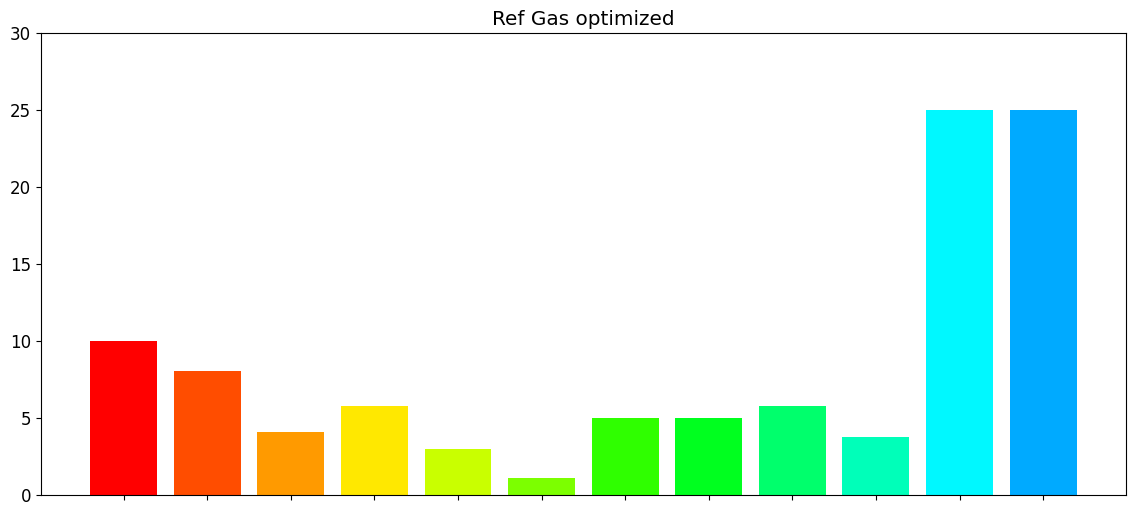

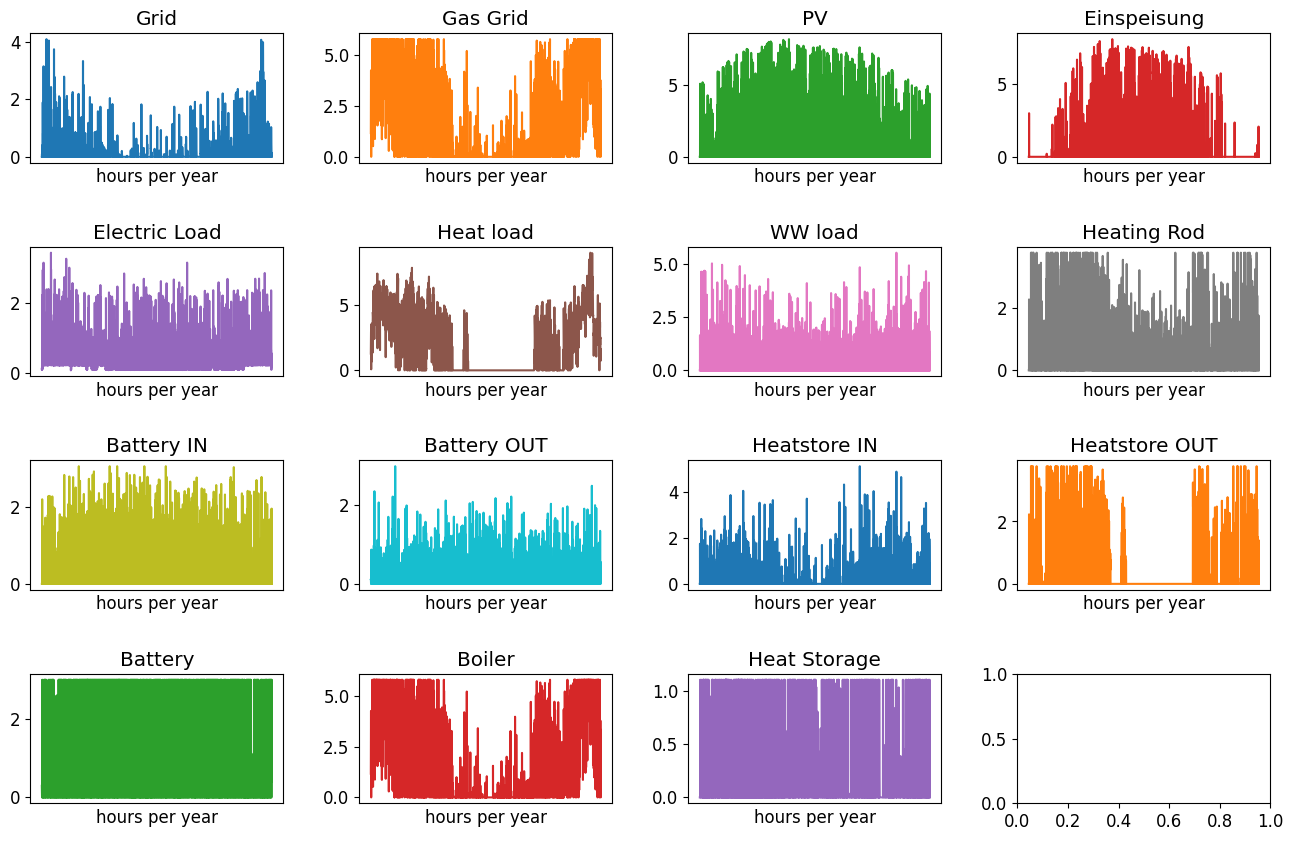

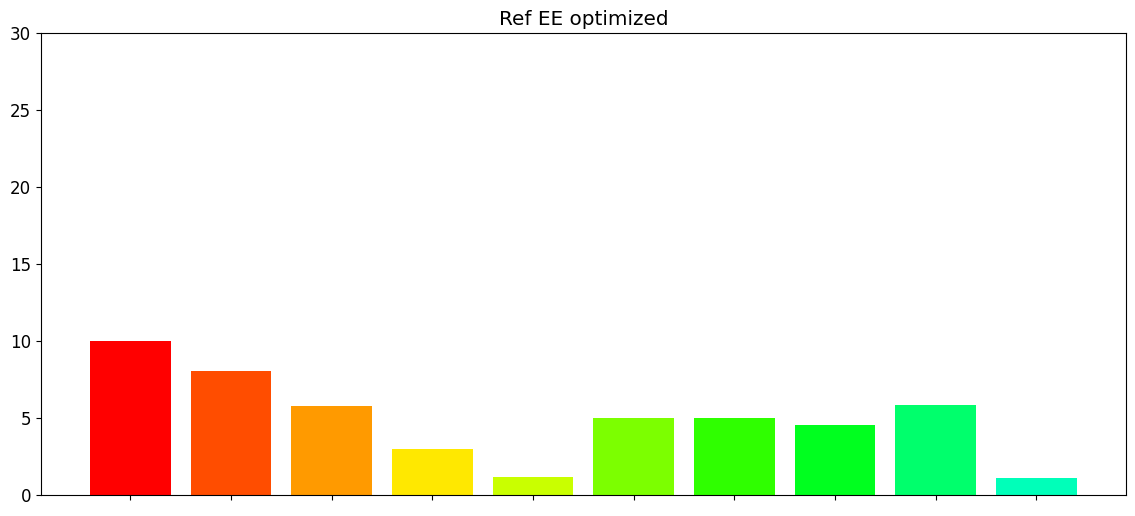

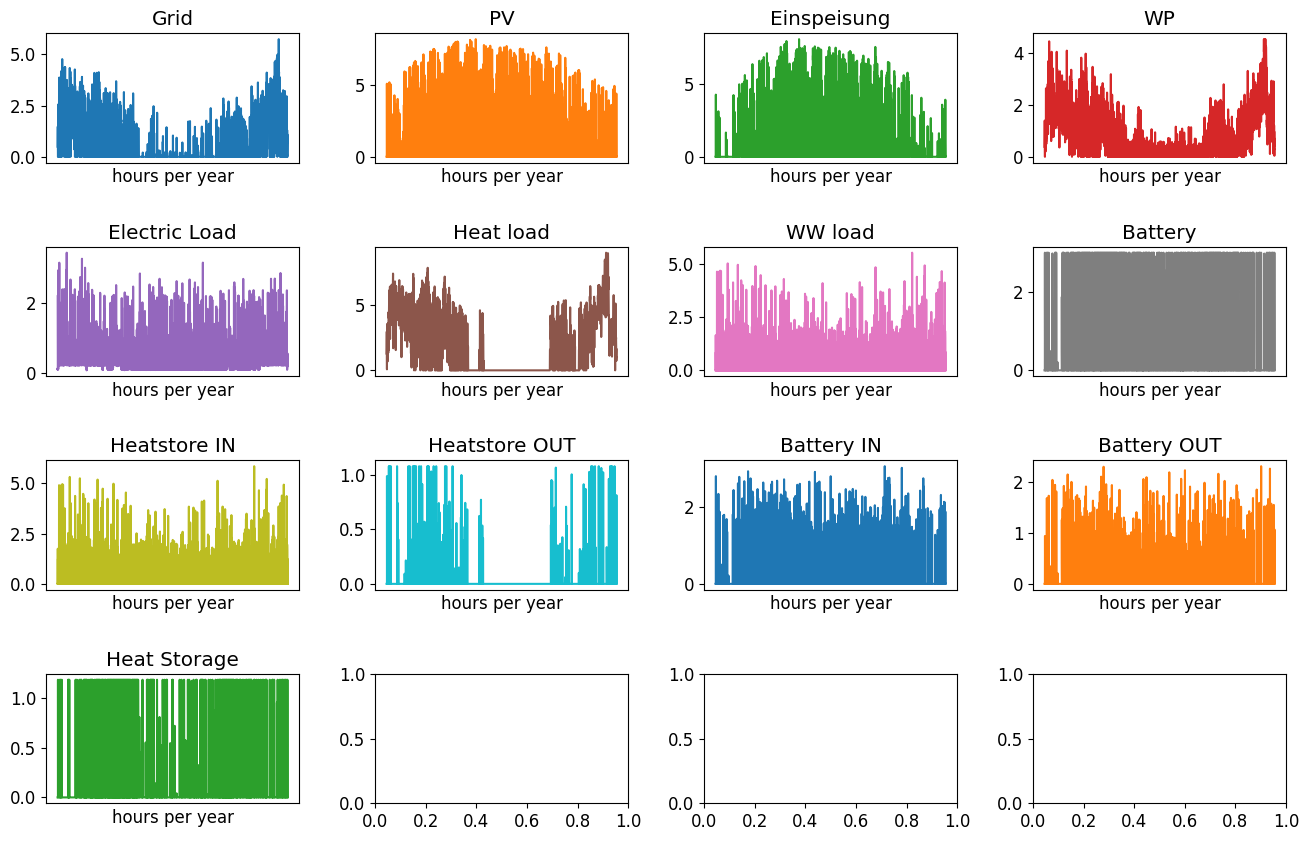

In [19]:
# setup reference networks and optimize
reference_gas = build_ref_network_gas(eload4, hload4, wwload4)
reference_ee = build_ref_network_ee(eload4, hload4, wwload4)
reference_gas.optimize(solver_name='gurobi')
reference_ee.optimize(solver_name='gurobi')
p_nom_opt_gas_boiler = reference_gas.links.p_nom_opt.gas_boiler
p_nom_opt_wp = reference_ee.links.p_nom_opt.wp
print("!----------------------------references set up------------------------------!")

ref_res_gas = result_summary_single_network(reference_gas, ref_gas=True, plots=True)
ref_res_ee = result_summary_single_network(reference_ee, ref=True, plots=True)
print("!----------------------------results summarized------------------------------!")

# Sensitivität Netzwerkverhalten
### Prequalifizierung

**Einfluss...** 
- 1) H2_Speichergröße
- 2) Leistung des Elektrolyseurs und der Brennstoffzellen
- 3) Reduzierung der CO2-Constraint (Referenz- und H2-Netzwerke) 



In [ ]:
# 1) H2_Speichergröße (s_pq1)
# define result datasets
df_s_pq1_res_gas = pd.DataFrame()
df_s_pq1_res_ee = pd.DataFrame()

# setup networks
s_pq1_gas = build_h2_network_gas_m(eload4, hload4, wwload4, init_build_year=2020)
s_pq1_gas.stores.loc['h2_storage', 'e_nom_extendable'] = False
s_pq1_gas.stores.loc['h2_storage', 'e_nom_max'] = np.inf
s_pq1_gas.links.loc['ely', 'p_nom_min'] = ely_params['p_nom']
s_pq1_gas.links.loc['fc', 'p_nom_min'] = fc_params['p_nom']

s_pq1_ee = build_h2_network_ee_m(eload4, hload4, wwload4, init_build_year=2020)
s_pq1_ee.stores.loc['h2_storage', 'e_nom_extendable'] = False
s_pq1_ee.stores.loc['h2_storage', 'e_nom_max'] = np.inf
s_pq1_ee.links.loc['ely', 'p_nom_min'] = ely_params['p_nom']
s_pq1_ee.links.loc['fc', 'p_nom_min'] = fc_params['p_nom']

print("!----------------------------networks initialized------------------------------!")

s_pq1_res_gas = {}
s_pq1_res_ee = {}
# looping over h2_storage capacity
for capacity in np.arange(h2_storage_params['e_nom_min'], h2_storage_params['e_nom_max']+501, 500):
    print('Current Capacity: ', capacity)
    s_pq1_gas.stores.loc['h2_storage', 'e_nom'] = capacity
    s_pq1_gas.optimize(solver_name='gurobi')
    s_pq1_res_gas[capacity] = result_summary_single_network(s_pq1_gas, h2_gas=True)
    df_s_pq1_res_gas = df_s_pq1_res_gas.append(result_summary_single_network(s_pq1_gas, h2_gas=True, sensitivity_variable=capacity))
    
    s_pq1_ee.stores.loc['h2_storage', 'e_nom'] = capacity
    s_pq1_ee.optimize(solver_name='gurobi')
    s_pq1_res_ee[capacity] = result_summary_single_network(s_pq1_ee, h2=True)
    df_s_pq1_res_ee = df_s_pq1_res_ee.append(result_summary_single_network(s_pq1_ee, h2=True, sensitivity_variable=capacity))

print("!----------------------------results generated------------------------------!")

print("\n\nEE Network: H2 Storage Capacity 500 kWh vs. 3000 kWh")
print("\nEE Network: 500 kWh")
plot_series_data(s_pq1_res_ee[500][0])
print("\nEE Network: 3000 kWh")
plot_series_data(s_pq1_res_ee[3000][0])

print("\n\nGas Network: H2 Storage Capacity 500 kWh vs. 3000 kWh")
print("\nGas Network: 500 kWh")
plot_series_data(s_pq1_res_gas[500][0])
print("\nGas Network: 3000 kWh")
plot_series_data(s_pq1_res_gas[3000][0])

# Sensitivitäts-Analyse
### (ausgehend von 4-Personenhaushalt und in Bezug auf Parameter der Fragestellung)

**Sensitivität 1: Kapitalkostenreduktion**
- 1a: Kostenreduktion der Wasserstoffkomponenten entlang eines definierten Learning Curve Modells
- 1b: Kostenreduktion der Wasserstoffkomponenten prozentual vom Minimum des Learning Curve Modells

**Sensitivität 2: CO2-Emissionsminimum**
- 2a: CO2-Emissionsminimum des Wasserstofferweiterten Gas-Modells
- 2b: CO2-Emissionsminimum des Wasserstofferweiterten EE-Modells

**Sensitivität 3: Kapitalkostenreduktion bei definiertem CO2-Emissionsminimum**
- 3a: Kostenreduktion der Wasserstoffkomponenten entlang eines definierten Learning Curve Modells bei definiertem CO2-Emissionsminimum
- 3b: Prozentuale Kostenreduktion der Wasserstoffkomponenten entsprechend des Kapitalwertes aus 3a, am letzten Punkt für den gilt: (Amortisationszeit der Referenz < Amortisationszeit H2) bei definiertem CO2-Emissionsmaximum.

**Sensitivität 4: Minimum der Lebensdauer**
- 4a: Minimale Lebensdauer des Wasserstoffsystems für eine wirtschaftliche Machbarkeit im Gas-Modell (bei ermitteltem CO2-Minimum und notwendiger Kapitalkostenreduktion)
- 4b: Minimale Lebensdauer des Wasserstoffsystems für eine wirtschaftliche Machbarkeit im EE-Modell (bei ermitteltem CO2-Minimum und notwendiger Kapitalkostenreduktion)



### Sensitivität 1

#### Sensitivität 1a
Ausgehend von einem Szenario für eine maximale Reduktion der Kapitalkosten von Wasserstoffsystemen soll bestimmt werden ab wann und zu welchem Investitionspreis ein kombiniertes Speicher- und Versorgungsystem mit Wasserstoff gegenüber derzeit verwendeter Energiebereitstellungssysteme in Eigenheimen kostenseitig attraktiv wird. Dem Szenario wird ein 4 Personenhaushalt mit entsprechenden Lastprofilen zugrunde gelegt.

**Kostenszenarien: Die Kapitalkosten für ein System verringern sich bis 2050 auf...**
> *Bei einem angenommenem Systempreis von 85000€ [https://www.homepowersolutions.de/produkt/] unter der Annahme, dass sich die Kosten für die Einzelkomponenten gleichmäßig auf die 4 Hauptkomponenten Elektrolyseur, Brennstoffzelle, integrierter Batteriespeicher und Wasserstoffspeicher aufteilen.
- max: ~70% der aktuellen Kosten
- std: ~46% der aktuellen Kosten
- min: ~28% der aktuellen Kosten

Durchgeführt wird eine Dimensionierung der Basiskomponenten(Gasheizung(Boiler), Wärmepumpe) für ein Eigenheim...:
-  mit PV, Batteriespeicher und Gasheizung
-  mit PV, Batteriespeicher und Wärmepumpe

</br>Die Dimensionierung der Basiskomponenten werden den jeweiligen H2-Netzwerken übergeben und für jedes Kostenszenario mit einem 5 jahres Interval eine Optimierung durchgeführt.

##### Die konkrete Frage zu dieser Sensitivitätsanalyse lautet:
Welche Kostenreduktion muss ein Wasserstoff-Heimsystem erfahren, um für die Anwendung im Eigenheim attraktiv zu werden und wann (kurzfristig < 2 Jahre, mittelfristig < 10 Jahre, langfristig > 10 Jahre) ist damit zu rechnen?
> **Notwendige Bedingung:** alle 4 Komponenten müssen eine optimierte Leistung oder Kapazität aufweisen

#### Sensitivität 1b

In [20]:
# Setup time intervall and cost data
sa_periods = multi_years
df_cost = cost_reduction_calculation(capital_cost_picea)
df_cost.drop(df_cost.tail(3).index, inplace=True)
df_cost['year'] = range(2023, 2051, 1)
df_cost.index = df_cost['year']
df_cost = df_cost[df_cost['year'].isin(sa_periods)]

df_cost

,year,max,std,min,[%]_1,[%]_2,[%]_3
year,,,,,,,
2023,2023,85000.000000,85000.000000,85000.000000,1.000000,1.000000,1.000000
2025,2025,79235.160018,71837.161639,64748.781844,0.932178,0.845143,0.761750
2027,2027,76876.759716,66820.747716,57594.657993,0.904432,0.786126,0.677584
2029,2029,70641.154426,54563.418678,41498.275747,0.831072,0.641923,0.488215
2031,2031,67257.121173,48509.570449,34309.922041,0.791260,0.570701,0.403646
2033,2033,64183.673469,43367.346939,28622.448980,0.755102,0.510204,0.336735
2035,2035,63579.328934,42936.471791,28018.104444,0.747992,0.505135,0.329625
2037,2037,63148.400964,42505.543821,27587.176474,0.742922,0.500065,0.324555
2039,2039,62717.472995,42074.615852,27156.248505,0.737853,0.494995,0.319485


In [21]:
# sensitivity scenario 1a
# scenario datasets
s1a_res_gas = {}
s1a_res_ee = {}
s1a_current_cost = pd.DataFrame(index=sa_periods, columns=['cost_bat [€/kWh]', 'cost_h2_storage [€/kWh]', 
                                                           'cost_ely [€/kW]', 'cost_fc [€/kW]'])
# setup h2 networks
s1a_gas_network = build_h2_network_gas_m(eload4, hload4, wwload4,
                                         multi_invest_h2g=False,
                                         cost_data = df_cost,
                                         cost_scenario='min')
s1a_gas_network.links.loc['gas_boiler', 'p_nom'] = p_nom_opt_gas_boiler
s1a_gas_network.links.loc['gas_boiler', 'p_nom_extendable'] = False
s1a_ee_network = build_h2_network_ee_m(eload4, hload4, wwload4,
                                       multi_invest_h2=False,
                                       cost_data = df_cost,
                                       cost_scenario='min')
s1a_ee_network.links.loc['wp', 'p_nom'] = p_nom_opt_wp
s1a_ee_network.links.loc['wp', 'p_nom_extendable'] = False
print("!----------------------------networks initialized------------------------------!")

for year in df_cost['year']:
    print("Current Capital Cost H2-System for {}: ".format(year), df_cost.loc[year, 'min'])
    s1a_gas_network.stores.loc['h2_storage', 'capital_cost'] = (df_cost.loc[year, 'min'] * specific_cap_share['h2_storage']) / h2_storage_params['e_nom_min']
    s1a_gas_network.stores.loc['battery', 'capital_cost'] = (df_cost.loc[year, 'min'] * specific_cap_share['battery']) / battery_picea_params['e_nom']
    s1a_gas_network.links.loc['ely', 'capital_cost'] = (df_cost.loc[year, 'min'] * specific_cap_share['ely']) / ely_params['p_nom']
    s1a_gas_network.links.loc['fc', 'capital_cost'] = (df_cost.loc[year, 'min'] * specific_cap_share['fc']) / fc_params['p_nom']
    s1a_gas_network.optimize(solver_name='gurobi')
    s1a_res_gas[year] = result_summary_single_network(s1a_gas_network, h2_gas=True)
    print("Gas Network interim Result for {}: \n\n".format(year), s1a_res_gas[year][1], "\n\n", s1a_res_gas[year][2])
    
    s1a_ee_network.stores.loc['h2_storage', 'capital_cost'] = (df_cost.loc[year, 'min'] * specific_cap_share['h2_storage']) / h2_storage_params['e_nom_min']
    s1a_ee_network.stores.loc['battery', 'capital_cost'] = (df_cost.loc[year, 'min'] * specific_cap_share['battery']) / battery_picea_params['e_nom']
    s1a_ee_network.links.loc['ely', 'capital_cost'] = (df_cost.loc[year, 'min'] * specific_cap_share['ely']) / ely_params['p_nom']
    s1a_ee_network.links.loc['fc', 'capital_cost'] = (df_cost.loc[year, 'min'] * specific_cap_share['fc']) / fc_params['p_nom']
    s1a_ee_network.optimize(solver_name='gurobi')
    s1a_res_ee[year] = result_summary_single_network(s1a_ee_network, h2=True)
    print("EE Network interim Result for {}: \n\n".format(year), s1a_res_ee[year][1], "\n\n", s1a_res_ee[year][2])
      
    s1a_current_cost.loc[year] = [s1a_ee_network.stores.capital_cost.battery,
                                  s1a_ee_network.stores.capital_cost.h2_storage,
                                  s1a_ee_network.links.capital_cost.ely,
                                  s1a_ee_network.links.capital_cost.fc]
    
print("!----------------------------results generated------------------------------!")

# results scenario 1
df_s1a_gas = pd.DataFrame(index=sa_periods, columns=['battery [kWh]', 'h2_storage [kWh]', 'ely [kW]', 'fc [kW]'])
df_s1a_ee = pd.DataFrame(index=sa_periods, columns=['battery [kWh]', 'h2_storage [kWh]', 'ely [kW]', 'fc [kW]'])
cols = ['H2 Gas optimized', 'H2 EE optimized']

for key, val in s1a_res_gas.items():
    df_s1a_gas.loc[key] = [val[1].loc['battery', cols[0]], val[1].loc['h2_storage', cols[0]],
                          val[1].loc['ely', cols[0]], val[1].loc['fc', cols[0]]]
    
for key, val in s1a_res_ee.items():
    df_s1a_ee.loc[key] = [val[1].loc['battery', cols[1]], val[1].loc['h2_storage', cols[1]],
                         val[1].loc['ely', cols[1]], val[1].loc['fc', cols[1]]]
    
df_s1a_gas = pd.concat([df_s1a_gas, s1a_current_cost.round(decimals=0)], axis=1)
df_s1a_ee = pd.concat([df_s1a_ee, s1a_current_cost.round(decimals=0)], axis=1)

print("!----------------------------results scenario 1:------------------------------!")
print(df_s1a_gas, "\n\n\n\n",  df_s1a_ee)
#print(s1a_res_gas, "\n\n", s1a_res_ee)

Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  min 
 Start year for H2-Components:  2023
Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  min 
 Start year for H2-Components:  2023
!----------------------------networks initialized------------------------------!
Current Capital Cost H2-System for 2023:  85000.0


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 31.43it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-ln5tfb3y.lp
Reading time = 0.78 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x32c34d71
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [9e+04, 9e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259184 rows and 48933 columns
Presolve time: 0.43s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statisti

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -8.14e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2023: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.71
gas                         5.79
battery                     0.00
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 2.66
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   4194.68
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       4546.07
PV own consumption ratio [%]            42.39
Amount Infeed [kWh/a]                 6178.75
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 2110.47
Grid gas [kWh/a]                     16231.37
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 34.52it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-z9hl1302.lp
Reading time = 0.67 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x66e8d47f
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.43s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistic

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -6.38e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2023: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                    0.00
heat_storage               5.00
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   3262.77
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3179.23
PV own consumption ratio [%]            29.64
Amount Infeed [kWh/a]                 7545.59
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 7517.90
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 28.05it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-amiazxlh.lp
Reading time = 0.79 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x3c83b7f5
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259184 rows and 48933 columns
Presolve time: 0.38s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statisti

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -6.12e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2025: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.71
gas                         5.79
battery                     0.00
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 2.66
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   4194.68
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       4546.07
PV own consumption ratio [%]            42.39
Amount Infeed [kWh/a]                 6178.75
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 2110.47
Grid gas [kWh/a]                     16231.37
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 35.93it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-85bx_rtd.lp
Reading time = 0.62 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xb53b6279
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.30s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistic

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -4.79e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2025: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                    0.00
heat_storage               5.00
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   3262.77
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3179.23
PV own consumption ratio [%]            29.64
Amount Infeed [kWh/a]                 7545.59
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 7517.90
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 27.55it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-i1jgn35y.lp
Reading time = 0.80 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x02d130ae
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259184 rows and 48933 columns
Presolve time: 0.36s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statisti

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -5.40e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2027: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.71
gas                         5.79
battery                     0.00
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 2.66
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   4194.68
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       4546.07
PV own consumption ratio [%]            42.39
Amount Infeed [kWh/a]                 6178.75
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 2110.47
Grid gas [kWh/a]                     16231.37
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 36.58it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-w00p9w78.lp
Reading time = 0.61 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x5116fdd3
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.31s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistic

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -4.23e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2027: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                    0.00
heat_storage               5.00
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   3262.77
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3179.23
PV own consumption ratio [%]            29.64
Amount Infeed [kWh/a]                 7545.59
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 7517.90
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 32.34it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-xvk372o5.lp
Reading time = 0.73 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xdcdff151
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259184 rows and 48933 columns
Presolve time: 0.34s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statisti

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -3.79e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2029: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.71
gas                         5.79
battery                     0.00
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 2.66
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   4194.68
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       4546.07
PV own consumption ratio [%]            42.39
Amount Infeed [kWh/a]                 6178.75
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 2110.47
Grid gas [kWh/a]                     16231.37
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 36.59it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-_x5z8kbv.lp
Reading time = 0.61 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x80d0a7fe
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.34s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistic

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -2.96e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2029: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                    0.00
heat_storage               5.00
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   3262.77
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3179.23
PV own consumption ratio [%]            29.64
Amount Infeed [kWh/a]                 7545.59
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 7517.90
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 32.79it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-qdbbw06e.lp
Reading time = 0.80 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xa48340fd
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 7e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259184 rows and 48933 columns
Presolve time: 0.38s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statisti

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -3.07e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2031: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.71
gas                         5.79
battery                     0.38
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 2.66
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   4137.59
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       4659.98
PV own consumption ratio [%]            43.45
Amount Infeed [kWh/a]                 6064.84
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 1965.48
Grid gas [kWh/a]                     16260.24
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 36.61it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-hitxmpf2.lp
Reading time = 0.65 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x3ccdb695
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 7e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.32s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistic

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -2.40e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2031: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                    0.00
heat_storage               5.00
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   3262.77
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3179.23
PV own consumption ratio [%]            29.64
Amount Infeed [kWh/a]                 7545.59
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 7517.90
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 29.25it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-nhnhs18_.lp
Reading time = 0.79 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x09275f39
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 6e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259184 rows and 48933 columns
Presolve time: 0.42s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statisti

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -2.51e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2033: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.71
gas                         5.79
battery                     1.85
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 2.66
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   3943.88
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5050.72
PV own consumption ratio [%]            47.09
Amount Infeed [kWh/a]                 5674.10
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 1473.26
Grid gas [kWh/a]                     16358.83
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 36.59it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-qr94_hlf.lp
Reading time = 0.61 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xcae10f12
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 6e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.31s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistic

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.95e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2033: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                    0.94
heat_storage               5.00
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   3138.17
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3470.37
PV own consumption ratio [%]            32.36
Amount Infeed [kWh/a]                 7254.45
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 7230.82
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 32.81it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-zie0zjr4.lp
Reading time = 0.77 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x7d6a4dd3
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259184 rows and 48933 columns
Presolve time: 0.34s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statisti

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -2.45e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2035: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.71
gas                         5.79
battery                     1.93
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 2.66
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   3935.24
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5067.79
PV own consumption ratio [%]            47.25
Amount Infeed [kWh/a]                 5657.03
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 1451.27
Grid gas [kWh/a]                     16363.32
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 35.40it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-fsvivsq9.lp
Reading time = 0.66 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x45d8b8e4
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.31s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistic

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.91e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2035: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                    1.18
heat_storage               5.00
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   3108.95
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3539.02
PV own consumption ratio [%]            33.00
Amount Infeed [kWh/a]                 7185.80
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 7163.48
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 29.17it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-zw75fd8c.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x5ae0226f
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259184 rows and 48933 columns
Presolve time: 0.41s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statisti

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -2.40e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2037: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.71
gas                         5.79
battery                     1.97
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 2.66
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   3930.34
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5077.39
PV own consumption ratio [%]            47.34
Amount Infeed [kWh/a]                 5647.43
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 1438.77
Grid gas [kWh/a]                     16365.89
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 36.59it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-sohtnfsk.lp
Reading time = 0.64 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x35f0eec9
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistic

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.87e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2037: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                    1.37
heat_storage               5.00
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   3085.19
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3594.67
PV own consumption ratio [%]            33.52
Amount Infeed [kWh/a]                 7130.15
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 7108.74
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 33.86it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-m_pbru6h.lp
Reading time = 0.70 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xba1db7a9
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259184 rows and 48933 columns
Presolve time: 0.35s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statisti

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -2.36e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2039: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.71
gas                         5.79
battery                     2.02
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 2.66
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   3924.73
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5088.25
PV own consumption ratio [%]            47.44
Amount Infeed [kWh/a]                 5636.57
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 1424.48
Grid gas [kWh/a]                     16368.85
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 26.97it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-alu0f3z4.lp
Reading time = 0.73 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xab631332
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.35s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistic

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.84e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2039: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                    1.44
heat_storage               5.00
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   3077.50
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3612.63
PV own consumption ratio [%]            33.68
Amount Infeed [kWh/a]                 7112.19
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 7091.02
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 32.66it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-q2tquie6.lp
Reading time = 0.70 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xd2c98bdd
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259184 rows and 48933 columns
Presolve time: 0.34s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statisti

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -2.32e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2041: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.71
gas                         5.79
battery                     2.04
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 2.66
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   3921.85
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5093.86
PV own consumption ratio [%]            47.50
Amount Infeed [kWh/a]                 5630.96
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 1417.15
Grid gas [kWh/a]                     16370.33
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 38.57it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-_0ymamut.lp
Reading time = 0.62 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xca595702
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.31s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistic

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.81e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2041: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                    1.56
heat_storage               5.00
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   3063.64
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3644.68
PV own consumption ratio [%]            33.98
Amount Infeed [kWh/a]                 7080.14
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 7059.08
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 31.59it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-2qm1k_eq.lp
Reading time = 0.78 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x214b3e6a
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259184 rows and 48933 columns
Presolve time: 0.34s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statisti

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -2.28e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2043: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.71
gas                         5.79
battery                     2.14
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 2.66
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   3911.54
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5114.10
PV own consumption ratio [%]            47.68
Amount Infeed [kWh/a]                 5610.72
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 1391.03
Grid gas [kWh/a]                     16375.41
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 36.59it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-ine_c77l.lp
Reading time = 0.61 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x85dd5b55
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.30s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistic

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.77e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2043: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                    1.61
heat_storage               5.00
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   3057.78
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3658.11
PV own consumption ratio [%]            34.11
Amount Infeed [kWh/a]                 7066.71
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 7045.58
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

In [ ]:
# sensitivity scenario 1b

# scenario datasets
s1b_cap_lst = start_capital_cost(df_cost['min'].min())
df_s1b_res_gas = pd.DataFrame()
df_s1b_res_ee = pd.DataFrame()
s1b_res_sum_gas = {}
s1b_res_sum_ee = {}

# setup networks
s1b_gas_network = build_h2_network_gas_m(eload4, hload4, wwload4, multi_invest_h2g=False)
s1b_gas_network.links.loc['gas_boiler', 'p_nom'] = p_nom_opt_gas_boiler
s1b_gas_network.links.loc['gas_boiler', 'p_nom_extendable'] = False

s1b_ee_network = build_h2_network_ee_m(eload4, hload4, wwload4, multi_invest_h2=False)
s1b_ee_network.links.loc['wp', 'p_nom'] = p_nom_opt_wp
s1b_ee_network.links.loc['wp', 'p_nom_extendable'] = False
print("!----------------------------networks initialized------------------------------!")

for i in np.arange(1, 0, -0.9):
    i_id = np.round(i*100, 0)
    print("Current Capital Cost H2-System: ", np.round(sum(s1b_cap_lst) * i, 0))
    
    s1b_gas_network.stores.loc['h2_storage', 'capital_cost'] = s1b_cap_lst[0] / h2_storage_params['e_nom_min'] * i
    s1b_gas_network.links.loc['ely', 'capital_cost'] = s1b_cap_lst[1] / ely_params['p_nom'] * i
    s1b_gas_network.links.loc['fc', 'capital_cost'] = s1b_cap_lst[2] / fc_params['p_nom'] * i
    s1b_gas_network.stores.loc['battery', 'capital_cost'] = s1b_cap_lst[3] / battery_picea_params['e_nom'] * i
    s1b_gas_network.optimize(solver_name='gurobi')
    df_s1b_res_gas = df_s1b_res_gas.append(result_summary_single_network(s1b_gas_network, h2_gas=True, sensitivity_variable=i_id))
    s1b_res_sum_gas[i_id] = result_summary_single_network(s1b_gas_network, h2_gas=True)
    print("Gas Network interim Result for {} %: \n\n".format(i_id), s1b_res_sum_gas[i_id][1], "\n\n", s1b_res_sum_gas[i_id][2])
    
    s1b_ee_network.stores.loc['h2_storage', 'capital_cost'] = s1b_cap_lst[0] / h2_storage_params['e_nom_min'] * i
    s1b_ee_network.links.loc['ely', 'capital_cost'] = s1b_cap_lst[1] / ely_params['p_nom'] * i
    s1b_ee_network.links.loc['fc', 'capital_cost'] = s1b_cap_lst[2] / fc_params['p_nom'] * i
    s1b_ee_network.stores.loc['battery', 'capital_cost'] = s1b_cap_lst[3] / battery_picea_params['e_nom'] * i
    s1b_ee_network.optimize(solver_name='gurobi')
    df_s1b_res_ee = df_s1b_res_ee.append(result_summary_single_network(s1b_ee_network, h2=True, sensitivity_variable=i_id))
    s1b_res_sum_ee[i_id] = result_summary_single_network(s1b_ee_network, h2=True)
    print("EE Network interim Result for {} %: \n\n".format(i_id), s1b_res_sum_ee[i_id][1], "\n\n", s1b_res_sum_ee[i_id][2])
    

print("!----------------------------results generated------------------------------!")

# print(s1b_res_sum_ee, "\n\n\n\n", s1b_res_sum_gas)
print(df_s1b_res_ee, "\n\n\n\n", df_s1b_res_gas)

### Sensitivität 2

#### Sensitivität 2a
#### Sensitivität 2b

In [41]:
# sensitivity scenario 2a - CO2-minimum H2-Gas-model
# DataFrame for sensitivity results
df_s2a_res_gas = pd.DataFrame()

# Setup H2-Gas Network with minimum design properties for hydrogen Network but with extendable components
s2a_gas_network = build_h2_network_gas_m(eload4, hload4, wwload4)
s2a_gas_network.links.loc['gas_boiler', 'p_nom'] = p_nom_opt_gas_boiler # set gas_boiler power from reference network 
s2a_gas_network.links.loc['gas_boiler', 'p_nom_extendable'] = False # set gas_boiler not extendable
print("!----------------------------network initialized------------------------------!")

# optimize for base CO2-value
s2a_gas_network.optimize(solver_name='gurobi')
s2a_base_res_gas = result_summary_single_network(s2a_gas_network, h2_gas=True)
s2a_baseCO2_gas = s2a_base_res_gas[2].loc['CO2-Emission [kg/a]', 'analytic values']
print("!----------------------------base CO2 calculated------------------------------!")

s2a_res_gas_sum = {}
# lowering CO2-Emissions for each run and append results
for co2_lim in np.arange(1, 0.69, -0.05):
    co2_id = np.round(co2_lim*100, 0)
    print('Current CO2: {}%:'.format(co2_id), "\nCurrent CO2 Value [kg/a]: ", co2_lim * s2a_baseCO2_gas)
    s2a_gas_network.global_constraints.loc['co2-limit', 'constant'] = co2_lim * s2a_baseCO2_gas
    s2a_gas_network.optimize(solver_name='gurobi')
    df_s2a_res_gas = df_s2a_res_gas.append(result_summary_single_network(s2a_gas_network, h2_gas=True, sensitivity_variable=co2_id))
    s2a_res_gas_sum[co2_id] = result_summary_single_network(s2a_gas_network, h2_gas=True)
    print("Gas Network interim Result for {} %: \n\n".format(co2_id), s2a_res_gas_sum[co2_id][1], "\n\n", s2a_res_gas_sum[co2_id][2])
print("!----------------------------results scenario 2a:------------------------------!")
df_s2a_res_gas

Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023
!----------------------------network initialized------------------------------!


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 25.28it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-_pg_lpwl.lp
Reading time = 0.92 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x8f8c3d84
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [8e+04, 8e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259184 rows and 48933 columns
Presolve time: 0.45s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statisti

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -7.46e+04
Solver model: available
Solver message: 2



!----------------------------base CO2 calculated------------------------------!
Current CO2: 100.0%: 
Current CO2 Value [kg/a]:  4194.68


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 32.46it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-l7h04c__.lp
Reading time = 0.83 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x2e0cf450
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [8e+04, 8e+04]
  RHS range        [4e-03, 4e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.49s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -7.46e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 100.0 %: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.71
gas                         5.79
battery                     0.00
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 2.66
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   4194.68
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       4546.07
PV own consumption ratio [%]            42.39
Amount Infeed [kWh/a]                 6178.75
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 2110.47
Grid gas [kWh/a]                     16231.37
Ratio electr

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 27.71it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-me0mzyw4.lp
Reading time = 0.85 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x57d5dcbe
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [8e+04, 8e+04]
  RHS range        [4e-03, 4e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.46s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -7.44e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 95.0 %: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        3.99
gas                         5.79
battery                     1.12
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 3.46
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   3984.95
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5297.27
PV own consumption ratio [%]            49.39
Amount Infeed [kWh/a]                 5427.55
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 1714.72
Grid gas [kWh/a]                     16043.35
Ratio electri

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 29.31it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-mqvu2gko.lp
Reading time = 0.87 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x526a5f5f
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [8e+04, 8e+04]
  RHS range        [4e-03, 4e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.40s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -7.41e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 90.0 %: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.03
gas                         5.79
battery                     3.05
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 3.70
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   3775.21
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5677.11
PV own consumption ratio [%]            52.93
Amount Infeed [kWh/a]                 5047.71
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 1177.06
Grid gas [kWh/a]                     16160.24
Ratio electri

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 23.82it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-v0tvegk1.lp
Reading time = 0.75 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xc87f995a
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [8e+04, 8e+04]
  RHS range        [4e-03, 4e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.40s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.05s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -7.32e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 85.0 %: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.42
gas                         5.79
battery                     7.28
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.12
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   3565.48
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6051.05
PV own consumption ratio [%]            56.42
Amount Infeed [kWh/a]                 4673.77
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  700.46
Grid gas [kWh/a]                     16145.94
Ratio electri

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 30.14it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-iqdxpefh.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xd1178e92
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [8e+04, 8e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.43s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -6.92e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 80.0 %: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.70
gas                         5.79
battery                    20.00
heat_storage               12.93
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.41
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   3355.74
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6901.36
PV own consumption ratio [%]            64.35
Amount Infeed [kWh/a]                 3823.46
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  437.76
Grid gas [kWh/a]                     15672.06
Ratio electri

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 31.32it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-3fq_q9lw.lp
Reading time = 0.84 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x57b9b67c
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [8e+04, 8e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.45s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -3.33e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 75.0 %: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.73
grid                        4.44
gas                         5.79
battery                    20.00
heat_storage               17.64
h2_storage                650.70
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.35
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3146.01
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       8016.20
PV own consumption ratio [%]            74.74
Amount Infeed [kWh/a]                 2708.62
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  134.79
Grid gas [kWh/a]                     15284.70
Ratio electri

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 28.05it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-jptj0h_p.lp
Reading time = 0.94 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xf731e482
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [8e+04, 8e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.45s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 1.97e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 70.0 %: 

                 H2 Gas optimized
pv                         10.00
infeed                      6.99
grid                        3.22
gas                         5.79
battery                    20.00
heat_storage               15.37
h2_storage               1776.85
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.09
fc                          0.89 

                               analytic values
CO2-Emission [kg/a]                   2936.28
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9584.18
PV own consumption ratio [%]            89.36
Amount Infeed [kWh/a]                 1140.64
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   85.27
Grid gas [kWh/a]                     14352.83
Ratio electri

,CO2-Emission [kg/a],PV generated [kWh/a],PV used [kWh/a],PV own consumption ratio [%],Amount Infeed [kWh/a],Load Total [kWh/a],Grid electric [kWh/a],Grid gas [kWh/a],Ratio electric [%],Ratio gas [%],...,H2 stored [kWh/a],converted to H2 [kWh/a],H2 used [kWh/a],Heat from H2 [kWh/a],Self Sufficiency [%],CAPEX [€],OPEX [€/a],Revenue Infeed [€/a],Revenue Savings [€/a],Payback Period [a]
100.0,4194.68,10724.82,4546.07,42.39,6178.75,23901.99,2110.47,16231.37,11.51,88.49,...,-0.00,0.00,0.00,-0.00,23.26,19420.20,3408.74,-438.69,-1818.43,38.81
95.0,3984.95,10724.82,5297.27,49.39,5427.55,23901.99,1714.72,16043.35,9.66,90.34,...,-0.00,0.00,0.00,-0.00,25.70,19747.09,3220.74,-385.36,-2118.91,33.61
90.0,3775.21,10724.82,5677.11,52.93,5047.71,23901.99,1177.06,16160.24,6.79,93.21,...,-0.00,0.00,0.00,-0.00,27.47,20257.09,3024.14,-358.39,-2270.84,30.71
85.0,3565.48,10724.82,6051.05,56.42,4673.77,23901.99,700.46,16145.94,4.16,95.84,...,-0.00,0.00,0.00,-0.00,29.52,21371.22,2831.24,-331.84,-2420.42,28.34
80.0,3355.74,10724.82,6901.36,64.35,3823.46,23901.99,437.76,15672.06,2.72,97.28,...,-0.00,0.00,0.00,-0.00,32.60,25446.42,2651.29,-271.47,-2760.55,25.88
75.0,3146.01,10724.82,8016.20,74.74,2708.62,23901.99,134.79,15284.70,0.87,99.13,...,831.35,1187.65,806.64,479.52,35.49,61472.56,2468.90,-192.31,-3206.48,32.61
70.0,2936.28,10724.82,9584.18,89.36,1140.64,23901.99,85.27,14352.83,0.59,99.41,...,2126.59,3037.98,2059.93,1225.58,39.59,114499.95,2301.85,-80.99,-3833.67,41.01


In [36]:
# sensitivity scenario 2b - CO2-minimum H2-EE-model
# DataFrame for sensitivity results
df_s2b_res_ee = pd.DataFrame()

# Setup H2-EE Network with minimum design properties for hydrogen Network but with extendable components
s2b_ee_network = build_h2_network_ee_m(eload4, hload4, wwload4)
s2b_ee_network.links.loc['wp', 'p_nom'] = p_nom_opt_wp # set heat-pump(wp) power from reference network 
s2b_ee_network.links.loc['wp', 'p_nom_extendable'] = False # set heat-pump(wp) not extendable
print("!----------------------------network initialized------------------------------!")

# optimize for base CO2-value
s2b_ee_network.optimize(solver_name='gurobi')
s2b_base_res_ee = result_summary_single_network(s2b_ee_network, h2=True)
s2b_baseCO2_ee = s2b_base_res_ee[2].loc['CO2-Emission [kg/a]', 'analytic values']
print("!----------------------------base CO2 calculated------------------------------!")

s2b_res_ee_sum = {}
# lowering CO2-Emissions for each run and append results 
for co2_lim in np.arange(0.8, 0.49, -0.05):
    co2_id = np.round(co2_lim*100, 0)
    print('Current CO2: {}%:'.format(co2_id), "\nCurrent CO2 Value [kg/a]: ", co2_lim * s2b_baseCO2_ee)
    s2b_ee_network.global_constraints.loc['co2-limit', 'constant'] = co2_lim * s2b_baseCO2_ee
    s2b_ee_network.optimize(solver_name='gurobi')
    df_s2b_res_ee = df_s2b_res_ee.append(result_summary_single_network(s2b_ee_network, h2=True, sensitivity_variable=co2_id))
    s2b_res_ee_sum[co2_id] = result_summary_single_network(s2b_ee_network, h2=True)
    print("Gas Network interim Result for {} %: \n\n".format(co2_id), s2b_res_ee_sum[co2_id][1], "\n\n", s2b_res_ee_sum[co2_id][2])
    
print("!----------------------------results scenario 2b:------------------------------!")
df_s2b_res_ee

Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023
!----------------------------network initialized------------------------------!


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 25.28it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-zsy9asa5.lp
Reading time = 0.65 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xcb9b839d
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.45s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistic

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -5.85e+04
Solver model: available
Solver message: 2



!----------------------------base CO2 calculated------------------------------!
Current CO2: 80.0%: 
Current CO2 Value [kg/a]:  2610.2160000000003


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 30.79it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-qxqsnlbi.lp
Reading time = 0.71 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xb1c0217d
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.41s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -5.69e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 80.0 %: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                    8.12
heat_storage               5.00
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   2610.22
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       4681.34
PV own consumption ratio [%]            43.65
Amount Infeed [kWh/a]                 6043.48
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 6014.32
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
B

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 35.99it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-1plbuyeo.lp
Reading time = 0.62 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x453d7d9a
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.35s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -5.59e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 75.0 %: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                   12.44
heat_storage               5.00
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   2447.08
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5053.84
PV own consumption ratio [%]            47.12
Amount Infeed [kWh/a]                 5670.98
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 5638.43
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
B

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 32.32it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-yf0tiiv4.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xf1fd2a8e
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.35s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.

  95  -5.34964548e+04 -5.34965150e+04  1.40e-05 3.59e-11  2.82e-07    19s
  96  -5.34964915e+04 -5.34965108e+04  3.94e-06 2.24e-10  9.02e-08    19s
  97  -5.34965025e+04 -5.34965082e+04  1.04e-06 1.30e-10  2.63e-08    20s
  98  -5.34965056e+04 -5.34965072e+04  2.50e-07 7.28e-11  7.28e-09    20s
  99  -5.34965064e+04 -5.34965068e+04  7.36e-08 2.25e-11  2.01e-09    20s
 100  -5.34965067e+04 -5.34965067e+04  8.82e-10 2.23e-10  8.78e-11    20s

Barrier solved model in 100 iterations and 20.08 seconds (4.18 work units)
Optimal objective -5.34965067e+04

Crossover log...

   40800 DPushes remaining with DInf 0.0000000e+00                20s
       0 DPushes remaining with DInf 0.0000000e+00                20s

    2174 PPushes remaining with PInf 0.0000000e+00                20s
       0 PPushes remaining with PInf 0.0000000e+00                20s

  Push phase complete: Pinf 0.0000000e+00, Dinf 1.8305014e-11     20s


Solved with barrier
Iteration    Objective       Primal Inf.    Dual Inf.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -5.35e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 70.0 %: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                   20.00
heat_storage              10.85
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   2283.94
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5452.87
PV own consumption ratio [%]            50.84
Amount Infeed [kWh/a]                 5271.95
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 5262.53
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
B

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 28.30it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-mb_37jlc.lp
Reading time = 0.66 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xc2ca0b4e
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -3.42e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 65.0 %: 

                 H2 EE optimized
pv                        10.00
infeed                     7.93
grid                       5.66
battery                   20.00
heat_storage              31.64
h2_storage               397.84
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.16
fc                         0.11 

                               analytic values
CO2-Emission [kg/a]                   2120.80
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6268.40
PV own consumption ratio [%]            58.45
Amount Infeed [kWh/a]                 4456.42
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4886.64
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
B

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 26.30it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-w248ag75.lp
Reading time = 0.73 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xed1f67c5
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.37s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.30e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 60.0 %: 

                 H2 EE optimized
pv                        10.00
infeed                     7.72
grid                       5.56
battery                   20.00
heat_storage              28.81
h2_storage               891.07
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.36
fc                         0.25 

                               analytic values
CO2-Emission [kg/a]                   1957.66
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7079.47
PV own consumption ratio [%]            66.01
Amount Infeed [kWh/a]                 3645.35
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4510.74
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
B

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 31.08it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-zltkk38l.lp
Reading time = 0.62 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x03a1db8f
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.35s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 9.30e+03
Solver model: available
Solver message: 2



Gas Network interim Result for 55.0 %: 

                 H2 EE optimized
pv                        10.00
infeed                     7.50
grid                       5.46
battery                   20.00
heat_storage              27.34
h2_storage              1400.83
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.59
fc                         0.39 

                               analytic values
CO2-Emission [kg/a]                   1794.52
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7922.67
PV own consumption ratio [%]            73.87
Amount Infeed [kWh/a]                 2802.15
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4134.85
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
B

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 32.72it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-tfw_s1ak.lp
Reading time = 0.64 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x84fcdc60
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.35s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 3.28e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 50.0 %: 

                 H2 EE optimized
pv                        10.00
infeed                     7.21
grid                       5.35
battery                   20.00
heat_storage              24.30
h2_storage              1922.81
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.87
fc                         0.54 

                               analytic values
CO2-Emission [kg/a]                   1631.38
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       8746.75
PV own consumption ratio [%]            81.56
Amount Infeed [kWh/a]                 1978.07
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3758.95
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
B

,CO2-Emission [kg/a],PV generated [kWh/a],PV used [kWh/a],PV own consumption ratio [%],Amount Infeed [kWh/a],Load Total [kWh/a],Grid electric [kWh/a],Grid gas [kWh/a],Ratio electric [%],Ratio gas [%],...,H2 stored [kWh/a],converted to H2 [kWh/a],H2 used [kWh/a],Heat from H2 [kWh/a],Self Sufficiency [%],CAPEX [€],OPEX [€/a],Revenue Infeed [€/a],Revenue Savings [€/a],Payback Period [a]
80.0,2610.22,10724.82,4681.34,43.65,6043.48,23901.99,6014.32,0.0,100.0,0.0,...,-0.00,0.00,0.00,-0.00,74.84,26956.06,2405.73,-429.09,-1872.54,32.62
75.0,2447.08,10724.82,5053.84,47.12,5670.98,23901.99,5638.43,0.0,100.0,0.0,...,-0.00,0.00,0.00,-0.00,76.41,28072.77,2255.37,-402.64,-2021.54,30.19
70.0,2283.94,10724.82,5452.87,50.84,5271.95,23901.99,5262.53,0.0,100.0,0.0,...,-0.00,0.00,0.00,-0.00,77.98,30598.26,2105.01,-374.31,-2181.15,28.45
65.0,2120.80,10724.82,6268.40,58.45,4456.42,23901.99,4886.64,0.0,100.0,0.0,...,462.83,661.18,445.39,265.85,79.56,49979.67,1954.65,-316.41,-2507.36,31.54
60.0,1957.66,10724.82,7079.47,66.01,3645.35,23901.99,4510.74,0.0,100.0,0.0,...,1033.80,1476.86,994.69,593.78,81.13,71302.98,1804.30,-258.82,-2831.79,34.75
55.0,1794.52,10724.82,7922.67,73.87,2802.15,23901.99,4134.85,0.0,100.0,0.0,...,1603.20,2290.29,1541.32,920.45,82.70,93667.26,1653.94,-198.95,-3169.07,37.63
50.0,1631.38,10724.82,8746.75,81.56,1978.07,23901.99,3758.95,0.0,100.0,0.0,...,2177.39,3110.55,2091.81,1249.65,84.27,117302.47,1503.58,-140.44,-3498.70,40.50


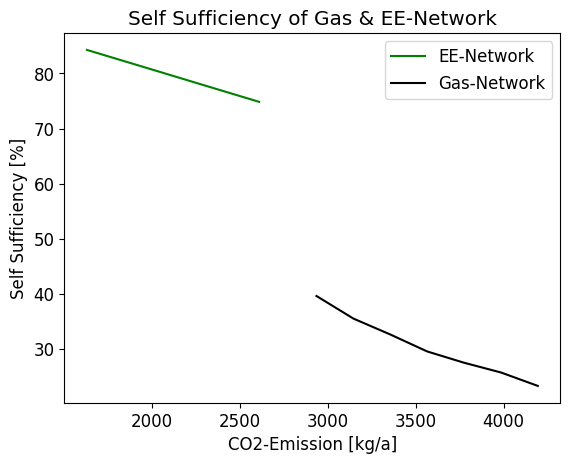

In [100]:
ax = plt.gca()
df_s2b_res_ee.plot(kind='line', x='CO2-Emission [kg/a]', y='Self Sufficiency [%]', color='green', ax=ax)
df_s2a_res_gas.plot(kind='line', x='CO2-Emission [kg/a]', y='Self Sufficiency [%]', color='black', ax=ax)
ax.set(xlabel='CO2-Emission [kg/a]', ylabel='Self Sufficiency [%]', title='Self Sufficiency of Gas & EE-Network')
ax.legend(["EE-Network", "Gas-Network"])
plt.show()

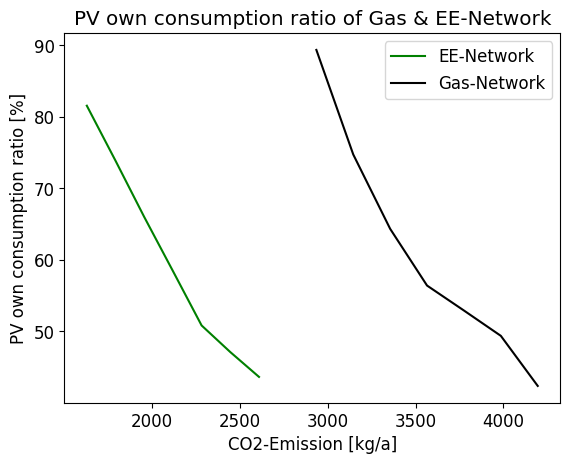

In [101]:
ax1 = plt.gca()
df_s2b_res_ee.plot(kind='line', x='CO2-Emission [kg/a]', y='PV own consumption ratio [%]', color='green', ax=ax1)
df_s2a_res_gas.plot(kind='line', x='CO2-Emission [kg/a]', y='PV own consumption ratio [%]', color='black', ax=ax1)
ax1.set(xlabel='CO2-Emission [kg/a]', ylabel='PV own consumption ratio [%]', title='PV own consumption ratio of Gas & EE-Network')
ax1.legend(["EE-Network", "Gas-Network"])
plt.show()

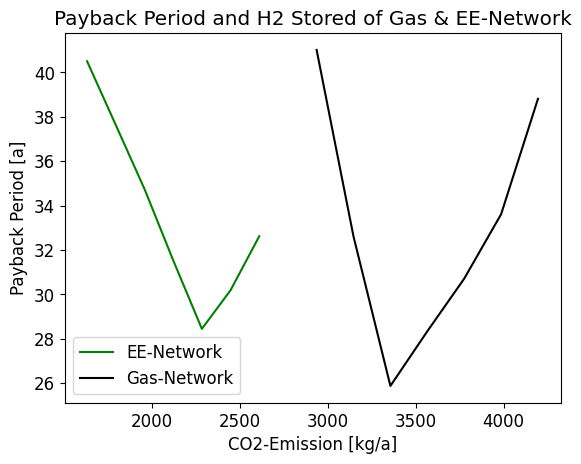

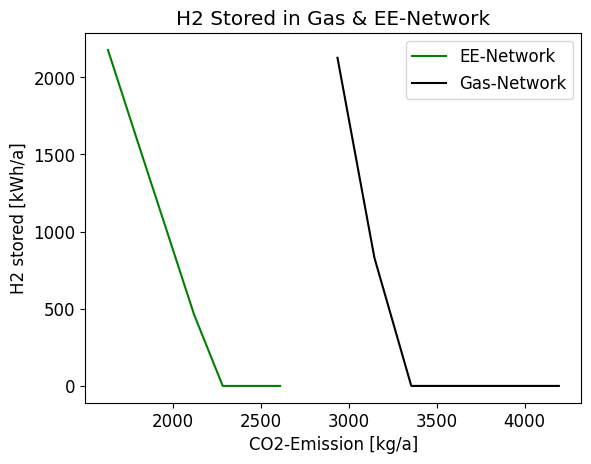

In [102]:
ax2 = plt.gca()
df_s2b_res_ee.plot(kind='line', x='CO2-Emission [kg/a]', y='Payback Period [a]', color='green', ax=ax2)
df_s2a_res_gas.plot(kind='line', x='CO2-Emission [kg/a]', y='Payback Period [a]', color='black', ax=ax2)
ax2.set(xlabel='CO2-Emission [kg/a]', ylabel='Payback Period [a]', title='Payback Period and H2 Stored of Gas & EE-Network')
ax2.legend(["EE-Network", "Gas-Network"])
plt.show()


ax_h2 = plt.gca()
df_s2b_res_ee.plot(kind='line', x='CO2-Emission [kg/a]', y='H2 stored [kWh/a]', color='green', ax=ax_h2)
df_s2a_res_gas.plot(kind='line', x='CO2-Emission [kg/a]', y='H2 stored [kWh/a]', color='black', ax=ax_h2)
ax_h2.set(xlabel='CO2-Emission [kg/a]', ylabel='H2 stored [kWh/a]', title='H2 Stored in Gas & EE-Network')
ax_h2.legend(["EE-Network", "Gas-Network"])

plt.show()

### Sensitivität 3
#### Sensitivität 3a
#### Sensitivität 3b

In [24]:
# define CO2-limit
co2_lim_gas = np.ceil(df_s2a_res_gas['CO2-Emission [kg/a]'].min() * 1.05)
co2_lim_ee = np.ceil(df_s2b_res_ee['CO2-Emission [kg/a]'].min() * 1.05) 
co2_ref_gas = np.ceil(ref_res_gas[2].loc['CO2-Emission [kg/a]', 'analytic values'])
co2_ref_ee = np.ceil(ref_res_ee[2].loc['CO2-Emission [kg/a]', 'analytic values'])

# set cost scenario for s3
s3_cost_scenario = 'std'

print("\nCO2-Limit EE: ", co2_lim_ee, "\nCO2-Limit Gas: ", co2_lim_gas)
print("\nCO2-Emissions Reference EE: ", co2_ref_ee, "\nCO2-Emissions Reference Gas: ", co2_ref_gas)


CO2-Limit EE:  1542.0 
CO2-Limit Gas:  3084.0

CO2-Emissions Reference EE:  2984.0 
CO2-Emissions Reference Gas:  3847.0


In [25]:
# sensitivity scenario 3a

# scenario datasets
s3a_res_gas = {}
s3a_res_ee = {}
s3a_current_cost = pd.DataFrame(index=sa_periods, columns=['cost_bat [€/kWh]', 'cost_h2_storage [€/kWh]', 
                                                           'cost_ely [€/kW]', 'cost_fc [€/kW]'])
# setup h2 networks
s3a_gas_network = build_h2_network_gas_m(eload4, hload4, wwload4, multi_invest_h2g=False)
s3a_gas_network.links.loc['gas_boiler', 'p_nom'] = p_nom_opt_gas_boiler
s3a_gas_network.links.loc['gas_boiler', 'p_nom_extendable'] = False
s3a_gas_network.global_constraints.loc['co2-limit', 'constant'] = co2_lim_gas
s3a_ee_network = build_h2_network_ee_m(eload4, hload4, wwload4, multi_invest_h2=False)
s3a_ee_network.links.loc['wp', 'p_nom'] = p_nom_opt_wp
s3a_ee_network.links.loc['wp', 'p_nom_extendable'] = False
s3a_ee_network.global_constraints.loc['co2-limit', 'constant'] = co2_lim_ee
print("!----------------------------networks initialized------------------------------!")

for year in sa_periods:
    print("Current Capital Cost H2-System for {}: ".format(year), df_cost.loc[year, s3_cost_scenario])
    s3a_gas_network.stores.loc['h2_storage', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenario] * specific_cap_share['h2_storage']) / h2_storage_params['e_nom_min']
    s3a_gas_network.stores.loc['battery', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenario] * specific_cap_share['battery']) / battery_picea_params['e_nom']
    s3a_gas_network.links.loc['ely', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenario] * specific_cap_share['ely']) / ely_params['p_nom']
    s3a_gas_network.links.loc['fc', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenario] * specific_cap_share['fc']) / fc_params['p_nom']
    s3a_gas_network.optimize(solver_name='gurobi')
    s3a_res_gas[year] = result_summary_single_network(s3a_gas_network, h2_gas=True)
    print("Gas Network interim Result for {}: \n\n".format(year), s3a_res_gas[year][1], "\n\n", s3a_res_gas[year][2])
    
    s3a_ee_network.stores.loc['h2_storage', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenario] * specific_cap_share['h2_storage']) / h2_storage_params['e_nom_min']
    s3a_ee_network.stores.loc['battery', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenario] * specific_cap_share['battery']) / battery_picea_params['e_nom']
    s3a_ee_network.links.loc['ely', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenario] * specific_cap_share['ely']) / ely_params['p_nom']
    s3a_ee_network.links.loc['fc', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenario] * specific_cap_share['fc']) / fc_params['p_nom']
    s3a_ee_network.optimize(solver_name='gurobi')
    s3a_res_ee[year] = result_summary_single_network(s3a_ee_network, h2=True)
    print("EE Network interim Result for {}: \n\n".format(year), s3a_res_ee[year][1], "\n\n", s3a_res_ee[year][2])
      
    s3a_current_cost.loc[year] = [s3a_ee_network.stores.capital_cost.battery,
                                  s3a_ee_network.stores.capital_cost.h2_storage,
                                  s3a_ee_network.links.capital_cost.ely,
                                  s3a_ee_network.links.capital_cost.fc]   
print("!----------------------------results generated------------------------------!")


# results scenario 3a
df_s3a_gas = pd.DataFrame(index=sa_periods, columns=['battery [kWh]', 'h2_storage [kWh]', 'ely [kW]', 'fc [kW]'])
df_s3a_ee = pd.DataFrame(index=sa_periods, columns=['battery [kWh]', 'h2_storage [kWh]', 'ely [kW]', 'fc [kW]'])
cols = ['H2 Gas optimized', 'H2 EE optimized']

for key, val in s3a_res_gas.items():
    df_s3a_gas.loc[key] = [val[1].loc['battery', cols[0]], val[1].loc['h2_storage', cols[0]],
                          val[1].loc['ely', cols[0]], val[1].loc['fc', cols[0]]]
    
for key, val in s3a_res_ee.items():
    df_s3a_ee.loc[key] = [val[1].loc['battery', cols[1]], val[1].loc['h2_storage', cols[1]],
                         val[1].loc['ely', cols[1]], val[1].loc['fc', cols[1]]]
    
df_s3a_gas = pd.concat([df_s3a_gas, s3a_current_cost.round(decimals=0)], axis=1)
df_s3a_ee = pd.concat([df_s3a_ee, s3a_current_cost.round(decimals=0)], axis=1)

print("!----------------------------results scenario 3a:------------------------------!")
print("\n Gas-Network: ", df_s3a_gas, "\n\n\n EE-Network: ",  df_s3a_ee)
# print(s3a_res_gas, "\n\n", s3a_res_ee)

Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023
Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023
!----------------------------networks initialized------------------------------!
Current Capital Cost H2-System for 2023:  85000.0


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 32.00it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-8qr4yu_c.lp
Reading time = 0.71 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x7796a88c
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [9e+04, 9e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.37s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -2.06e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2023: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.55
grid                        4.41
gas                         5.79
battery                    20.00
heat_storage               16.95
h2_storage                992.27
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.53
fc                          0.62 

                               analytic values
CO2-Emission [kg/a]                   3084.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       8503.23
PV own consumption ratio [%]            79.29
Amount Infeed [kWh/a]                 2221.59
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  129.04
Grid gas [kWh/a]                     14990.08
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 37.98it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-n6hlig4t.lp
Reading time = 0.66 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x8870ce66
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.29s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 5.02e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2023: 

                 H2 EE optimized
pv                        10.00
infeed                     7.02
grid                       5.29
battery                   20.00
heat_storage              23.00
h2_storage              2209.58
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.07
fc                         0.63 

                               analytic values
CO2-Emission [kg/a]                   1542.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9174.55
PV own consumption ratio [%]            85.54
Amount Infeed [kWh/a]                 1550.27
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3553.00
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 31.41it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-t6heqahd.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x8f7222e2
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.35s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -1.68e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2025: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.55
grid                        4.41
gas                         5.79
battery                    20.00
heat_storage               16.95
h2_storage                992.27
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.53
fc                          0.62 

                               analytic values
CO2-Emission [kg/a]                   3084.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       8501.10
PV own consumption ratio [%]            79.27
Amount Infeed [kWh/a]                 2223.72
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  129.04
Grid gas [kWh/a]                     14990.08
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 33.07it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-8mjbou8g.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xda889e27
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.30s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 4.30e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2025: 

                 H2 EE optimized
pv                        10.00
infeed                     7.02
grid                       5.29
battery                   20.00
heat_storage              22.76
h2_storage              2210.05
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.07
fc                         0.63 

                               analytic values
CO2-Emission [kg/a]                   1542.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9169.37
PV own consumption ratio [%]            85.50
Amount Infeed [kWh/a]                 1555.45
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3553.00
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 32.02it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-mc5fv7b4.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x1095b50e
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.38s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -1.53e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2027: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.55
grid                        4.41
gas                         5.79
battery                    20.00
heat_storage               16.23
h2_storage                994.50
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.53
fc                          0.62 

                               analytic values
CO2-Emission [kg/a]                   3084.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       8494.17
PV own consumption ratio [%]            79.20
Amount Infeed [kWh/a]                 2230.65
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  129.04
Grid gas [kWh/a]                     14990.08
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 35.36it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-177hd9if.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x2464f8a1
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.31s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 4.02e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2027: 

                 H2 EE optimized
pv                        10.00
infeed                     7.02
grid                       5.29
battery                   20.00
heat_storage              22.71
h2_storage              2210.16
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.07
fc                         0.63 

                               analytic values
CO2-Emission [kg/a]                   1542.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9165.52
PV own consumption ratio [%]            85.46
Amount Infeed [kWh/a]                 1559.30
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3553.00
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 32.69it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-2c90azl8.lp
Reading time = 0.71 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x41be7d32
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.39s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -1.18e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2029: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.55
grid                        4.41
gas                         5.79
battery                    20.00
heat_storage               14.70
h2_storage                999.77
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.54
fc                          0.62 

                               analytic values
CO2-Emission [kg/a]                   3084.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       8472.57
PV own consumption ratio [%]            79.00
Amount Infeed [kWh/a]                 2252.25
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  129.04
Grid gas [kWh/a]                     14990.08
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 37.48it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-fn73puem.lp
Reading time = 0.62 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xa3adabd1
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.31s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 3.35e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2029: 

                 H2 EE optimized
pv                        10.00
infeed                     7.01
grid                       5.29
battery                   20.00
heat_storage              20.32
h2_storage              2216.14
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.07
fc                         0.63 

                               analytic values
CO2-Emission [kg/a]                   1542.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9144.67
PV own consumption ratio [%]            85.27
Amount Infeed [kWh/a]                 1580.15
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3553.00
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 32.00it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-buswiewd.lp
Reading time = 0.76 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xa07e4f1a
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 9e+03]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.38s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -1.00e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2031: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.55
grid                        4.41
gas                         5.79
battery                    20.00
heat_storage               14.57
h2_storage               1000.27
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.54
fc                          0.62 

                               analytic values
CO2-Emission [kg/a]                   3084.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       8463.96
PV own consumption ratio [%]            78.92
Amount Infeed [kWh/a]                 2260.86
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  129.04
Grid gas [kWh/a]                     14990.08
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 37.99it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-qkei49pr.lp
Reading time = 0.64 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xeba0597e
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 9e+03]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.31s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 3.01e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2031: 

                 H2 EE optimized
pv                        10.00
infeed                     7.01
grid                       5.29
battery                   20.00
heat_storage              18.85
h2_storage              2220.82
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.08
fc                         0.63 

                               analytic values
CO2-Emission [kg/a]                   1542.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9130.45
PV own consumption ratio [%]            85.13
Amount Infeed [kWh/a]                 1594.37
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3553.00
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 33.07it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-7kppipbl.lp
Reading time = 0.75 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xb3cabb02
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.36s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -8.56e+03
Solver model: available
Solver message: 2



Gas Network interim Result for 2033: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.55
grid                        4.36
gas                         5.79
battery                    20.00
heat_storage               14.25
h2_storage               1002.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.44
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.54
fc                          0.62 

                               analytic values
CO2-Emission [kg/a]                   3084.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       8457.42
PV own consumption ratio [%]            78.86
Amount Infeed [kWh/a]                 2267.40
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  129.14
Grid gas [kWh/a]                     14989.87
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 37.98it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-qjye0uge.lp
Reading time = 0.61 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xa21e4bfe
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.32s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 2.72e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2033: 

                 H2 EE optimized
pv                        10.00
infeed                     7.00
grid                       5.29
battery                   20.00
heat_storage              17.15
h2_storage              2227.19
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.08
fc                         0.63 

                               analytic values
CO2-Emission [kg/a]                   1542.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9116.61
PV own consumption ratio [%]            85.00
Amount Infeed [kWh/a]                 1608.21
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3553.00
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 33.12it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-cw5hay0m.lp
Reading time = 0.70 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xd0e637e2
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.39s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -8.44e+03
Solver model: available
Solver message: 2



Gas Network interim Result for 2035: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.55
grid                        4.36
gas                         5.79
battery                    20.00
heat_storage               14.07
h2_storage               1002.82
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.44
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.54
fc                          0.62 

                               analytic values
CO2-Emission [kg/a]                   3084.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       8454.30
PV own consumption ratio [%]            78.83
Amount Infeed [kWh/a]                 2270.52
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  129.14
Grid gas [kWh/a]                     14989.87
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 35.64it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-5mt0z93h.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x49e3b592
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.31s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 2.70e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2035: 

                 H2 EE optimized
pv                        10.00
infeed                     7.00
grid                       5.29
battery                   20.00
heat_storage              16.95
h2_storage              2227.94
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.08
fc                         0.63 

                               analytic values
CO2-Emission [kg/a]                   1542.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9115.03
PV own consumption ratio [%]            84.99
Amount Infeed [kWh/a]                 1609.79
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3553.00
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 31.49it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-yrlr64ns.lp
Reading time = 0.72 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x96849c6e
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.37s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -8.32e+03
Solver model: available
Solver message: 2



Gas Network interim Result for 2037: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.55
grid                        4.33
gas                         5.79
battery                    20.00
heat_storage               14.06
h2_storage               1002.89
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.42
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.54
fc                          0.62 

                               analytic values
CO2-Emission [kg/a]                   3084.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       8454.42
PV own consumption ratio [%]            78.83
Amount Infeed [kWh/a]                 2270.40
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  129.14
Grid gas [kWh/a]                     14989.87
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 37.99it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-qhscdsaq.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x3f0cf516
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.31s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 2.68e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2037: 

                 H2 EE optimized
pv                        10.00
infeed                     7.00
grid                       5.29
battery                   20.00
heat_storage              16.76
h2_storage              2228.66
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.08
fc                         0.63 

                               analytic values
CO2-Emission [kg/a]                   1542.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9113.55
PV own consumption ratio [%]            84.98
Amount Infeed [kWh/a]                 1611.27
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3553.00
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 33.07it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-6sncwrke.lp
Reading time = 0.72 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xcdcdb879
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.37s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -8.19e+03
Solver model: available
Solver message: 2



Gas Network interim Result for 2039: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.55
grid                        4.33
gas                         5.79
battery                    20.00
heat_storage               14.06
h2_storage               1002.89
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.42
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.54
fc                          0.62 

                               analytic values
CO2-Emission [kg/a]                   3084.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       8454.42
PV own consumption ratio [%]            78.83
Amount Infeed [kWh/a]                 2270.40
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  129.14
Grid gas [kWh/a]                     14989.87
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 37.99it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-j6_9nk8v.lp
Reading time = 0.62 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x8a156b9a
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.38s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 2.65e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2039: 

                 H2 EE optimized
pv                        10.00
infeed                     7.00
grid                       5.29
battery                   20.00
heat_storage              16.32
h2_storage              2230.31
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.08
fc                         0.63 

                               analytic values
CO2-Emission [kg/a]                   1542.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9110.20
PV own consumption ratio [%]            84.95
Amount Infeed [kWh/a]                 1614.62
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3553.00
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 29.84it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-nxdhn_nx.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x419eca19
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.34s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -8.07e+03
Solver model: available
Solver message: 2



Gas Network interim Result for 2041: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.55
grid                        4.33
gas                         5.79
battery                    20.00
heat_storage               14.06
h2_storage               1002.89
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.42
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.54
fc                          0.62 

                               analytic values
CO2-Emission [kg/a]                   3084.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       8454.42
PV own consumption ratio [%]            78.83
Amount Infeed [kWh/a]                 2270.40
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  129.14
Grid gas [kWh/a]                     14989.87
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 33.41it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-mmot3m7l.lp
Reading time = 0.64 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x49421b40
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.32s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 2.63e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2041: 

                 H2 EE optimized
pv                        10.00
infeed                     7.00
grid                       5.29
battery                   20.00
heat_storage              16.31
h2_storage              2230.35
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.08
fc                         0.63 

                               analytic values
CO2-Emission [kg/a]                   1542.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9110.11
PV own consumption ratio [%]            84.94
Amount Infeed [kWh/a]                 1614.71
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3553.00
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 31.35it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-1wn4qez3.lp
Reading time = 0.76 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x9d34338c
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.35s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -7.95e+03
Solver model: available
Solver message: 2



Gas Network interim Result for 2043: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.55
grid                        4.33
gas                         5.79
battery                    20.00
heat_storage               14.06
h2_storage               1002.89
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.42
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.54
fc                          0.62 

                               analytic values
CO2-Emission [kg/a]                   3084.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       8454.42
PV own consumption ratio [%]            78.83
Amount Infeed [kWh/a]                 2270.40
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  129.14
Grid gas [kWh/a]                     14989.87
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:00<00:00, 20.24it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-xgnu3dgt.lp
Reading time = 0.86 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xe08e7e86
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.46s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 2.60e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2043: 

                 H2 EE optimized
pv                        10.00
infeed                     7.00
grid                       5.29
battery                   20.00
heat_storage              16.31
h2_storage              2230.35
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.08
fc                         0.63 

                               analytic values
CO2-Emission [kg/a]                   1542.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9110.11
PV own consumption ratio [%]            84.94
Amount Infeed [kWh/a]                 1614.71
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3553.00
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

In [26]:
# combine cost reduction df with Payback Periods(pp) in order to determine start value for 3b
df_cap_cost_pp = df_cost.copy()

df_cap_cost_pp['pp_ref_ee'] = ref_res_ee[2].loc['Payback Period [a]', 'analytic values']
df_cap_cost_pp['pp_ref_gas'] = ref_res_gas[2].loc['Payback Period [a]', 'analytic values']
df_cap_cost_pp['pp_s3a_ee'] = extract_specific_data('Payback Period [a]', s3a_res_ee, dataset_index=2)
df_cap_cost_pp['pp_s3a_gas'] = extract_specific_data('Payback Period [a]', s3a_res_gas, dataset_index=2)

# filter conditions df_cap_cost_pp
condition_gas = df_cap_cost_pp['pp_ref_gas'] >= df_cap_cost_pp['pp_s3a_gas']
condition_ee = df_cap_cost_pp['pp_ref_ee'] >= df_cap_cost_pp['pp_s3a_ee']

dfs_s4a_cap_gas = df_cap_cost_pp[condition_gas].head(1)
dfs_s4b_cap_ee = df_cap_cost_pp[condition_ee].head(1)
s4a_h2_build_year = dfs_s4a_cap_gas.index[0]
s4b_h2_build_year = dfs_s4b_cap_ee.index[0]

s4a_cap_gas = np.ceil(dfs_s4a_cap_gas.loc[s4a_h2_build_year, s3_cost_scenario])
s4b_cap_ee = np.ceil(dfs_s4b_cap_ee.loc[s4b_h2_build_year, s3_cost_scenario])

print("\nGas-Network: \n", "Payback Period equality determined by Capital Cost of: ", s4a_cap_gas, "in Year: ", s4a_h2_build_year, 
      "\n\nEE-Network: \n", "Payback Period equality determined by Capital Cost of: ", s4b_cap_ee, "in Year: ", s4b_h2_build_year)

s4b_h2_build_year


Gas-Network: 
 Payback Period equality determined by Capital Cost of:  71838.0 in Year:  2025 

EE-Network: 
 Payback Period equality determined by Capital Cost of:  71838.0 in Year:  2025


2025

In [27]:
# sensitivity scenario 3b
if (s4a_cap_gas == None) or (s4b_cap_ee == None):
    dfs_cap_gas = df_cap_cost_pp[condition_gas | condition_gas.shift(-1)]
    dfs_cap_ee = df_cap_cost_pp[condition_ee | condition_ee.shift(-1)]

    # get max price drop percentage between ee and gas
    cost_reduction_target_gas = np.floor((dfs_cap_gas[s3_cost_scenario].min() / dfs_cap_gas[s3_cost_scenario].max())*100)/100
    cost_reduction_target_ee = np.floor((dfs_cap_ee[s3_cost_scenario].min() / dfs_cap_ee[s3_cost_scenario].max())*100)/100

    s3b_cap_lst_gas = start_capital_cost(np.ceil(dfs_cap_gas[s3_cost_scenario].max()))
    s3b_cap_lst_ee = start_capital_cost(np.ceil(dfs_cap_ee[s3_cost_scenario].max()))

    print("cost reduction target EE: ", cost_reduction_target_ee, 
          "\nstart value EE: ", sum(s3b_cap_lst_ee), 
          "\ncost reduction target Gas: ", cost_reduction_target_gas,
          "\nstart value Gas: ", sum(s3b_cap_lst_gas))


    # setup networks
    s3b_gas_network = build_h2_network_gas_m(eload4, hload4, wwload4, multi_invest_h2g=False)
    s3b_gas_network.links.loc['gas_boiler', 'p_nom'] = p_nom_opt_gas_boiler
    s3b_gas_network.links.loc['gas_boiler', 'p_nom_extendable'] = False
    s3b_gas_network.global_constraints.loc['co2-limit', 'constant'] = co2_lim_gas

    s3b_ee_network = build_h2_network_ee_m(eload4, hload4, wwload4, multi_invest_h2=False)
    s3b_ee_network.links.loc['wp', 'p_nom'] = p_nom_opt_wp
    s3b_ee_network.links.loc['wp', 'p_nom_extendable'] = False
    s3b_ee_network.global_constraints.loc['co2-limit', 'constant'] = co2_lim_ee
    print("!----------------------------networks initialized------------------------------!")

    # datasets
    df_s3b_res_gas = pd.DataFrame()
    df_s3b_res_ee = pd.DataFrame()
    s3b_res_sum_gas = {}
    s3b_res_sum_ee = {}

    # set stop points
    pp_ref_ee_stop = ref_res_ee[2].loc['Payback Period [a]', 'analytic values']
    pp_ref_gas_stop = ref_res_gas[2].loc['Payback Period [a]', 'analytic values']

    iteration_steps = 6
    for i in np.linspace(1, cost_reduction_target_gas, iteration_steps):
        i_id = np.round(i*100, 0)

        print("Current Capital Cost H2-System Gas: ", np.round(sum(s3b_cap_lst_gas) * i, 0))
        s3b_gas_network.stores.loc['h2_storage', 'capital_cost'] = s3b_cap_lst_gas[0] / h2_storage_params['e_nom_min'] * i
        s3b_gas_network.links.loc['ely', 'capital_cost'] = s3b_cap_lst_gas[1] / ely_params['p_nom'] * i
        s3b_gas_network.links.loc['fc', 'capital_cost'] = s3b_cap_lst_gas[2] / fc_params['p_nom'] * i
        s3b_gas_network.stores.loc['battery', 'capital_cost'] = s3b_cap_lst_gas[3] / battery_picea_params['e_nom'] * i
        s3b_gas_network.optimize(solver_name='gurobi')
        df_s3b_res_gas = df_s3b_res_gas.append(result_summary_single_network(s3b_gas_network, h2_gas=True, sensitivity_variable=i_id))
        s3b_res_sum_gas[i_id] = result_summary_single_network(s3b_gas_network, h2_gas=True)
        print("Gas Network interim Result for {} %: \n\n".format(i_id), s3b_res_sum_gas[i_id][1], "\n\n", s3b_res_sum_gas[i_id][2])
        if s3b_res_sum_gas[i_id][2].loc['Payback Period [a]', 'analytic values'] <= pp_ref_gas_stop:
            s4a_cap_gas = np.ceil(sum(s3b_cap_lst_gas) * i)
            break
        else:
            s4a_cap_gas = np.ceil(sum(s3b_cap_lst_gas) * i)

    for i in np.linspace(1, cost_reduction_target_ee, iteration_steps):
        i_id = np.round(i*100, 0)
        print("Current Capital Cost H2-System EE: ", np.round(sum(s3b_cap_lst_ee) * i, 0))
        s3b_ee_network.stores.loc['h2_storage', 'capital_cost'] = s3b_cap_lst_ee[0] / h2_storage_params['e_nom_min'] * i
        s3b_ee_network.links.loc['ely', 'capital_cost'] = s3b_cap_lst_ee[1] / ely_params['p_nom'] * i
        s3b_ee_network.links.loc['fc', 'capital_cost'] = s3b_cap_lst_ee[2] / fc_params['p_nom'] * i
        s3b_ee_network.stores.loc['battery', 'capital_cost'] = s3b_cap_lst_ee[3] / battery_picea_params['e_nom'] * i
        s3b_ee_network.optimize(solver_name='gurobi')
        df_s3b_res_ee = df_s3b_res_ee.append(result_summary_single_network(s3b_ee_network, h2=True, sensitivity_variable=i_id))
        s3b_res_sum_ee[i_id] = result_summary_single_network(s3b_ee_network, h2=True)
        print("EE Network interim Result for {} %: \n\n".format(i_id), s3b_res_sum_ee[i_id][1], "\n\n", s3b_res_sum_ee[i_id][2])
        if s3b_res_sum_ee[i_id][2].loc['Payback Period [a]', 'analytic values'] <= pp_ref_ee_stop:
            s4b_cap_ee = np.ceil(sum(s3b_cap_lst_ee) * i)
            break
        else:
            s4b_cap_ee = np.ceil(sum(s3b_cap_lst_ee) * i)
    print("!----------------------------results scenario 3b:------------------------------!")

    # print(s3b_res_sum_ee, "\n\n", s3b_res_sum_gas)
    print("\n EE-Netzwerk: \n",df_s3b_res_ee, "\n\n\n Gas-Netzwerk: \n", df_s3b_res_gas)

    print("\n Capital Cost for Payback Period equality of EE-Netzwerk: ", s4b_cap_ee, 
          "\n Capital Cost for Payback Period equality of Gas-Netzwerk: ", s4a_cap_gas)

### Sensitivität 4
eingebaut in 4:
- ermitteln in welchem jahr die Kapitalkosten sind für die eine gleiche Amortisationszeit in S3 rausgekommen ist. 
- das Jahr als init_build_year in der Lifetime Simulation angeben (könnte dazu führen, dass eine Lifetime rauskommen, die geringer ist, als der Betrachtungszeitraum
- dann dran denken in den Ergebnissen die Payback Period zu updaten mit funktion(compare_payback_period, da das Baujahr des Basissystems nicht gleich dem Baujahr der H2-Komponenten entspricht
#### Sensitivität 4a
#### Sensitivität 4b

In [28]:
# setup common variables for sensitivity scenario 4
# multi_factor in order to pass the corrected CO2-limit according to support years of multi_investment_period approach 
support_year_amount = len(multi_years)
s4_multi_factor = freq / support_year_amount
lifetime_lst = range(11, 22, 10)

'''
    # determine capital cost of H2 System
    df_set_cap = pd.DataFrame()
    df_set_cap['h2_system_cost_gas'] = np.linspace(sum(s3b_cap_lst_gas), sum(s3b_cap_lst_gas)*cost_reduction_target_ee, iteration_steps)
    df_set_cap['h2_system_cost_ee'] = np.linspace(sum(s3b_cap_lst_ee), sum(s3b_cap_lst_ee)*cost_reduction_target_ee, iteration_steps)
    df_set_cap['pp_s3b_gas'] = extract_specific_data('Payback Period [a]', s3b_res_sum_gas, dataset_index=2)
    df_set_cap['pp_s3b_ee'] = extract_specific_data('Payback Period [a]', s3b_res_sum_ee, dataset_index=2)

    condition_gas = df_set_cap['pp_s3b_gas'] <= ref_res_gas[2].loc['Payback Period [a]', 'analytic values']
    condition_ee = df_set_cap['pp_s3b_ee'] <= ref_res_ee[2].loc['Payback Period [a]', 'analytic values']
    # get capital cost values for point where Payback Period of H2 fell below the Reference Payback Period
    s4a_cap_gas = np.ceil(df_set_cap[condition_gas]['h2_system_cost_gas'].max())
    s4b_cap_ee = np.ceil(df_set_cap[condition_ee]['h2_system_cost_ee'].max())

    # create cost scenario with constant capital cost over all support years

    df_stable_cost_s4a = pd.DataFrame(index=range(2023, 2044, 1))
    df_stable_cost_s4b = pd.DataFrame(index=range(2023, 2044, 1))
    df_stable_cost_s4a['year'] = df_stable_cost_s4b['year'] = range(2023, 2044, 1)
    df_stable_cost_s4a['std'] = s4a_cap_gas
    df_stable_cost_s4b['std'] = s4b_cap_ee
'''

# create cost scenario with start value from determined minimum capital cost for Payback Period equality of ref and h2
# use learning curve model with determined capital cost as start calue
df_cost_s4a = cost_reduction_calculation(initial_cost=s4a_cap_gas)
df_cost_s4b = cost_reduction_calculation(initial_cost=s4b_cap_ee)
for df in [df_cost_s4a, df_cost_s4b]:
    df.drop(df.tail(3).index, inplace=True)
    df['year'] = range(2023, 2051, 1)
    df.index = df['year']
    df = df[df['year'].isin(sa_periods)]

#print("\nGas-Network determined H2_system Start Price: ", s4a_cap_gas)
#print("\nEE-Network determined H2_system Start Price: ", s4b_cap_ee)

#df_cost_s4a

In [29]:
# sensitivity scenario 4a
df_s4a_res_gas = pd.DataFrame()
s4a_res_gas = {}
corrected_payback_lst = []
payback_ratio_lst = []

for lifetime_val in lifetime_lst:
    # setup network
    s4a_gas_network = build_h2_network_gas_m(eload4m, hload4m, wwload4m, multi_invest_h2g=True, 
                                             cost_data=df_cost_s4a, cost_scenario='min', 
                                             lifetime_h2=lifetime_val, init_build_year=s4a_h2_build_year)
    s4a_gas_network.links.loc['gas_boiler', 'p_nom'] = p_nom_opt_gas_boiler
    s4a_gas_network.links.loc['gas_boiler', 'p_nom_extendable'] = False
    s4a_gas_network.global_constraints.loc['co2-limit', 'constant'] = co2_lim_gas / s4_multi_factor
    print("!----------------------------network initialized {}------------------------------!".format(lifetime_val))
    
    print("\n\nCurrent Lifetime: ", lifetime_val)
    s4a_gas_network.stores.loc['h2_storage', 'lifetime'] = lifetime_val
    s4a_gas_network.stores.loc['battery', 'lifetime'] = lifetime_val
    s4a_gas_network.links.loc['ely', 'lifetime'] = lifetime_val
    s4a_gas_network.links.loc['fc', 'lifetime'] = lifetime_val
    s4a_gas_network.optimize(solver_name='gurobi', multi_investment_periods=True)
    df_s4a_res_gas = df_s4a_res_gas.append(result_summary_single_network(s4a_gas_network, h2_gas=True, 
                                                                         MI_analyse_network=True, 
                                                                         sensitivity_variable=lifetime_val))
    s4a_res_gas[lifetime_val] = result_summary_single_network(s4a_gas_network, h2_gas=True, MI_analyse_network=True)
    print("\n\nGas Network interim Result for Lifetime= {} years: \n\n".format(lifetime_val), 
          s4a_res_gas[lifetime_val][1], "\n\n", s4a_res_gas[lifetime_val][2])
    del s4a_gas_network
    print("!----------------------------recalculating payback periods------------------------------!")
    payback_ratio, corrected_payback_h2 = compare_paypack_period(dataset_ref=ref_res_gas[2], 
                                                                 dataset_h2=s4a_res_gas[lifetime_val][2], 
                                                                 ref_installation_year=multi_years[0], 
                                                                 h2_installation_year=s4a_h2_build_year)
    corrected_payback_lst.append(corrected_payback_h2)
    payback_ratio_lst.append(payback_ratio)


print("!----------------------------results scenario 4a:------------------------------!")

df_s4a_res_gas['corrected Payback Period [a]'] = corrected_payback_lst
df_s4a_res_gas['Payback Ratio [h2/ref]'] = payback_ratio_lst
df_s4a_res_gas

Settings: 
 Multi-Invest ON?:  True 
 cost reduction scenario:  min 
 Start year for H2-Components:  2025
[2036] 2044 [2036]
[2036] [2036]
!----------------------------network initialized 11------------------------------!


Current Lifetime:  11


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 8/8 [00:02<00:00,  3.24it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-_pdw9n03.lp
Reading time = 8.56 seconds
obj: 4003233 rows, 1681935 columns, 7451662 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4003233 rows, 1681935 columns and 7451662 nonzeros
Model fingerprint: 0x095ab535
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 6e+04]
  Bounds range     [1e+05, 1e+05]
  RHS range        [4e-03, 3e+04]
Presolve removed 3104867 rows and 543486 columns
Presolve time: 4.72s
Presolved: 898366 rows, 1138449 columns, 3298145 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.06s

Barrier statistics:
 Dense cols : 9
 AA' NZ     : 6.153e+05
 Factor NZ  : 3.312e+06 (roughly 200 MB of memory)
 Fa

  95   3.62408925e+05  3.62408924e+05  1.78e-07 3.88e-09  2.87e-09    43s

Barrier solved model in 95 iterations and 43.16 seconds (17.58 work units)
Optimal objective 3.62408925e+05

Crossover log...

   19482 DPushes remaining with DInf 1.8557478e-04                43s
       0 DPushes remaining with DInf 1.8557471e-04                44s

   10670 PPushes remaining with PInf 2.3067708e-04                44s
    1573 PPushes remaining with PInf 2.6527929e-03                45s
       0 PPushes remaining with PInf 0.0000000e+00                46s

  Push phase complete: Pinf 0.0000000e+00, Dinf 1.7287859e-02     46s

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   30155    3.6240893e+05   0.000000e+00   1.728786e-02     47s

Solved with barrier
   30244    3.6240892e+05   0.000000e+00   0.000000e+00     47s

Use crossover to convert LP symmetric solution to basic solution...
Crossover log...

      33 DPushes remaining with DInf 6.3180558e-06                48s
     

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1681935 primals, 4003233 duals
Objective: 3.62e+05
Solver model: available
Solver message: 2





Gas Network interim Result for Lifetime= 11 years: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.82
gas                         5.79
battery                    20.00
heat_storage                9.95
h2_storage                605.84
battery_1                  20.00
h2_storage_1             2387.19
heating_rod                 4.50
gas_boiler                  5.79
charge_bat                  5.70
discharge_bat               5.70
charge_heat                25.00
discharge_heat             25.00
ely                         2.30
fc                          1.50
ely_1                       2.05
fc_1                        1.31 

                               analytic values
CO2-Emission [kg/a]                   3084.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       8571.70
PV own consumption ratio [%]            79.92
Amount Infeed [kWh/a]                 2153.12
Load 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing variables.: 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


Read LP format model from file C:\Users\User\AppData\Local\Temp\linopy-problem-ytmoz1a8.lp
Reading time = 7.82 seconds
obj: 3685046 rows, 1681930 columns, 7098435 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3685046 rows, 1681930 columns and 7098435 nonzeros
Model fingerprint: 0x827e3226
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 3e+04]
Presolve removed 2821720 rows and 543485 columns
Presolve time: 4.61s
Presolved: 863326 rows, 1138445 columns, 3228065 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 3.401e+05
 Factor NZ  : 1.866e+06 (roughly 130 MB of memory)
 Fa

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1681930 primals, 3685046 duals
Objective: 6.41e+05
Solver model: available
Solver message: 2





Gas Network interim Result for Lifetime= 21 years: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.82
gas                         5.79
battery                    20.00
heat_storage                9.95
h2_storage               1274.33
heating_rod                 4.50
gas_boiler                  5.79
charge_bat                  5.70
discharge_bat               5.70
charge_heat                25.00
discharge_heat             25.00
ely                         2.30
fc                          1.50 

                               analytic values
CO2-Emission [kg/a]                   3084.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       8433.44
PV own consumption ratio [%]            78.63
Amount Infeed [kWh/a]                 2291.38
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  209.91
Grid gas [kWh/a]                     14816.33

,CO2-Emission [kg/a],PV generated [kWh/a],PV used [kWh/a],PV own consumption ratio [%],Amount Infeed [kWh/a],Load Total [kWh/a],Grid electric [kWh/a],Grid gas [kWh/a],Ratio electric [%],Ratio gas [%],...,H2 used [kWh/a],Heat from H2 [kWh/a],Self Sufficiency [%],CAPEX [€],OPEX [€/a],Revenue Infeed [€/a],Revenue Savings [€/a],Payback Period [a],corrected Payback Period [a],Payback Ratio [h2/ref]
11,3084.0,10724.82,8571.70,79.92,2153.12,23901.99,214.73,14805.97,1.43,98.57,...,1595.82,947.37,37.16,109163.94,2425.24,-152.87,-3428.68,44.02,60.72,1.792270
21,3084.0,10724.82,8433.44,78.63,2291.38,23901.99,209.91,14816.33,1.40,98.60,...,1572.48,933.92,37.13,83923.93,2424.94,-162.69,-3373.38,37.45,50.36,1.486474


In [ ]:
# sensitivity scenario 4b
df_s4b_res_ee = pd.DataFrame()
s4b_res_ee = {}
corrected_payback_lst = []
payback_ratio_lst = []

for lifetime_val in lifetime_lst:
    # setup network
    s4b_ee_network = build_h2_network_ee_m(eload4m, hload4m, wwload4m, multi_invest_h2=True,
                                           cost_data=df_cost_s4b, cost_scenario='min', 
                                           lifetime_h2=lifetime_val, init_build_year=s4b_h2_build_year)
    s4b_ee_network.links.loc['wp', 'p_nom'] = p_nom_opt_wp
    s4b_ee_network.links.loc['wp', 'p_nom_extendable'] = False
    s4b_ee_network.global_constraints.loc['co2-limit', 'constant'] = co2_lim_ee / s4_multi_factor
    print("!----------------------------network initialized {}------------------------------!".format(lifetime_val))
    
    print("\n\nCurrent Lifetime: ", lifetime_val)
    s4b_ee_network.stores.loc['h2_storage', 'lifetime'] = lifetime_val
    s4b_ee_network.stores.loc['battery', 'lifetime'] = lifetime_val
    s4b_ee_network.links.loc['ely', 'lifetime'] = lifetime_val
    s4b_ee_network.links.loc['fc', 'lifetime'] = lifetime_val
    s4b_ee_network.optimize(solver_name='gurobi', multi_investment_periods=True)
    df_s4b_res_ee = df_s4b_res_ee.append(result_summary_single_network(s4b_ee_network, h2=True, 
                                                                       MI_analyse_network=True, 
                                                                       sensitivity_variable=lifetime_val))
    s4b_res_ee[lifetime_val] = result_summary_single_network(s4b_ee_network, h2=True, MI_analyse_network=True)
    print("Gas Network interim Result for Lifetime= {} years: \n\n".format(lifetime_val), 
          s4b_res_ee[lifetime_val][1], "\n\n", s4b_res_ee[lifetime_val][2])
    del s4b_ee_network
    print("!----------------------------recalculating payback periods------------------------------!")
    payback_ratio, corrected_payback_h2 = compare_paypack_period(dataset_ref=ref_res_ee[2], 
                                                                 dataset_h2=s4b_res_ee[lifetime_val][2], 
                                                                 ref_installation_year=multi_years[0], 
                                                                 h2_installation_year=s4b_h2_build_year)
    corrected_payback_lst.append(corrected_payback_h2)
    payback_ratio_lst.append(payback_ratio)
print("!----------------------------results scenario 4a:------------------------------!")

df_s4b_res_ee['corrected Payback Period [a]'] = corrected_payback_lst
df_s4b_res_ee['Payback Ratio [h2/ref]'] = payback_ratio_lst
df_s4b_res_ee

# Auswertung der Sensitivitätsanalysen

In [ ]:
df = pd.concat(
    {
        period: n.get_active_assets(c, period) * n.df(c).p_nom_opt
        for period in n.investment_periods
    },
    axis=1,
)

# Einordnung der Sensitivitäten

### Sensitivität 1: Notwendige Kostenreduktion der Wasserstoffkomponenten

> Notwendige Bedingung: Nicht erfüllt!</br>
Keine Komponente des Wasserstoffsystems wurde auf eine Leistung dimensioniert.</br>
Das bedeutet, dass auch eine Reduzierung der Systemkosten um 78% gegenüber den aktuellen Preisen aus ökonomischer Sicht kein Anreiz für eine Saisonale Wasserstoffspeicherung besteht.


# Simulation mit ermittelten Werten für verschiedene Personenanzahlen

##### Grundparameter:
1. Ermittelte notwendige Kapitalkosten des Wasserstoffsystems
2. Ermittelte notwendige Lebensdauer des Wasserstoffsystems
3. Festlegung der Wasserstoffsystemdimensionierung aus vorangegangen Analysen
3. Variation der Lastprofile entsprechend 2-, 4-, 6-Personenhaushalt

**Ermittlung der CO2-Einsparung, des PV-Eigenverbrauchsanteils und des Autarkiegrades gegenüber Referenzszenarien**
- a: Erweiterung um ein saisonales Wasserstoffspeicher und-versorgungssystems ausgehend von einem Gasbasierten Einfamilienhaus
- b: Erweiterung um ein saisonales Wasserstoffspeicher und-versorgungssystems ausgehend von einem erneuerbarbar versorgten Einfamilienhaus 

